In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2024-08-31 17:02:06.696425: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-31 17:02:06.696473: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-31 17:02:06.696982: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-31 17:02:06.778720: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[1], 'GPU')
logical_devices = tf.config.list_logical_devices('GPU')

2024-08-08 17:43:39.835828: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79069 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:24:00.0, compute capability: 8.0


In [2]:
#Import libraries
import tensorflow as tf
import datetime, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import time
import pickle
from tensorflow import keras
from tensorflow.keras import layers
from keras.datasets import mnist, fashion_mnist
from keras.models import Sequential, Model
from keras.layers import Conv2D, Lambda, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.layers import BatchNormalization
from keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam
from itertools import chain, combinations
from keras import backend as K
from numpy.core.fromnumeric import reshape
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

In [3]:
# Loading MNIST and data split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [4]:
# Initializing parameters 
k = 20  #number of number of non-singleton focal sets 
num_classes = 10
input_shape = (32, 32, 3)  #standard CIFAR10 data shape

In [5]:
# Scaling images to [0, 1] range
x_test_org_nonormalize = x_test
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_test_org = x_test


# standard normalizing
x_train = (x_train - np.array([[[0.4914, 0.4822, 0.4465]]])) / np.array([[[0.2023, 0.1994, 0.2010]]])
x_test = (x_test - np.array([[[0.4914, 0.4822, 0.4465]]])) / np.array([[[0.2023, 0.1994, 0.2010]]])

# y_train_init = y_train
# y_test_init = y_test
y_train = y_train[:,0]
y_test = y_test[:,0]

In [6]:
# Please choose one of the seeds [54833, 7509, 40972, 11840, 46857]
#seed = 54833

# Number of experiments to run
exp_num = 1

batch_size = 128

epochs = 100
learning_rate = 0.001

# Define the save path
# full_path = 'train_results/'+str(exp_num)+'_'+str(seed)
# full_path_his = 'train_results/his/'+str(exp_num)+'_'+str(seed)

# Set random seed
# keras.utils.set_random_seed(seed)
# tf.config.experimental.enable_op_determinism()

In [7]:
val_samples = -10000

x_val = x_train[val_samples:]
y_val = y_train[val_samples:]

x_train = x_train[:val_samples]
y_train = y_train[:val_samples]

y_train_one_hot = tf.one_hot(y_train, num_classes)
y_test_one_hot = tf.one_hot(y_test, num_classes)
y_val_one_hot = tf.one_hot(y_val, num_classes)

y_train_one_hot.shape

2024-08-31 17:02:15.067419: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79078 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:01:00.0, compute capability: 8.0
2024-08-31 17:02:15.068939: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79078 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:24:00.0, compute capability: 8.0
2024-08-31 17:02:15.070258: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 79078 MB memory:  -> device: 2, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:41:00.0, compute capability: 8.0
2024-08-31 17:02:15.072264: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 38366 MB memory:  -> device: 3, name: NVIDIA A100-PCIE-40GB, pci bu

TensorShape([40000, 10])

In [8]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [9]:
datagen = ImageDataGenerator(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # epsilon for ZCA whitening
    zca_epsilon=1e-06,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=0,
    # randomly shift images horizontally
    width_shift_range=0.1,
    # randomly shift images vertically
    height_shift_range=0.1,
    # set range for random shear
    shear_range=0.,
    # set range for random zoom
    zoom_range=0.,
    # set range for random channel shifts
    channel_shift_range=0.,
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    # value used for fill_mode = "constant"
    cval=0.,
    # randomly flip images
    horizontal_flip=True,
    # randomly flip images
    vertical_flip=False,
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)

# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

In [10]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,7"

In [11]:
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


In [11]:
# with strategy.scope():
#     inputs = tf.keras.layers.Input(shape=(32, 32, 3))
#     resize = tf.keras.layers.UpSampling2D(size=(7, 7))(inputs)
#     base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(224, 224, 3), include_top=False, weights=None)(resize)

#     x = tf.keras.layers.GlobalAveragePooling2D()(base_model)
#     x = tf.keras.layers.Flatten()(x)
#     x = tf.keras.layers.Dense(1024, activation="relu")(x)
#     x = tf.keras.layers.Dense(512, activation="relu")(x)
#     outputs = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)

#     model = tf.keras.Model(inputs=inputs, outputs=outputs)
#     model.compile(loss='categorical_crossentropy',
#                 optimizer="adam",
#                 metrics=['accuracy'])

#opt = SGD(learning_rate=0.0001, momentum=0.9)

# model.compile(loss='categorical_crossentropy',
#               optimizer="adam",
#               metrics=['accuracy'])

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [ lr_reducer, lr_scheduler]

# model.summary()

In [15]:
# start_time = time.time() 

# # history = model.fit(x_train, y_train_one_hot, batch_size=batch_size, validation_data=(x_val, y_val_one_hot),
# #                     epochs=epochs, shuffle=True, verbose=1, callbacks=[early_stopping])

# # history = model.fit(x_train, y_train_one_hot, batch_size=batch_size, validation_data=(x_val, y_val_one_hot),
# #                     epochs=epochs, shuffle=True, verbose=1)

# history = model.fit(datagen.flow(x_train, y_train_one_hot, batch_size=batch_size),
#                     validation_data=(x_val, y_val_one_hot),
#                     epochs=epochs, verbose=1, workers=2)

# end_time = time.time()

Epoch 1/100


2024-03-23 15:41:58.014132: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7edb554ac380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-23 15:41:58.014157: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-03-23 15:41:58.014162: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-03-23 15:41:58.014166: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-03-23 15:41:58.014169: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-03-23 15:41:58.018072: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-23

  1/313 [..............................] - ETA: 2:06:05 - loss: 2.6852 - accuracy: 0.1562

2024-03-23 15:42:12.850634: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



313/313 [==============================] - 82s 187ms/step - loss: 1.9035 - accuracy: 0.3030 - val_loss: 1.6430 - val_accuracy: 0.3760
Epoch 2/100
313/313 [==============================] - 57s 181ms/step - loss: 1.4441 - accuracy: 0.4609 - val_loss: 2.4919 - val_accuracy: 0.3391
Epoch 3/100
313/313 [==============================] - 57s 181ms/step - loss: 1.1758 - accuracy: 0.5711 - val_loss: 1.4199 - val_accuracy: 0.5079
Epoch 4/100
313/313 [==============================] - 57s 181ms/step - loss: 1.0056 - accuracy: 0.6382 - val_loss: 1.1622 - val_accuracy: 0.6167
Epoch 5/100
313/313 [==============================] - 57s 181ms/step - loss: 0.8595 - accuracy: 0.6952 - val_loss: 2.0821 - val_accuracy: 0.4806
Epoch 6/100
313/313 [==============================] - 57s 181ms/step - loss: 0.7511 - accuracy: 0.7351 - val_loss: 0.9624 - val_accuracy: 0.7113
Epoch 7/100
313/313 [==============================] - 57s 181ms/step - loss: 0.6681 - accuracy: 0.7672 - val_loss: 0.7738 - val_accurac

In [66]:
y_pred = model.predict(x_test)
#score = (np.sum(y_pred == y_test_one_hot)/len(y_test_one_hot))*100
score = model.evaluate(x_test, y_test_one_hot)
print(f"Test Accuracy of standard CNN for test images: {score[1]*100}%")

313/313 [==============================] - 7s 18ms/step - loss: 0.4626 - accuracy: 0.9078
Test Accuracy of standard CNN for test images: 90.7800018787384%


In [13]:
model.save('saved_ResNet50/CNN/ResNet50_CIFAR10_pretrained.h5')
with open('saved_ResNet50/CNN/training_history_ResNet50_CIFAR10_pretrained.pkl', 'wb') as history_file:
    pickle.dump(history.history, history_file)

training_duration = end_time - start_time

with open('saved_ResNet50/CNN/training_duration_ResNet50_CIFAR10_pretrained.txt', 'w') as duration_file:
    duration_file.write(f"Training Duration: {training_duration} seconds")

NameError: name 'model' is not defined

In [12]:
model = keras.models.load_model('saved_ResNet50/CNN/ResNet50_CIFAR10_pretrained.h5')
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2  (None, 224, 224, 3)       0         
 D)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              209817

In [ ]:
# Plot val loss 

In [13]:
aux_model = Model(model.input, model.layers[-2].output)

In [14]:
train_embeddings = aux_model.predict(x_train, verbose=1, batch_size=batch_size)
train_embeddings.shape, y_train.shape

2024-08-04 22:14:35.966545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2024-08-04 22:14:36.039268: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-08-04 22:14:36.041456: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2024-08-04 22:14:36.041507: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2024-08-04 22:14:36.041644: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


  5/313 [..............................] - ETA: 12s

2024-08-04 22:14:36.912375: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-08-04 22:14:36.914429: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


312/313 [============================>.] - ETA: 0s

KeyboardInterrupt: 

In [ ]:
from sklearn.manifold import TSNE
# from tsnecuda import TSNE
feature_space = 3
train_embedded_tsne = TSNE(n_components=3, init='random', perplexity=30, n_jobs=-1).fit_transform(train_embeddings)
train_embedded_tsne.shape

(40000, 3)

In [13]:
classes = ['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

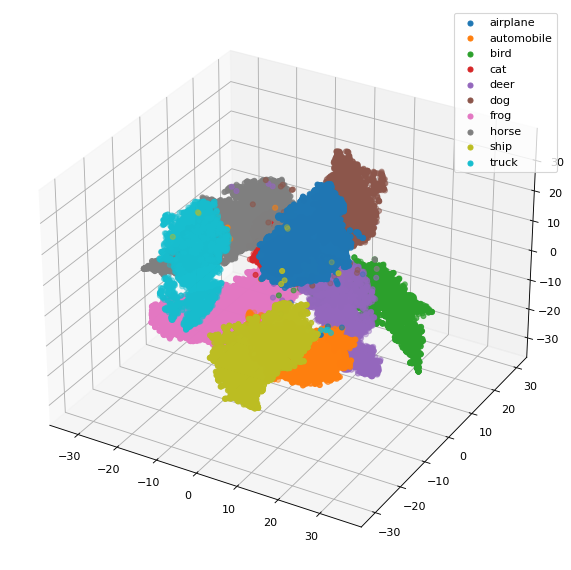

In [ ]:
# Creating figure
plt.figure(figsize=(16, 9), dpi=80)
ax = plt.axes(projection ="3d")

for i in range(len(classes)):
  ax.scatter3D(train_embedded_tsne[y_train == i][:,0], train_embedded_tsne[y_train == i][:,1], train_embedded_tsne[y_train == i][:,2], label=classes[i])
plt.legend()
 
# show plot
plt.show()

In [ ]:
from sklearn.mixture import GaussianMixture

individual_gms = []
for i in range(len(classes)):
  individual_gms.append(GaussianMixture(n_components=1, random_state=7).fit(train_embedded_tsne[y_train == i]))

In [ ]:
from scipy import linalg

means = []
eigen_vecs = []
stds = []
for i_gm in individual_gms:
  means.append(i_gm.means_[0])
  v, w = linalg.eigh(i_gm.covariances_[0])
  v = 2.0 * np.sqrt(7.815) * np.sqrt(v)
  stds.append(v)
  eigen_vecs.append(w)


means = np.array(means)
eigen_vecs = np.array(eigen_vecs)
stds = np.array(stds)

print(means.shape)
print(stds.shape)
print(eigen_vecs.shape)

(10, 3)
(10, 3)
(10, 3, 3)


In [ ]:
max_std = np.max(stds)
max_len = int(max_std)+2

# reg = np.zeros([max_len]*feature_space)
reg_shape = (max_len,)*feature_space
center = np.array(reg_shape) // 2
center, max_len, max_std

(array([26, 26, 26]), 53, 51.082923854051124)

In [ ]:
indices=np.indices(reg_shape)
indices=np.transpose(indices,list(np.arange(1,len(reg_shape)+1))+[0])
indices=indices.reshape((np.prod(reg_shape), feature_space))
indices,indices.shape

(array([[ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  0,  2],
        ...,
        [52, 52, 50],
        [52, 52, 51],
        [52, 52, 52]]),
 (148877, 3))

In [ ]:
regions = []
vecs = indices - center
vec_norms = np.linalg.norm(vecs, axis=-1) + 1e-31
print("vec_norms done")
for i in range(num_classes):
  ellipse = np.sum(vecs[:, None, :] * eigen_vecs[i][None, :, :], axis=-1)
  ellipse = np.abs(ellipse/(vec_norms[:, None] * np.linalg.norm(eigen_vecs[i], axis=-1)[None, :]))
  ellipse = np.linalg.norm(np.sum((ellipse * (stds[i][None, :]/2))[:, :, None] * eigen_vecs[i][None, :, :], axis=1), axis=-1) + 1e-25
  ellipse = (vec_norms <= ellipse).reshape(reg_shape).astype(np.float32)

  regions.append(ellipse)
  print(i+1)

vec_norms done
1
2
3
4
5
6
7
8
9
10


In [14]:
num_clusters = len(classes)
classes_dict = {c:num for c,num in zip(classes, range(len(classes)))}
classes_dict_inverse = {num:c for c,num in zip(classes, range(len(classes)))}
classes_dict, classes_dict_inverse

({'airplane': 0,
  'automobile': 1,
  'bird': 2,
  'cat': 3,
  'deer': 4,
  'dog': 5,
  'frog': 6,
  'horse': 7,
  'ship': 8,
  'truck': 9},
 {0: 'airplane',
  1: 'automobile',
  2: 'bird',
  3: 'cat',
  4: 'deer',
  5: 'dog',
  6: 'frog',
  7: 'horse',
  8: 'ship',
  9: 'truck'})

In [ ]:
clusters = classes
overlaps = {}
# cardinality = 1
top_sets = [set([c]) for c in clusters]
for cardinality in range(2,num_clusters+1):
  # print(cardinality)
  for ts in top_sets:
    for clus in clusters:
      s = ts.copy()
      s.add(clus)
      s = sorted(s)
      if len(s) == cardinality and ",".join(s) not in overlaps:
        region = np.zeros_like(regions[0])
        smallest_region = np.inf
        for num, name in enumerate(s):
          c = classes_dict[name]
          if num == 0:
            region += regions[c]
            reg_cen = means[c]
          else:
            top_corner = means[c] - reg_cen
            if any(top_corner < -max_len) or any(top_corner > max_len):
              pass
            else:
              limits = []
              start_points = []
              for val in top_corner:
                if val<0:
                  limits.append((int(abs(val)), max_len))
                  start_points.append(0)
                else:
                  limits.append((0, max_len - int(val)))
                  start_points.append(int(val))
              # cutout = regions[c][limits[0][0]:limits[0][1], limits[1][0]:limits[1][1], limits[2][0]:limits[2][1]]

              # region[start_points[0]:start_points[0]+cutout.shape[0], start_points[1]:start_points[1]+cutout.shape[1], start_points[2]:start_points[2]+cutout.shape[2]] += cutout

              eval_s = []
              for n1 in range(len(limits)):
                eval_s.append(f"{limits[n1][0]}:{limits[n1][1]}")
              eval_s = ",".join(eval_s)
              cutout = eval(f"regions[{c}][{eval_s}]")

              eval_s = []
              for n1 in range(len(start_points)):
                eval_s.append(f"{start_points[n1]}:{start_points[n1]}+{cutout.shape[n1]}")
              eval_s = ",".join(eval_s)
              exec(f"region[{eval_s}] += cutout")

          if np.sum(regions[c])<smallest_region:
            smallest_region = np.sum(regions[c])

        intersection = np.sum([region == len(s)])
        #op = intersection / smallest_region
        op = intersection / np.sum(region!=0)
        # print("s", ",".join(s))
        overlaps[",".join(s)] = op
  keys = np.array(list(overlaps.keys()))
  values = np.array(list(overlaps.values()))
  arg_sorted = np.argsort(values, kind="stable")[::-1]
  top_sets = [set([num for num in cl.split(",")]) for cl in keys[arg_sorted[:k]] if len(set([num for num in cl.split(",")]))==cardinality]

len(overlaps)

163

In [ ]:
keys = list(overlaps.keys())
keys = np.array([set([num for num in cl.split(",")]) for cl in keys])
values = np.array(list(overlaps.values()))
arg_sorted = np.argsort(values, kind="stable")[::-1]

In [ ]:
keys[arg_sorted[:k]]

array([{'automobile', 'deer'}, {'deer', 'bird'}, {'automobile', 'bird'},
       {'frog', 'cat'}, {'automobile', 'ship'}, {'frog', 'deer'},
       {'automobile', 'bird', 'deer'}, {'cat', 'truck'},
       {'frog', 'automobile'}, {'horse', 'dog'}, {'frog', 'bird'},
       {'deer', 'cat'}, {'dog', 'bird'}, {'frog', 'automobile', 'deer'},
       {'horse', 'truck'}, {'automobile', 'cat'}, {'frog', 'ship'},
       {'dog', 'cat'}, {'frog', 'deer', 'bird'}, {'horse', 'cat'}],
      dtype=object)

In [ ]:
values[arg_sorted[:k]]

array([0.27411611, 0.19799653, 0.12615737, 0.12387774, 0.11207574,
       0.10713533, 0.09812487, 0.08892953, 0.08536929, 0.08440733,
       0.06762831, 0.06126563, 0.06032021, 0.05491598, 0.05463367,
       0.05358361, 0.05144662, 0.0512052 , 0.0459216 , 0.04270214])

In [ ]:
new_k = min(k, np.sum(values[arg_sorted[:k]] != 0))
new_k

20

In [ ]:
# new_classes = [{'cat', 'dog'}, {'deer', 'bird'}, {'cat', 'bird'},
#        {'frog', 'bird'}, {'airplane', 'bird'}, {'cat', 'deer'},
#        {'cat', 'frog'}, {'dog', 'deer'}, {'airplane', 'ship'},
#        {'horse', 'deer'}, {'automobile', 'truck'}, {'dog', 'bird'},
#        {'horse', 'dog'}, {'cat', 'dog', 'bird'}, {'automobile', 'ship'},
#        {'cat', 'frog', 'bird'}, {'cat', 'dog', 'deer'},
#        {'airplane', 'truck'}, {'cat', 'deer', 'bird'}, {'ship', 'bird'},
#        {'deer', 'frog'}, {'airplane', 'horse'}, {'cat', 'automobile'},
#        {'cat', 'horse'}, {'horse', 'bird'}, {'airplane', 'deer'},
#        {'cat', 'truck'}, {'automobile', 'bird'}, {'airplane', 'cat'},
#        {'dog', 'frog'}, {'airplane', 'ship', 'bird'},
#        {'dog', 'deer', 'bird'}, {'cat', 'dog', 'frog'},
#        {'frog', 'deer', 'bird'}, {'cat', 'horse', 'dog'},
#        {'cat', 'dog', 'deer', 'bird'}, {'horse', 'deer', 'bird'},
#        {'dog', 'horse', 'deer'}, {'airplane', 'deer', 'bird'},
#        {'cat', 'deer', 'frog'}, {'frog', 'dog', 'bird'}, {'cat', 'ship'},
#        {'cat', 'frog', 'dog', 'bird'}, {'airplane', 'cat', 'bird'},
#        {'cat', 'frog', 'deer', 'bird'}, {'cat', 'horse', 'deer'},
#        {'ship', 'frog'}, {'cat', 'automobile', 'bird'},
#        {'airplane', 'automobile'}, {'airplane', 'horse', 'bird'},
#        {'automobile', 'ship', 'bird'}, {'automobile', 'dog'},
#        {'truck', 'ship'}, {'truck', 'dog'},
#        {'cat', 'horse', 'dog', 'deer'}, {'dog', 'deer', 'frog'},
#        {'cat', 'ship', 'bird'}, {'airplane', 'ship', 'cat'},
#        {'airplane', 'frog'}, {'airplane', 'automobile', 'ship'}]

In [ ]:
new_classes = [set([c]) for c in classes] + list(keys[arg_sorted[:new_k]])# + [set(classes)]
new_classes

[{'airplane'},
 {'automobile'},
 {'bird'},
 {'cat'},
 {'deer'},
 {'dog'},
 {'frog'},
 {'horse'},
 {'ship'},
 {'truck'},
 {'automobile', 'deer'},
 {'bird', 'deer'},
 {'automobile', 'bird'},
 {'cat', 'frog'},
 {'automobile', 'ship'},
 {'deer', 'frog'},
 {'automobile', 'bird', 'deer'},
 {'cat', 'truck'},
 {'automobile', 'frog'},
 {'dog', 'horse'},
 {'bird', 'frog'},
 {'cat', 'deer'},
 {'bird', 'dog'},
 {'automobile', 'deer', 'frog'},
 {'horse', 'truck'},
 {'automobile', 'cat'},
 {'frog', 'ship'},
 {'cat', 'dog'},
 {'bird', 'deer', 'frog'},
 {'cat', 'horse'}]

In [15]:
new_classes = [{'airplane'},
 {'automobile'},
 {'bird'},
 {'cat'},
 {'deer'},
 {'dog'},
 {'frog'},
 {'horse'},
 {'ship'},
 {'truck'},
 {'automobile', 'deer'},
 {'bird', 'deer'},
 {'automobile', 'bird'},
 {'cat', 'frog'},
 {'automobile', 'ship'},
 {'deer', 'frog'},
 {'automobile', 'bird', 'deer'},
 {'cat', 'truck'},
 {'automobile', 'frog'},
 {'dog', 'horse'},
 {'bird', 'frog'},
 {'cat', 'deer'},
 {'bird', 'dog'},
 {'automobile', 'deer', 'frog'},
 {'horse', 'truck'},
 {'automobile', 'cat'},
 {'frog', 'ship'},
 {'cat', 'dog'},
 {'bird', 'deer', 'frog'},
 {'cat', 'horse'}]

In [ ]:
# with open("/home/shireen/RS-CNN/CIFAR10_ResNet50/saved_ResNet50/RSCNN/new_classes.pkl", 'wb') as new_class:
#     pickle.dump(new_classes, new_class)

In [ ]:
# with open("/home/shireen/RS-CNN/CIFAR10_ResNet50/saved_ResNet50/new_classes.pkl", 'rb') as new_class:
#     new_classes = pickle.load(new_class)

In [17]:
new_classes

[{'airplane'},
 {'automobile'},
 {'bird'},
 {'cat'},
 {'deer'},
 {'dog'},
 {'frog'},
 {'horse'},
 {'ship'},
 {'truck'},
 {'automobile', 'deer'},
 {'bird', 'deer'},
 {'automobile', 'bird'},
 {'cat', 'frog'},
 {'automobile', 'ship'},
 {'deer', 'frog'},
 {'automobile', 'bird', 'deer'},
 {'cat', 'truck'},
 {'automobile', 'frog'},
 {'dog', 'horse'},
 {'bird', 'frog'},
 {'cat', 'deer'},
 {'bird', 'dog'},
 {'automobile', 'deer', 'frog'},
 {'horse', 'truck'},
 {'automobile', 'cat'},
 {'frog', 'ship'},
 {'cat', 'dog'},
 {'bird', 'deer', 'frog'},
 {'cat', 'horse'}]

In [13]:
# new_classes_1024 = np.load("/home/shireen/RSCNN/saved_ResNet50/new_classes_1024_shuffle.npy", allow_pickle=True)
# len(new_classes_1024)

1023

In [40]:
# import itertools
# import random

# def powerset(iterable):
#     s = list(iterable)
#     return (set(combination) for i in range(len(s) + 1) for combination in itertools.combinations(s, i))

# new_classes = list(powerset(classes))
# new_classes = new_classes[1:]
# # np.save('saved_ResNet50/new_classes_1024.npy', new_classes)
# to_shuffle = new_classes[10:]
# random.shuffle(to_shuffle)

# new_classes = new_classes[:10] + to_shuffle

# print(f"Powerset of classes (total {len(new_classes)} subsets):")
# for subset in new_classes[:20]:
#     print(subset)

Powerset of classes (total 1023 subsets):
{'airplane'}
{'automobile'}
{'bird'}
{'cat'}
{'deer'}
{'dog'}
{'frog'}
{'horse'}
{'ship'}
{'truck'}
{'airplane', 'frog', 'automobile', 'cat'}
{'airplane', 'automobile', 'frog', 'cat', 'deer', 'dog'}
{'horse', 'bird', 'automobile'}
{'bird', 'automobile', 'ship', 'horse', 'frog', 'deer'}
{'airplane', 'bird', 'automobile', 'ship', 'horse', 'truck', 'dog'}
{'airplane', 'bird', 'ship', 'frog', 'cat'}
{'horse', 'airplane', 'deer'}
{'airplane', 'ship', 'automobile', 'horse', 'frog', 'truck'}
{'airplane', 'truck', 'automobile', 'cat'}
{'airplane', 'deer', 'automobile'}


In [ ]:
y_test_modified

In [25]:
# Modifying the ground truth with belief encoding
def groundtruthmod(y, new_classes):
    y_encoded = np.zeros((len(y), len(new_classes)), dtype=int)
    for i, label in enumerate(y):
        for j, class_ in enumerate(new_classes):
            if class_.issubset(set(classes)) and classes_dict_inverse[label] in class_:
                y_encoded[i, j] = 1
    return y_encoded

y_train_modified = groundtruthmod(y_train, new_classes)
y_test_modified = groundtruthmod(y_test, new_classes)
y_val_modified = groundtruthmod(y_val, new_classes)

In [33]:
y_train_modified_1024 = groundtruthmod(y_train, new_classes_1024)
y_test_modified_1024 = groundtruthmod(y_test, new_classes_1024)
y_val_modified_1024 = groundtruthmod(y_val, new_classes_1024)

In [24]:
y_train_modified.shape, y_train_modified_1024.shape

((40000, 30), (40000, 1023))

In [21]:
mass_co = np.zeros((len(new_classes), len(new_classes)))
# mass_co = np.zeros((len(new_classes_1024), len(new_classes_1024)))

def mass_coeff(new_classes):
    for i, A in enumerate(new_classes):
        for j, B in enumerate(new_classes):
            leng = 0
            if set(B).issubset(set(A)):
                leng = (-1) ** (len(A) - len(B))
            mass_co[j][i] = leng
    return mass_co

mass_coeff_matrix = mass_coeff(new_classes)
print(mass_coeff_matrix)

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0. -1.  0. -1.  0.  1.  0.
  -1.  0.  0.  0.  0.  1.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0. -1. -1.  0.  0.  0.  1.  0.
   0.  0. -1.  0. -1.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0. -1.
   0.  0.  0. -1.  0.  0.  0. -1.  0. -1.  0. -1.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0. -1. -1.  0.  0.  0. -1.  1.  0.
   0.  0.  0. -1.  0.  1.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0. -1.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0. -1.  0. -1.  0.  0.
  -1.  0. -1.  0.  0.  1.  0.  0. -1.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0. -1.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.]


In [38]:
mass_coeff_matrix_1024 = mass_coeff(new_classes_1024)

In [24]:
mass_coeff_matrix = mass_coeff(new_classes)
mass_coeff_matrix = tf.cast(mass_coeff_matrix, tf.float32)

ALPHA = 0.01
BETA = 0.01

@keras.saving.register_keras_serializable(package="my_package", name="BinaryCrossEntropy")

def BinaryCrossEntropy(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_true = K.clip(y_true, K.epsilon(), 1)
  y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
  term_0 = (1 - y_true) * K.log(1 - y_pred + K.epsilon())  
  term_1 = y_true * K.log(y_pred + K.epsilon())
  bce_loss = -K.mean(term_0 + term_1, axis=0)
  
  mass = tf.matmul(y_pred, mass_coeff_matrix)

  # alpha = tf.cast(tf.where(mass >= 0, tf.ones_like(mass), tf.zeros_like(mass)), dtype=tf.float32)
  
  mass_reg = K.mean(tf.nn.relu(-mass))

  mass_sum = tf.nn.relu(K.mean(K.sum(mass, axis=-1)) - 1)
  
  #add alpha to bce term 1 or 2
  # alpha_reg = -K.mean((1 - alpha) * K.log(1 - y_true + K.epsilon()) + alpha * K.log(y_true + K.epsilon()), axis = 0)
  

  total_loss = bce_loss + ALPHA * mass_reg + BETA * mass_sum
  # tf.print(K.mean(bce_loss), K.sum(mass_reg), K.mean(total_loss))

  return total_loss

In [23]:
mass_coeff_matrix_1024 = mass_coeff(new_classes_1024)
mass_coeff_matrix_1024 = tf.cast(mass_coeff_matrix_1024, tf.float32)

ALPHA = 0.01
BETA = 0.01

@keras.saving.register_keras_serializable(package="my_package", name="BinaryCrossEntropy")

def BinaryCrossEntropy(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_true = K.clip(y_true, K.epsilon(), 1)
  y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
  term_0 = (1 - y_true) * K.log(1 - y_pred + K.epsilon())  
  term_1 = y_true * K.log(y_pred + K.epsilon())
  bce_loss = -K.mean(term_0 + term_1, axis=0)
  
  mass = tf.matmul(y_pred, mass_coeff_matrix)

  # alpha = tf.cast(tf.where(mass >= 0, tf.ones_like(mass), tf.zeros_like(mass)), dtype=tf.float32)
  
  mass_reg = K.mean(tf.nn.relu(-mass))

  mass_sum = tf.nn.relu(K.mean(K.sum(mass, axis=-1)) - 1)
  
  #add alpha to bce term 1 or 2
  # alpha_reg = -K.mean((1 - alpha) * K.log(1 - y_true + K.epsilon()) + alpha * K.log(y_true + K.epsilon()), axis = 0)
  

  total_loss = bce_loss + ALPHA * mass_reg + BETA * mass_sum
  # tf.print(K.mean(bce_loss), K.sum(mass_reg), K.mean(total_loss))

  return total_loss

NameError: name 'new_classes_1024' is not defined

In [19]:
# with strategy.scope():
inputs = tf.keras.layers.Input(shape=(32, 32, 3))
resize = tf.keras.layers.UpSampling2D(size=(7, 7))(inputs)
new_base_model = tf.keras.applications.ResNet50(input_shape=(224, 224, 3), include_top=False, weights=None)(resize)

#base_model.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(new_base_model)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
outputs = tf.keras.layers.Dense(len(new_classes), activation="sigmoid", name="classification")(x)

new_model = tf.keras.Model(inputs=inputs, outputs=outputs)
new_model.compile(loss=BinaryCrossEntropy,
            optimizer="adam",
            metrics=['binary_accuracy'])

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]

NameError: name 'BinaryCrossEntropy' is not defined

In [40]:
# with strategy.scope():
inputs = tf.keras.layers.Input(shape=(32, 32, 3))
resize = tf.keras.layers.UpSampling2D(size=(7, 7))(inputs)
new_base_model = tf.keras.applications.ResNet50(input_shape=(224, 224, 3), include_top=False, weights=None)(resize)

#base_model.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(new_base_model)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
outputs = tf.keras.layers.Dense(len(new_classes_1024), activation="sigmoid", name="classification")(x)

new_model_1024 = tf.keras.Model(inputs=inputs, outputs=outputs)
new_model_1024.compile(loss=BinaryCrossEntropy,
            optimizer="adam",
            metrics=['binary_accuracy'])

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]

In [35]:
# new_model = tf.keras.models.clone_model(aux_model)
# new_output_layer = Dense(len(new_classes), activation="sigmoid")(new_model.output)
# new_model = Model(new_model.input, new_output_layer)



new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2  (None, 224, 224, 3)       0         
 D)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098

In [24]:
# compile model
#opt = SGD(learning_rate=0.0001, momentum=0.9)
# new_model.compile(loss=BinaryCrossEntropy,
#               optimizer="adam",
#               metrics=['binary_accuracy'])

start = time.time()

history_new = new_model.fit(datagen.flow(x_train, y_train_modified, batch_size=batch_size),
                    validation_data=(x_val, y_val_modified),
                    epochs=epochs, verbose=1, workers=2,
                   callbacks=callbacks)

Learning rate:  0.001
Epoch 1/100


2024-08-04 22:16:27.600330: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-08-04 22:16:27.600374: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-08-04 22:16:27.601227: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-08-04 22:16:27.601804: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas be

  1/313 [..............................] - ETA: 2:15:21 - loss: 0.7944 - binary_accuracy: 0.4943

2024-08-04 22:16:44.887711: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



313/313 [==============================] - 85s 190ms/step - loss: 0.4209 - binary_accuracy: 0.8254 - val_loss: 0.4026 - val_binary_accuracy: 0.8285 - lr: 0.0010
Learning rate:  0.001
Epoch 2/100
313/313 [==============================] - 57s 182ms/step - loss: 0.3524 - binary_accuracy: 0.8440 - val_loss: 0.5234 - val_binary_accuracy: 0.8094 - lr: 0.0010
Learning rate:  0.001
Epoch 3/100
313/313 [==============================] - 57s 182ms/step - loss: 0.3097 - binary_accuracy: 0.8644 - val_loss: 0.3968 - val_binary_accuracy: 0.8403 - lr: 0.0010
Learning rate:  0.001
Epoch 4/100
313/313 [==============================] - 57s 182ms/step - loss: 0.2692 - binary_accuracy: 0.8827 - val_loss: 1.0476 - val_binary_accuracy: 0.8366 - lr: 0.0010
Learning rate:  0.001
Epoch 5/100
313/313 [==============================] - 57s 181ms/step - loss: 0.2379 - binary_accuracy: 0.8980 - val_loss: 0.3439 - val_binary_accuracy: 0.8622 - lr: 0.0010
Learning rate:  0.001
Epoch 6/100
313/313 [================

In [25]:
# opt = Adam(learning_rate=1e-7)
# new_model.compile(optimizer=opt, loss=BinaryCrossEntropy, metrics=['binary_accuracy'])
history_new = new_model.fit(datagen.flow(x_train, y_train_modified, batch_size=batch_size),
                    validation_data=(x_val, y_val_modified),
                    epochs=epochs, verbose=1, workers=2,
                    callbacks=callbacks)

end = time.time()

Learning rate:  0.001
Epoch 1/100


313/313 [==============================] - 57s 182ms/step - loss: 0.0347 - binary_accuracy: 0.9875 - val_loss: 0.1572 - val_binary_accuracy: 0.9594 - lr: 0.0010
Learning rate:  0.001
Epoch 2/100
313/313 [==============================] - 57s 182ms/step - loss: 0.0209 - binary_accuracy: 0.9925 - val_loss: 0.1218 - val_binary_accuracy: 0.9661 - lr: 0.0010
Learning rate:  0.001
Epoch 3/100
313/313 [==============================] - 57s 182ms/step - loss: 0.0162 - binary_accuracy: 0.9941 - val_loss: 0.1274 - val_binary_accuracy: 0.9658 - lr: 0.0010
Learning rate:  0.001
Epoch 4/100
313/313 [==============================] - 57s 182ms/step - loss: 0.0137 - binary_accuracy: 0.9950 - val_loss: 0.1290 - val_binary_accuracy: 0.9685 - lr: 0.0010
Learning rate:  0.001
Epoch 5/100
313/313 [==============================] - 57s 182ms/step - loss: 0.0133 - binary_accuracy: 0.9953 - val_loss: 0.1162 - val_binary_accuracy: 0.9692 - lr: 0.0010
Learning rate:  0.001
Epoch 6/100
313/313 [================

In [26]:
new_model.save('saved_ResNet50/RSCNN/ResNet50_CIFAR10_alpha_beta_0.keras')

In [27]:
new_model_weights = new_model.get_weights()

In [28]:
with open('saved_ResNet50/RSCNN/ResNet50_CIFAR10_alpha_beta_0_weights.pkl', 'wb') as weights_file:
    pickle.dump(new_model_weights, weights_file)

In [22]:
with open('/home/shireen/RSCNN/saved_ResNet50/RSCNN/ResNet50_CIFAR10_weights.pkl', 'rb') as weights_file:
    saved_weights = pickle.load(weights_file)

In [21]:
new_model = tf.keras.saving.load_model('/home/shireen/RSCNN/saved_ResNet50/RSCNN/ResNet50_CIFAR10_pretrained.h5', custom_objects={'BinaryCrossEntropy': BinaryCrossEntropy})

In [25]:
with open('/home/shireen/RSCNN/saved_ResNet50/RSCNN/ResNet50_CIFAR10_alpha_beta_0_weights.pkl', 'rb') as weights_file:
    saved_weights = pickle.load(weights_file)
    
new_model = tf.keras.saving.load_model('/home/shireen/RSCNN/saved_ResNet50/RSCNN/ResNet50_CIFAR10_alpha_beta_0.keras', custom_objects={'BinaryCrossEntropy': BinaryCrossEntropy})

# new_classes_1024 = list(new_classes_1024)
# new_classes_with_full_1024 = new_classes_1024
# # with strategy.scope():
# inputs = tf.keras.layers.Input(shape=(32, 32, 3))
# resize = tf.keras.layers.UpSampling2D(size=(7, 7))(inputs)
# new_base_model = tf.keras.applications.ResNet50(input_shape=(224, 224, 3), include_top=False, weights=None)(resize)

# #base_model.trainable = False

# x = tf.keras.layers.GlobalAveragePooling2D()(new_base_model)
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(1024, activation="relu")(x)
# x = tf.keras.layers.Dense(512, activation="relu")(x)
# outputs = tf.keras.layers.Dense(len(new_classes_1024), activation="sigmoid", name="classification")(x)

# new_model_1024 = tf.keras.Model(inputs=inputs, outputs=outputs)
# new_model_1024.compile(loss=BinaryCrossEntropy,
#             optimizer="adam",
#             metrics=['binary_accuracy'])

# lr_scheduler = LearningRateScheduler(lr_schedule)

# lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
#                                cooldown=0,
#                                patience=5,
#                                min_lr=0.5e-6)

# callbacks = [lr_reducer, lr_scheduler]
# new_model_1024.set_weights(saved_weights_1024)

# test_preds_1024 = new_model_1024.predict(x_test, verbose=1)
# test_preds_1024.shape

# # #Mobius inverse function
# # def belief_to_mass(y_pred, set_c):
# #     n_samples, n_classes = y_pred.shape
# #     n_sets = len(set_c)
# #     mass = np.zeros((n_samples, n_sets))

# #     for i in range(n_samples):
# #         for j in range(n_sets):
# #             A = set_c[j]
# #             mass_ij = 0
# #             #for k in range(n_classes):
# #             for B in set_c:
# #                   #b_idx = [idx for idx, val in enumerate(B) if val in A]
# #                   if set(B).issubset(A):
# #                     b_idx = set_c.index(B)
# #                     mass_ij += ((-1)**(len(A)-len(B))) * (y_pred[i, b_idx])
# #                     #mass_ij += ((-1)**(len(A)-len(B))) * y_pred[i, k]
# #             mass[i][j] = mass_ij
# #     return mass

# # # convert to mass function
# # test_preds_mass_1024 = belief_to_mass(test_preds_1024, new_classes_1024)
# test_preds_mass_1024 = tf.matmul(test_preds_1024, mass_coeff_matrix_1024)
# test_preds_mass_1024 = np.array(test_preds_mass_1024)
# test_preds_mass_1024[test_preds_mass_1024<0] = 0


  
# # def betp(mass, set_c, x):
# #     betp_x = 0
# #     for j,A in enumerate(set_c):
# #         if set([x]).issubset(A):
# #                 betp_x += mass[j] / len(A)
# #     return betp_x
  

# # def final_betp(mass, classes):
# #   final_bet = []
# #   for m in range(mass.shape[0]):
# #     bet_p = []
# #     for n in classes:
# #       bet_p.append(betp(mass[m], new_classes_1024, n))
# #       #bet_p.append(betp(mass[m], new_classes, n))
# #     final_bet.append(bet_p)
# #   final_bet = np.asarray(final_bet)
# #   return final_bet
# final_bet_p_1024 = test_preds_mass_1024 @ betp_approx(classes)


# final_bet_p_indices_1024 = np.argmax(final_bet_p_1024, axis = -1)
# accuracy_1024 = (np.sum(final_bet_p_indices_1024 == y_test)/len(y_test))*100
# print(f"Test Accuracy using pignistic probability: {accuracy_1024}%")

In [26]:
def betp_approx(classes):
  mask = []
  for j, n in enumerate(classes):
      mask.append([])
      for k, A in enumerate(new_classes):
          if set([n]).issubset(A):
              mask[-1].append( 1 / len(A))
          else:
              mask[-1].append(0)

  mask = np.array(mask).T
  return mask

In [25]:
# np.save("/home/shireen/RSCNN/saved_ResNet50/test_preds_mass_1024.npy", test_preds_mass_1024)
# np.save("/home/shireen/RSCNN/saved_ResNet50/final_bet_p_1024.npy", final_bet_p_1024)

NameError: name 'test_preds_1024' is not defined

In [27]:
inputs = tf.keras.layers.Input(shape=(32, 32, 3))
resize = tf.keras.layers.UpSampling2D(size=(7, 7))(inputs)
new_base_model = tf.keras.applications.ResNet50(input_shape=(224, 224, 3), include_top=False, weights=None)(resize)

#base_model.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(new_base_model)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
outputs = tf.keras.layers.Dense(len(new_classes), activation="sigmoid", name="classification")(x)

new_model = tf.keras.Model(inputs=inputs, outputs=outputs)
#new_model.compile(optimizer="adam")
new_model.compile(loss=BinaryCrossEntropy,
              optimizer="adam",
              metrics=['binary_accuracy'])
new_model.summary()
new_model.set_weights(saved_weights)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d_1 (UpSamplin  (None, 224, 224, 3)       0         
 g2D)                                                            
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              2098

In [ ]:
# import cv2

# x_test= np.array([cv2.resize(image, (224, 224)) for image in x_test])

In [ ]:
# test_preds = np.load("/home/shireen/RS-CNN/CIFAR10_ResNet50/saved_ResNet50/test_preds.npy")

In [28]:
test_preds = new_model.predict(x_test, verbose=1)
test_preds.shape

2024-08-08 17:50:31.828607: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2024-08-08 17:50:31.992992: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-08-08 17:50:31.995487: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2024-08-08 17:50:31.995536: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2024-08-08 17:50:31.995679: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


  9/313 [..............................] - ETA: 4s

2024-08-08 17:50:32.451170: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-08-08 17:50:32.453616: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-08-08 17:50:32.497654: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-08-08 17:50:32.499899: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


313/313 [==============================] - 7s 17ms/step


(10000, 30)

In [25]:
np.save("/home/shireen/RSCNN/saved_ResNet50/test_preds_1024.npy", test_preds)

In [188]:
import numpy as np

# Assuming test_preds is a NumPy array
indices = np.where((test_preds >= 0.4) & (test_preds <= 0.8))

# Length of the indices array
print("Number of indices:", len(indices[0]))

# Optionally, print the first few indices
print("First few indices:", indices[0][:30])  # Change 10 to however many indices you want to print


Number of indices: 1668
First few indices: [ 58  58  58  87  87  87  95  95  95  95 158 158 158 158 158 158 169 169
 169 189 189 189 189 224 224 224 224 224 224 224]


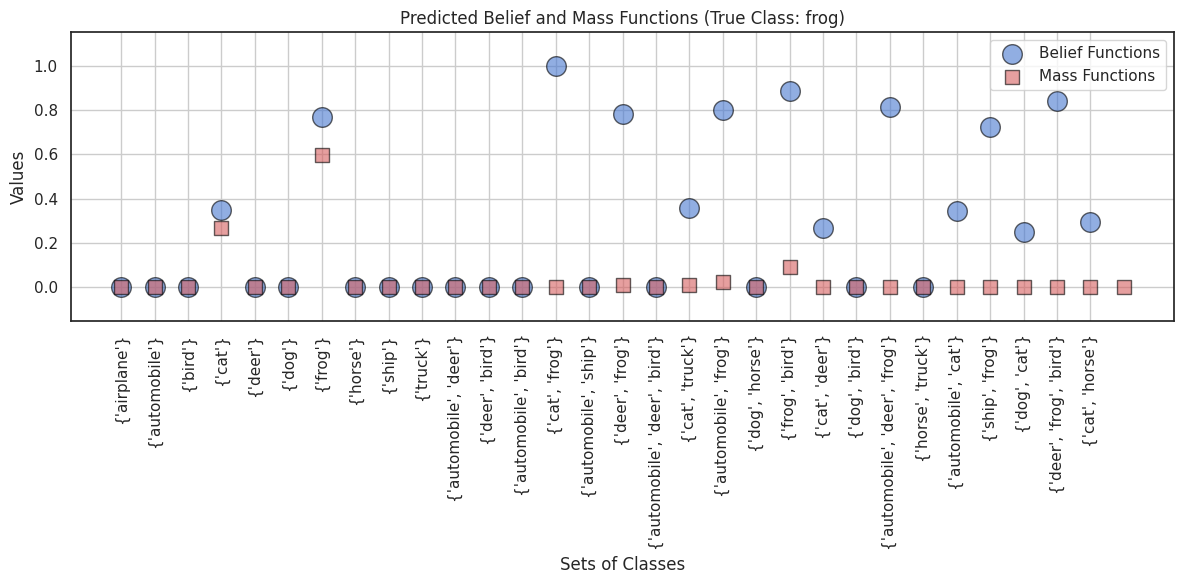

In [265]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# sns.set(style = "white",palette="muted")

i = 95

ax.scatter(np.arange(test_preds.shape[1]), test_preds[i], color='b', s=200, edgecolor='black', alpha=0.6, label='Belief Functions')
ax.scatter(np.arange(test_preds_mass.shape[1]), test_preds_mass[i], color='r', s=100, edgecolor='black', alpha=0.6, marker='s', label='Mass Functions')
ax.set_title('Predicted Belief and Mass Functions (True Class: {})'.format(classes[y_test[i]]))
ax.set_xlabel('Sets of Classes')
ax.set_ylabel('Values')
ax.set_xticks(np.arange(test_preds.shape[1]))
ax.set_xticklabels(new_classes, rotation=90)
ax.set_ylim([-0.15, 1.15])
ax.grid(True)
ax.legend()


# ax[1].scatter(np.arange(test_preds_mass.shape[1]), test_preds_mass[i], color='b', s=200, edgecolor='black', alpha=0.6)
# ax[1].set_title('Mass Functions (True Class: {})'.format(classes[y_test[i]]))
# ax[1].set_xlabel('Sets of Classes')
# ax[1].set_ylabel('Mass Functions')
# ax[1].set_xticks(np.arange(test_preds.shape[1]))
# ax[1].set_xticklabels(new_classes, rotation=90)
# ax[1].set_ylim([-0.15, 1.15])
# ax[1].grid(True)

plt.tight_layout()
plt.savefig("/home/shireen/RSCNN/saved_ResNet50/RS_CNN_preds_belief_functions.pdf", format="pdf", bbox_inches="tight")
plt.show()

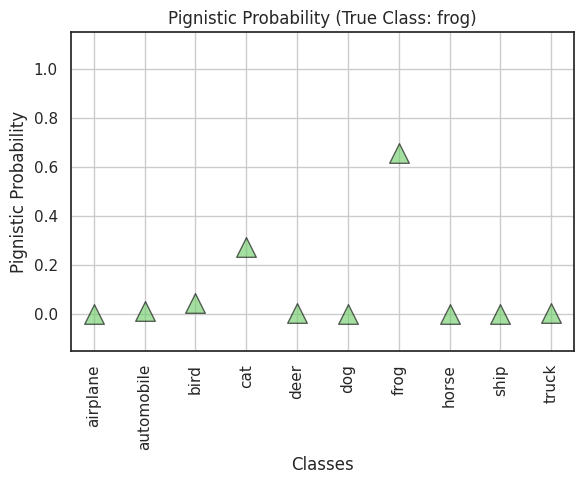

In [281]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

ax.scatter(np.arange(final_bet_p.shape[1]), final_bet_p[i], color='g', s=200, edgecolor='black', marker = '^', alpha=0.6)
ax.set_title('Pignistic Probability (True Class: {})'.format(classes[y_test[i]]))
ax.set_xlabel('Classes')
ax.set_ylabel('Pignistic Probability')
ax.set_xticks(np.arange(final_bet_p.shape[1]))
ax.set_xticklabels(classes, rotation = 90)
ax.set_ylim([-0.15, 1.15])
ax.grid(True)

plt.tight_layout()
plt.savefig("/home/shireen/RSCNN/saved_ResNet50/RS_CNN_preds_pignistic.pdf", format="pdf", bbox_inches="tight")
plt.show()

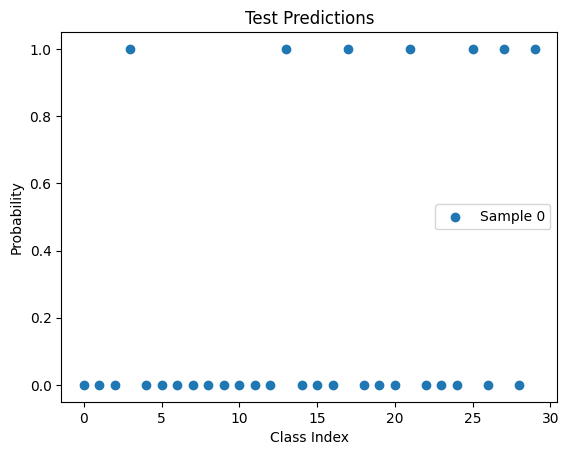

In [114]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming test_preds is your 2D array with shape (10000, 30)

# Slice the array to select the first 10 rows and all columns
sliced_data = test_preds[:1, :]

# Create an array for the x-axis (0 to 29)
x = np.arange(test_preds.shape[1])

# Plot the sliced data
for i in range(len(sliced_data)):
    plt.scatter(x, sliced_data[i], marker='o', label=f'Sample {i}')

plt.xlabel('Class Index')
plt.ylabel('Probability')
plt.title('Test Predictions')
plt.legend()
plt.show()


In [ ]:
input_image = x_test[100]
input_image = np.expand_dims(input_image, axis=0)
input_image.shape

(1, 32, 32, 3)

In [ ]:
import time
times = []
for _ in range(6):
    start = time.time()
    new_model.predict(input_image, verbose=0)
    end = time.time()
    times.append(end - start)
    print(times[-1])

0.36638712882995605
0.04980969429016113
0.04809117317199707
0.05061197280883789
0.04854416847229004
0.04832768440246582


In [ ]:
average_time_ms = np.mean(times[1:]) * 1000
print(f"Average Inference Time: {average_time_ms:.2f} milliseconds")

Average Inference Time: 49.08 milliseconds


In [ ]:

# np.save("/home/shireen/RS-CNN/CIFAR10_ResNet50/saved_ResNet50/test_preds.npy", test_preds)

In [23]:
#Mobius inverse function
def belief_to_mass(y_pred, set_c):
    n_samples, n_classes = y_pred.shape
    n_sets = len(set_c)
    mass = np.zeros((n_samples, n_sets))

    for i in range(n_samples):
        for j in range(n_sets):
            A = set_c[j]
            mass_ij = 0
            #for k in range(n_classes):
            for B in set_c:
                  #b_idx = [idx for idx, val in enumerate(B) if val in A]
                  if set(B).issubset(A):
                    b_idx = set_c.index(B)
                    mass_ij += ((-1)**(len(A)-len(B))) * (y_pred[i, b_idx])
                    #mass_ij += ((-1)**(len(A)-len(B))) * y_pred[i, k]
            mass[i][j] = mass_ij
    return mass

# convert to mass function
test_preds_mass = belief_to_mass(test_preds, new_classes)

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [48]:
test_preds_mass = tf.matmul(test_preds, mass_coeff_matrix)

In [49]:
np.sum(test_preds_mass, axis=-1)

array([1.       , 1.       , 1.0002595, ..., 1.       , 1.       ,
       1.       ], dtype=float32)

In [38]:
test_preds_mass

<tf.Tensor: shape=(10000, 30), dtype=float32, numpy=
array([[ 7.9035288e-17,  6.1142814e-22,  5.6809624e-13, ...,
         0.0000000e+00,  1.1802724e-11,  0.0000000e+00],
       [ 5.2900216e-20,  2.7363413e-16,  2.7472250e-19, ...,
         1.6922398e-19, -5.7800420e-18,  4.4860856e-21],
       [ 1.3559426e-07,  2.1014982e-04,  1.7882080e-07, ...,
         9.7765017e-08,  7.2384023e-07, -2.8715498e-08],
       ...,
       [ 2.3996538e-22,  1.3176704e-19,  2.1667641e-16, ...,
         0.0000000e+00,  1.6367188e-13,  1.3688635e-16],
       [ 9.9754793e-28,  1.0000000e+00,  1.8353840e-23, ...,
         2.2570666e-27,  5.8064124e-20,  8.4731134e-28],
       [ 1.1611386e-33,  0.0000000e+00,  5.2892909e-29, ...,
         1.4105494e-24,  9.8497120e-20,  0.0000000e+00]], dtype=float32)>

In [ ]:
#sns.displot(np.sum(test_preds_mass, axis=-1))
#plt.savefig("massdist_CIFAR10.pdf", format="pdf", bbox_inches="tight",facecolor='w')

In [51]:
test_preds_mass = np.array(test_preds_mass)

In [52]:
test_preds_mass[test_preds_mass<0] = 0
sums_ = 1 - np.sum(test_preds_mass, axis=-1)
sums_[sums_<0] = 0
sums_

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [53]:
test_preds_mass = np.append(test_preds_mass, sums_[:, None], axis=-1)
test_preds_mass = test_preds_mass/np.sum(test_preds_mass, axis=-1)[:, None]
test_preds_mass.shape

(10000, 31)

In [54]:
new_classes_with_full = new_classes + [set(classes)]
new_classes_with_full, len(new_classes_with_full)

([{'airplane'},
  {'automobile'},
  {'bird'},
  {'cat'},
  {'deer'},
  {'dog'},
  {'frog'},
  {'horse'},
  {'ship'},
  {'truck'},
  {'automobile', 'deer'},
  {'bird', 'deer'},
  {'automobile', 'bird'},
  {'cat', 'frog'},
  {'automobile', 'ship'},
  {'deer', 'frog'},
  {'automobile', 'bird', 'deer'},
  {'cat', 'truck'},
  {'automobile', 'frog'},
  {'dog', 'horse'},
  {'bird', 'frog'},
  {'cat', 'deer'},
  {'bird', 'dog'},
  {'automobile', 'deer', 'frog'},
  {'horse', 'truck'},
  {'automobile', 'cat'},
  {'frog', 'ship'},
  {'cat', 'dog'},
  {'bird', 'deer', 'frog'},
  {'cat', 'horse'},
  {'airplane',
   'automobile',
   'bird',
   'cat',
   'deer',
   'dog',
   'frog',
   'horse',
   'ship',
   'truck'}],
 31)

In [43]:
def betp(mass, set_c, x):
    betp_x = 0
    for j,A in enumerate(set_c):
        if set([x]).issubset(A):
                betp_x += mass[j] / len(A)
    return betp_x
  

def final_betp(mass, classes):
  final_bet = []
  for m in range(mass.shape[0]):
    bet_p = []
    for n in classes:
      bet_p.append(betp(mass[m], new_classes_with_full, n))
      #bet_p.append(betp(mass[m], new_classes, n))
    final_bet.append(bet_p)
  final_bet = np.asarray(final_bet)
  return final_bet

In [50]:
np.sum(test_preds_mass, axis = 1)

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [49]:
final_bet_p = test_preds_mass @ betp_approx(classes)

In [55]:
final_bet_p = final_betp(test_preds_mass, classes)
# final_bet_p = final_bet_p/np.sum(final_bet_p, axis=-1)[:, None]
final_bet_p

array([[7.90352877e-17, 6.04245941e-14, 1.13764253e-11, ...,
        8.42169733e-14, 8.01771936e-14, 4.49931665e-14],
       [5.29002164e-20, 1.67589404e-14, 3.74421389e-15, ...,
        1.50039878e-20, 1.00000000e+00, 1.40431976e-20],
       [1.35544894e-07, 4.77021358e-04, 2.95760463e-05, ...,
        1.06887038e-07, 9.99297359e-01, 4.74492616e-07],
       ...,
       [2.39965378e-22, 2.42790794e-15, 7.31384496e-14, ...,
        8.65287103e-17, 1.15922226e-18, 7.30669512e-17],
       [9.97547933e-28, 1.00000000e+00, 1.99395388e-20, ...,
        5.20290066e-25, 5.17686671e-20, 2.64008302e-23],
       [1.16113863e-33, 4.68069823e-22, 3.29106729e-20, ...,
        1.00000000e+00, 1.54471494e-29, 7.21146484e-22]])

In [43]:
y_pred = model.predict(x_test)
#score = (np.sum(y_pred == y_test_one_hot)/len(y_test_one_hot))*100
score = model.evaluate(x_test, y_test_one_hot)
print(f"Test Accuracy of standard CNN for test images: {score[1]*100}%")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: [Errno 28] No space left on device
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: [Errno 28] No space left on device
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
313/313 [==============================] - 6s 16ms/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: [Errno 28] No space left on device
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing t

In [45]:
final_bet_p_indices = np.argmax(final_bet_p, axis = -1)
accuracy = (np.sum(final_bet_p_indices == y_test)/len(y_test))*100
print(f"Test Accuracy using pignistic probability: {accuracy}%")

Test Accuracy using pignistic probability: 92.44%


In [47]:
np.sum(test_preds_mass, axis=-1)

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

/tmp/ipykernel_3995212/2374044472.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.sum(test_preds_mass, axis=-1))


<Axes: ylabel='Density'>

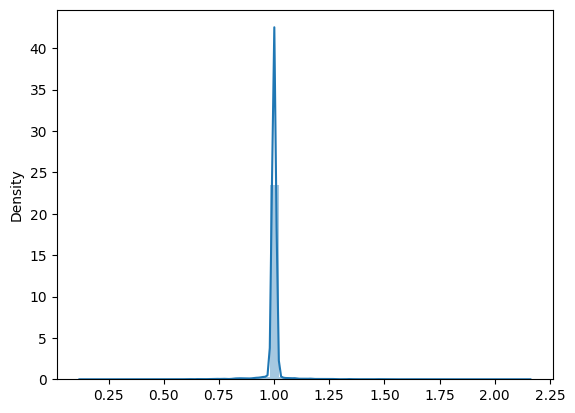

In [50]:
sns.distplot(np.sum(test_preds_mass, axis=-1))

In [48]:
def compute_complement_belief(test_preds, c_index):
    # test_preds_2d = test_preds.reshape(-1, 1)
    c_belief = test_preds[:, c_index]
    complement_belief = np.delete(test_preds, c_index, axis=1)
    
    return c_belief, complement_belief

c_index = 0 
c_belief, complement_belief = compute_complement_belief(test_preds, c_index)
complement_belief.shape

(10000, 29)

In [54]:
def calculate_plausibility(complement_belief):
        plausibility = 1 - complement_belief
        return plausibility

plausibility = calculate_plausibility(complement_belief)
plausibility

array([[1.        , 1.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.99993604, 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 0.        , 1.        ,
        1.        ],
       [0.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.        ]], dtype=float32)

In [56]:
def find_inputs_below_threshold(test_preds, c_index, threshold=0.5):
    below_threshold_indices = []
    for i in range(len(test_preds)):
        plausibility = calculate_plausibility(test_preds[i])
        if plausibility < threshold:
            below_threshold_indices.append(i)
    return below_threshold_indices

below_threshold_indices = find_inputs_below_threshold(test_preds, c_index, threshold=0.95)
print("Indices of inputs with plausibility below 0.5:", below_threshold_indices)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

: 

In [56]:
def non_conformity_score(y_pred, y_true):
    scores = np.zeros_like(y_pred)
    for i in range(len(y_pred)):
        pred_belief = y_pred[i]
        true_label = y_true[i]
        for label in range(len(pred_belief)):
            # if label != true_label:
                non_conformity = 1 - pred_belief[label]
                scores[i, label] = non_conformity
                
    return scores

non_conformity_scores = non_conformity_score(test_preds, y_test)
non_conformity_scores.shape

(10000, 30)

In [57]:
def predictive_regions(scores, significance_level):
    regions = []
    
    for i in range(len(scores)):
        sample_scores = scores[i]
        higher_scores = np.sum(scores > sample_scores)
        
        p = (higher_scores + np.random.uniform()) / (len(scores) + 1)
        if p > significance_level:
            regions.append(False)  # Sample is non-conformal
        else:
            regions.append(True)   # Sample is conformal
            
    return regions

In [59]:
non_conformity_scores = non_conformity_score(test_preds, y_test)
regions = predictive_regions(non_conformity_scores, significance_level=0.9)
print(regions)

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False

In [62]:
def entropy(pred_probs):
    # Avoid log(0) by setting it to a very small value
    eps = 1e-8
    entrop = -np.sum(pred_probs * np.log2(np.clip(pred_probs, eps, 1.0)), axis=1)
    return entrop

entropy_y = entropy(final_bet_p)

In [ ]:
np.max(entropy_y)

3.0310678879635673

In [ ]:
entropy_nguyen = entropy(test_preds_mass)

3013


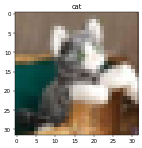

{'horse', 'cat'}			0.9975847005844116
{'horse'}			0.7948681712150574
{'horse', 'truck'}			0.7585539221763611
{'horse', 'dog'}			0.7221317887306213
{'dog', 'cat'}			0.440122127532959

-------------Mass Values----------------------------
{'horse'}			0.6185445390101636
{'cat'}			0.19164768122354328
{'dog', 'cat'}			0.1507261300701029
{'frog', 'cat'}			0.02742021668800858
{'deer', 'cat'}			0.011415640768618234

-------------Pignistic Probabilities----------------------------
horse			0.6185445390101636
cat			0.28642867498690816
dog			0.07551003681395024
frog			0.013711302964962873
deer			0.005710451795566304

-------------Entropy----------------------------


NameError: name 'entropy_y' is not defined

In [36]:
for im_index in np.random.randint(0, len(test_preds), 10):
  print(im_index)
  plt.figure(figsize=(4,4), dpi=40)
  im = x_test_org[im_index]
  plt.imshow(im, cmap="gray")
  plt.title(str(classes[y_test[im_index]]))
  plt.show()
  top_labels = np.argsort(test_preds[im_index])[::-1][:5]
  for t in top_labels:
    print(f"{new_classes[t]}\t\t\t{test_preds[im_index][t]}")
  
  print("\n-------------Mass Values----------------------------")
  top_labels_mass = np.argsort(test_preds_mass[im_index])[::-1][:5]
  for t in top_labels_mass:
    print(f"{new_classes_with_full[t]}\t\t\t{test_preds_mass[im_index][t]}")
  
  print("\n-------------Pignistic Probabilities----------------------------")
  top_labels_pignistic = np.argsort(final_bet_p[im_index])[::-1][:5]
  for t in top_labels_pignistic:
    print(f"{classes[t]}\t\t\t{final_bet_p[im_index][t]}")
      
  print("\n-------------Entropy----------------------------")
  #top_labels_entropy = np.argsort(entropy_y[im_index])[::-1]
  #for t in top_labels_entropy:
  print(f"\t{entropy_y[im_index]}")

  print("\n\n")

### Adversarial attacks

In [30]:
def denormalize_image(image, mean, std):
    denormalized_image = (image * std) + mean
    return denormalized_image

mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.2023, 0.1994, 0.2010])

In [33]:
tf.experimental.numpy.experimental_enable_numpy_behavior()

# x_test_org = x_test_org_nonormalize.astype("float32") / 255

x_test_org_tensor = tf.convert_to_tensor(x_test_org, dtype=tf.float32)
x_test_tensor = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.int32)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test_tensor, y_test_tensor))


batch_size = 100

test_dataset = test_dataset.batch(batch_size)

def fgsm_attack(image, epsilon, data_grad):
    # if epsilon == 0:
    #     perturbed_image = (image - np.array([[[0.4914, 0.4822, 0.4465]]])) / np.array([[[0.2023, 0.1994, 0.2010]]])
    #     return perturbed_image
    # else:
    sign_data_grad = tf.sign(data_grad)
    perturbed_image = image + epsilon * sign_data_grad
    # print(sign_data_grad)
    perturbed_image = tf.clip_by_value(perturbed_image, 0, 1)
    # perturbed_image = perturbed_image.astype("float32") / 255
    perturbed_image = (perturbed_image - np.array([[[0.4914, 0.4822, 0.4465]]])) / np.array([[[0.2023, 0.1994, 0.2010]]])
    return perturbed_image

perturbed_out = []

def test(model, test_dataset, epsilon):
    # Accuracy counter
    accuracy = tf.keras.metrics.Accuracy()
    adv_examples = []

    for data, target in test_dataset:
        with tf.GradientTape() as tape:
            tape.watch(data)
            output = model(data, training=False)
            loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(tf.one_hot(target, depth=num_classes), output))

        data_grad = tape.gradient(loss, data)

        perturbed_data = fgsm_attack(denormalize_image(data, mean, std), epsilon, data_grad)

        perturbed_output = model(perturbed_data, training=False)

        accuracy.update_state(target, tf.argmax(perturbed_output, axis=1))

        if len(adv_examples) < 5:
            adv_examples.append((data.numpy(), target.numpy(), perturbed_data.numpy(), tf.argmax(perturbed_output, axis=1).numpy()))
        
        perturbed_out.append(perturbed_output)

    final_acc = accuracy.result()
    print(f"Epsilon: {epsilon}\tTest Accuracy = {final_acc}")

    return final_acc, adv_examples, perturbed_out

accuracies = []
perturb_out = []
examples = []
epsilons = [0, 0.005, 0.01, 0.02, 0.03, 0.04, .05, .1, .15, .2, .25, .3]

for eps in epsilons:
    acc, ex, perturb_out = test(model, test_dataset, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 0.907800018787384
Epsilon: 0.005	Test Accuracy = 0.4154999852180481
Epsilon: 0.01	Test Accuracy = 0.20880000293254852
Epsilon: 0.02	Test Accuracy = 0.09189999848604202


KeyboardInterrupt: 

In [54]:
x_test_reshaped = np.reshape(x_test, (-1, 32, 32, 3))
x_batched = tf.convert_to_tensor(x_test_reshaped, dtype=tf.float32)
y_test_one_hot_batched = np.expand_dims(y_test_one_hot, axis=0)

x_test_tensor = tf.convert_to_tensor(x_test_reshaped, dtype=tf.float32)
y_test_tensor = tf.one_hot(y_test, depth=10)
y_test_modified_tensor = tf.convert_to_tensor(y_test_modified, dtype=tf.int32)

test_dataset_modified = tf.data.Dataset.from_tensor_slices((x_test_tensor, y_test_modified_tensor))

batch_size = 100

test_dataset_modified = test_dataset_modified.batch(batch_size)

def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = tf.sign(data_grad)
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = tf.clip_by_value(perturbed_image, 0, 1)
    perturbed_image = (perturbed_image - np.array([[[0.4914, 0.4822, 0.4465]]])) / np.array([[[0.2023, 0.1994, 0.2010]]])
    return perturbed_image

perturbed_pred = []
perturbed_pred_full = []

def test(model, test_dataset, epsilon):
    accuracy = tf.keras.metrics.Accuracy()
    adv_examples = []
    sign = []
    correct_sample = 0
    total_sample = 0
    c=0
    
    for data,target in test_dataset:
        with tf.GradientTape() as tape:
            tape.watch(data)
            output = model(data, training=False)
            loss = tf.reduce_mean(BinaryCrossEntropy(target, output))

        data_grad = tape.gradient(loss, data)
        c = c + np.sum(np.sum(np.abs(data_grad),axis = (1,2,3)) == 0)
        
        sign_data_grad = tf.sign(data_grad)
        perturbed_data  = fgsm_attack(denormalize_image(data, mean, std), epsilon, data_grad)
        perturbed_output = model(perturbed_data, training=False)

        perturbed_preds = model.predict(perturbed_data.numpy(), verbose=0)
        perturbed_preds_mass = belief_to_mass(perturbed_preds, new_classes)
        perturbed_preds_mass[perturbed_preds_mass < 0] = 0
        sums_ = 1 - np.sum(perturbed_preds_mass, axis=-1)
        sums_[sums_ < 0] = 0
        sums_
        perturbed_preds_mass = np.append(perturbed_preds_mass, sums_[:, None], axis=-1)
        perturbed_preds_mass = perturbed_preds_mass / np.sum(perturbed_preds_mass, axis=-1)[:, None]
        perturbed_preds_indices = np.argmax(final_betp(perturbed_preds_mass, classes), axis=-1)
        acc = (np.sum(perturbed_preds_indices == np.argmax(target.numpy(), axis=-1)) / len(target.numpy()))
        
        correct_sample += np.sum(perturbed_preds_indices == np.argmax(target.numpy(), axis=-1))
        total_sample += len(target.numpy())
        
        accuracy.update_state(tf.argmax(target, axis=1), tf.argmax(perturbed_output, axis=1))

        if len(adv_examples) < 5:
            adv_examples.append((data.numpy(), target.numpy(), perturbed_data.numpy(), tf.argmax(perturbed_output, axis=1).numpy(), epsilon, data_grad))

    perturbed_pred.append(perturbed_preds)
      
    acc = correct_sample/total_sample
    final_acc = accuracy.result()
    print(f"Epsilon: {epsilon} \t Test accuracy: {final_acc} \tAccuracy using pignistic probability: {acc}")
    print(c)
    return acc, adv_examples, perturbed_pred

accuracies = []
examples = []
fgsm_preds = []
epsilons = [ .05]

for eps in epsilons:
    acc, ex, fg = test(new_model, test_dataset_modified, eps)
    accuracies.append(acc)
    examples.append(ex)
    fgsm_preds.append(fg)


TypeError: '_BatchDataset' object is not subscriptable

In [67]:
x_test_reshaped = np.reshape(x_test, (-1, 32, 32, 3))
x_batched = tf.convert_to_tensor(x_test_reshaped, dtype=tf.float32)
y_test_one_hot_batched = np.expand_dims(y_test_one_hot, axis=0)

x_test_tensor = tf.convert_to_tensor(x_test_reshaped, dtype=tf.float32)
y_test_tensor = tf.one_hot(y_test, depth=10)
y_test_modified_tensor = tf.convert_to_tensor(y_test_modified, dtype=tf.int32)

test_dataset_modified = tf.data.Dataset.from_tensor_slices((x_test_tensor, y_test_modified_tensor))

batch_size = 100

test_dataset_modified = test_dataset_modified.batch(batch_size)

def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = tf.sign(data_grad)
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = tf.clip_by_value(perturbed_image, 0, 1)
    perturbed_image = (perturbed_image - np.array([[[0.4914, 0.4822, 0.4465]]])) / np.array([[[0.2023, 0.1994, 0.2010]]])
    return perturbed_image

perturbed_x = []
perturbed_pred_full = []

def test(model, test_dataset, epsilon):
    perturbed_x = []  # Initialize the list to store perturbed images
    c = 0
    for data, target in test_dataset:
        with tf.GradientTape() as tape:
            tape.watch(data)
            output = model(data, training=False)
            loss = tf.reduce_mean(BinaryCrossEntropy(target, output))

        data_grad = tape.gradient(loss, data)
        c = c + np.sum(np.sum(np.abs(data_grad), axis=(1, 2, 3)) == 0)
        
        sign_data_grad = tf.sign(data_grad)
        perturbed_data = fgsm_attack(denormalize_image(data, mean, std), epsilon, data_grad)
        perturbed_x.append(perturbed_data.numpy()) 
        
    perturbed_x = np.concatenate(perturbed_x, axis=0) 
    return perturbed_x

accuracies = []
examples = []
fgsm_x = []
epsilons = [0, 0.005, 0.01, 0.02, 0.03, 0.04, .05, .1, .15, .2, .25, .3]

for eps in epsilons:
    fg = test(new_model, test_dataset_modified, eps)
    fgsm_x.append(fg)

# fgsm_x = np.concatenate(fgsm_x, axis=0)

In [69]:
fgsm_x = np.array(fgsm_x)
fgsm_x.shape

(12, 10000, 32, 32, 3)

In [70]:
np.save('/home/shireen/RSCNN/saved_ResNet50/fgsm_x_test.npy', fgsm_x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


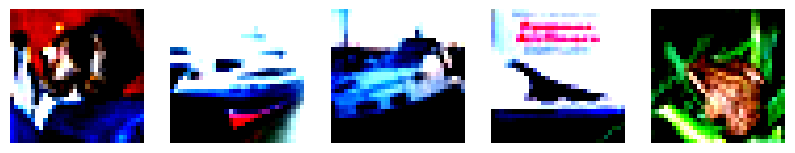

In [66]:
import matplotlib.pyplot as plt

# Define a function to display images
def show_images(images, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].axis('off')
    plt.show()

# Display some of the perturbed images
show_images(fgsm_x[:5])  # Display the first 5 perturbed images

In [53]:
all_predictions = np.concatenate(fgsm_preds, axis=0).reshape(-1, 30)

# Now all_predictions should have shape (10000, 30)
print(all_predictions.shape)

(100, 30)


Examples for Epsilon: 0.5
tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(32, 32, 3), dtype=float32)


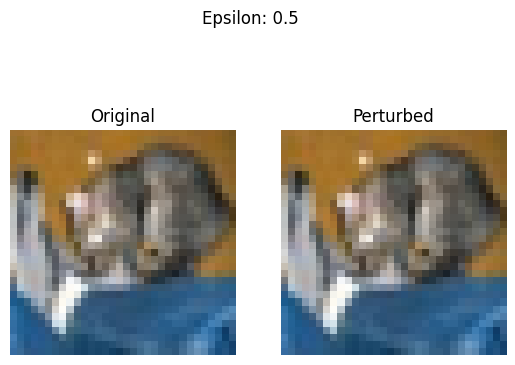

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(32, 32, 3), dtype=float32)


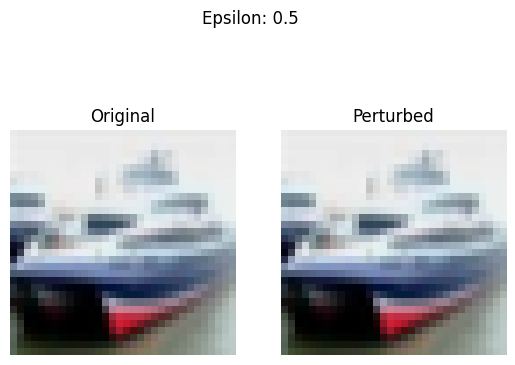

tf.Tensor(
[[[ 8.1293838e-06 -2.8783502e-06 -1.1984319e-05]
  [ 7.3597386e-07 -2.7260032e-06 -4.3976565e-06]
  [-1.0673782e-06 -4.0030386e-06 -1.0355669e-05]
  ...
  [-1.3039660e-05 -2.3778171e-05 -2.2603042e-05]
  [ 2.3375527e-05  2.1083659e-05  1.4906913e-05]
  [-2.1845919e-06 -6.5353811e-07  7.4030865e-08]]

 [[ 2.9397381e-06 -7.5230241e-06 -8.2901161e-06]
  [ 7.3397541e-06 -2.0993375e-06 -6.6980870e-06]
  [ 2.9965347e-06 -8.9060183e-07 -6.7923620e-06]
  ...
  [-1.2645702e-05 -1.1823026e-05 -7.5968014e-06]
  [ 5.2313094e-06  5.9433460e-06  5.3505460e-06]
  [-7.0544161e-06 -8.0928548e-06 -6.3157449e-06]]

 [[ 5.4852562e-06  1.7259365e-06  1.2252999e-06]
  [-2.7122187e-06 -6.7854221e-06 -2.9486309e-06]
  [-8.4082549e-06 -6.0429325e-06 -1.5428554e-05]
  ...
  [ 1.3104426e-05  6.3193811e-06  2.5442673e-06]
  [ 6.7005958e-06  6.8691206e-06  4.8024153e-06]
  [-2.5319000e-07 -6.1731970e-07 -7.4147107e-07]]

 ...

 [[ 2.8620087e-05  8.1721925e-07  1.3374281e-06]
  [ 8.2928573e-06 -3.2411997

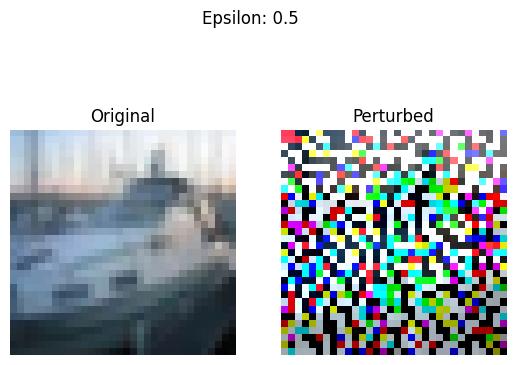

tf.Tensor(
[[[-1.50072765e-07 -1.42610634e-06 -1.51762310e-06]
  [ 7.34209891e-07  1.37624113e-06  1.06348318e-06]
  [-5.39377027e-07 -4.98431064e-07 -4.28921311e-07]
  ...
  [ 2.46180178e-07  1.39517795e-07  1.13762404e-07]
  [ 3.02771745e-08 -1.89960815e-07 -2.79907454e-07]
  [-9.56492414e-08 -1.34888339e-07 -1.10209427e-07]]

 [[ 3.59180319e-07  1.63276326e-07 -3.39383291e-07]
  [-2.68425339e-07  6.00139458e-07  7.35493131e-07]
  [-8.76033965e-08 -2.94840333e-07 -8.90421688e-07]
  ...
  [-7.53271436e-08 -2.44853936e-07 -2.10729674e-08]
  [ 1.62913864e-07  2.80842102e-07  2.63768328e-07]
  [ 9.44305327e-08  1.32235826e-07  7.20962063e-08]]

 [[ 5.43408078e-07  9.91909246e-07  9.88401553e-07]
  [-3.50301860e-07  2.79124805e-07  2.88978072e-07]
  [-4.96927669e-07 -1.13800877e-06 -1.13992076e-06]
  ...
  [-1.09976448e-07  7.67937607e-08 -4.54651143e-08]
  [-1.18167080e-07 -3.11224909e-07 -2.31443153e-07]
  [-3.61427546e-08  4.76882249e-08  1.56642006e-08]]

 ...

 [[-4.13632250e-07 -1.3

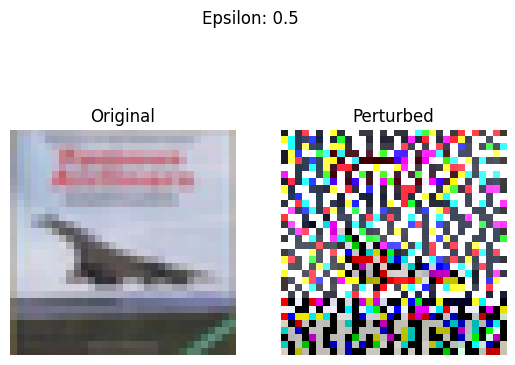

Examples for Epsilon: 0.005
tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(32, 32, 3), dtype=float32)


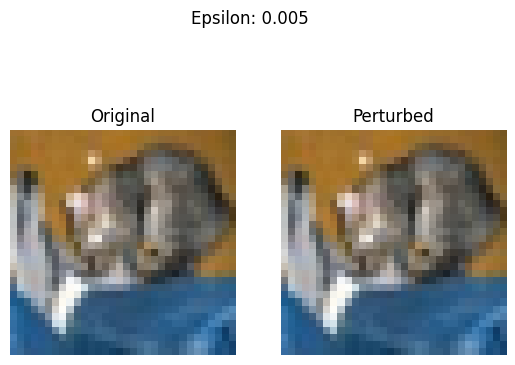

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(32, 32, 3), dtype=float32)


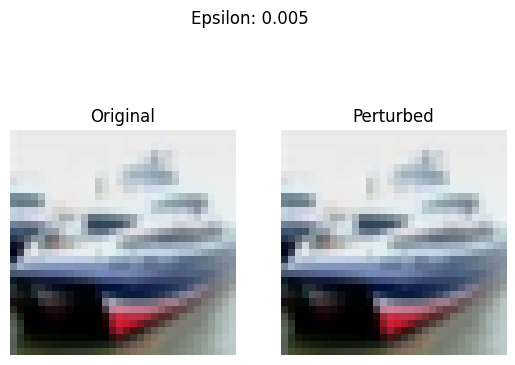

tf.Tensor(
[[[ 8.1293838e-06 -2.8783506e-06 -1.1984319e-05]
  [ 7.3597380e-07 -2.7260032e-06 -4.3976565e-06]
  [-1.0673782e-06 -4.0030391e-06 -1.0355669e-05]
  ...
  [-1.3039659e-05 -2.3778173e-05 -2.2603042e-05]
  [ 2.3375525e-05  2.1083661e-05  1.4906913e-05]
  [-2.1845913e-06 -6.5353811e-07  7.4030901e-08]]

 [[ 2.9397377e-06 -7.5230241e-06 -8.2901179e-06]
  [ 7.3397541e-06 -2.0993373e-06 -6.6980879e-06]
  [ 2.9965345e-06 -8.9060171e-07 -6.7923625e-06]
  ...
  [-1.2645701e-05 -1.1823027e-05 -7.5968010e-06]
  [ 5.2313089e-06  5.9433446e-06  5.3505464e-06]
  [-7.0544165e-06 -8.0928567e-06 -6.3157449e-06]]

 [[ 5.4852562e-06  1.7259365e-06  1.2252999e-06]
  [-2.7122187e-06 -6.7854221e-06 -2.9486309e-06]
  [-8.4082549e-06 -6.0429325e-06 -1.5428554e-05]
  ...
  [ 1.3104426e-05  6.3193802e-06  2.5442673e-06]
  [ 6.7005963e-06  6.8691211e-06  4.8024153e-06]
  [-2.5319000e-07 -6.1731970e-07 -7.4147090e-07]]

 ...

 [[ 2.8620090e-05  8.1721964e-07  1.3374282e-06]
  [ 8.2928564e-06 -3.2412001

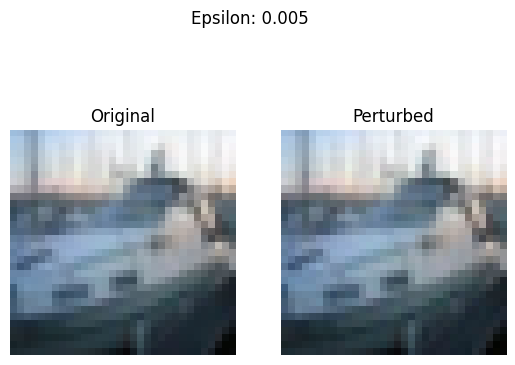

tf.Tensor(
[[[-1.50072765e-07 -1.42610645e-06 -1.51762310e-06]
  [ 7.34209948e-07  1.37624124e-06  1.06348318e-06]
  [-5.39377083e-07 -4.98431064e-07 -4.28921311e-07]
  ...
  [ 2.46180207e-07  1.39517780e-07  1.13762404e-07]
  [ 3.02771710e-08 -1.89960758e-07 -2.79907397e-07]
  [-9.56492485e-08 -1.34888339e-07 -1.10209427e-07]]

 [[ 3.59180433e-07  1.63276340e-07 -3.39383291e-07]
  [-2.68425367e-07  6.00139401e-07  7.35493131e-07]
  [-8.76034107e-08 -2.94840305e-07 -8.90421575e-07]
  ...
  [-7.53271507e-08 -2.44853936e-07 -2.10729709e-08]
  [ 1.62913878e-07  2.80842045e-07  2.63768271e-07]
  [ 9.44305256e-08  1.32235812e-07  7.20962063e-08]]

 [[ 5.43408248e-07  9.91909360e-07  9.88401553e-07]
  [-3.50301860e-07  2.79124833e-07  2.88978100e-07]
  [-4.96927669e-07 -1.13800866e-06 -1.13992076e-06]
  ...
  [-1.09976448e-07  7.67937607e-08 -4.54651143e-08]
  [-1.18167094e-07 -3.11224909e-07 -2.31443138e-07]
  [-3.61427510e-08  4.76882249e-08  1.56642006e-08]]

 ...

 [[-4.13632307e-07 -1.3

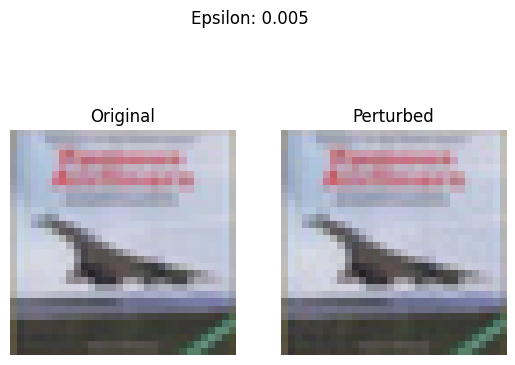

Examples for Epsilon: 0.01
tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(32, 32, 3), dtype=float32)


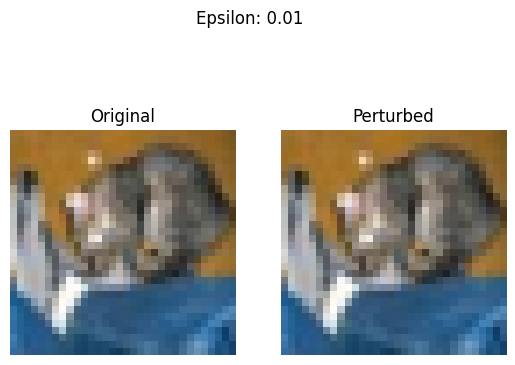

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(32, 32, 3), dtype=float32)


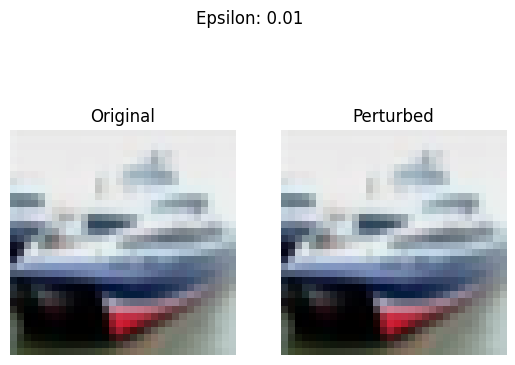

tf.Tensor(
[[[ 8.12938379e-06 -2.87835064e-06 -1.19843189e-05]
  [ 7.35973856e-07 -2.72600278e-06 -4.39765654e-06]
  [-1.06737832e-06 -4.00303907e-06 -1.03556686e-05]
  ...
  [-1.30396602e-05 -2.37781733e-05 -2.26030461e-05]
  [ 2.33755254e-05  2.10836588e-05  1.49069128e-05]
  [-2.18459127e-06 -6.53538109e-07  7.40309005e-08]]

 [[ 2.93973767e-06 -7.52302412e-06 -8.29011606e-06]
  [ 7.33975503e-06 -2.09933751e-06 -6.69808696e-06]
  [ 2.99653448e-06 -8.90601655e-07 -6.79236155e-06]
  ...
  [-1.26456998e-05 -1.18230264e-05 -7.59680051e-06]
  [ 5.23130802e-06  5.94334506e-06  5.35054551e-06]
  [-7.05441607e-06 -8.09285666e-06 -6.31574494e-06]]

 [[ 5.48525577e-06  1.72593661e-06  1.22529991e-06]
  [-2.71221870e-06 -6.78542165e-06 -2.94863071e-06]
  [-8.40825396e-06 -6.04293291e-06 -1.54285517e-05]
  ...
  [ 1.31044244e-05  6.31938065e-06  2.54426732e-06]
  [ 6.70059626e-06  6.86912153e-06  4.80241533e-06]
  [-2.53189938e-07 -6.17319756e-07 -7.41471069e-07]]

 ...

 [[ 2.86200884e-05  8.1

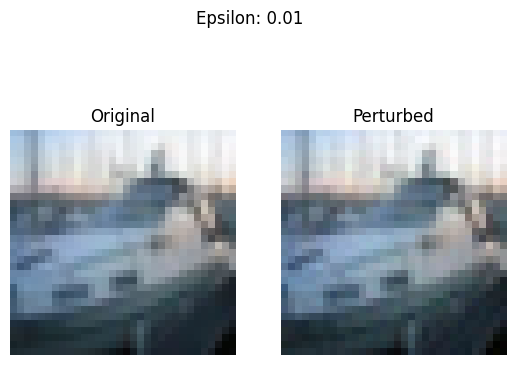

tf.Tensor(
[[[-1.50072751e-07 -1.42610645e-06 -1.51762322e-06]
  [ 7.34209891e-07  1.37624124e-06  1.06348307e-06]
  [-5.39377083e-07 -4.98431064e-07 -4.28921339e-07]
  ...
  [ 2.46180235e-07  1.39517809e-07  1.13762397e-07]
  [ 3.02771674e-08 -1.89960801e-07 -2.79907425e-07]
  [-9.56492414e-08 -1.34888325e-07 -1.10209434e-07]]

 [[ 3.59180319e-07  1.63276326e-07 -3.39383291e-07]
  [-2.68425367e-07  6.00139401e-07  7.35493131e-07]
  [-8.76034036e-08 -2.94840305e-07 -8.90421575e-07]
  ...
  [-7.53271436e-08 -2.44853936e-07 -2.10729674e-08]
  [ 1.62913864e-07  2.80842073e-07  2.63768271e-07]
  [ 9.44305327e-08  1.32235840e-07  7.20962063e-08]]

 [[ 5.43408078e-07  9.91909360e-07  9.88401666e-07]
  [-3.50301832e-07  2.79124862e-07  2.88978043e-07]
  [-4.96927782e-07 -1.13800877e-06 -1.13992076e-06]
  ...
  [-1.09976433e-07  7.67937749e-08 -4.54651072e-08]
  [-1.18167080e-07 -3.11224909e-07 -2.31443153e-07]
  [-3.61427546e-08  4.76882249e-08  1.56642006e-08]]

 ...

 [[-4.13632250e-07 -1.3

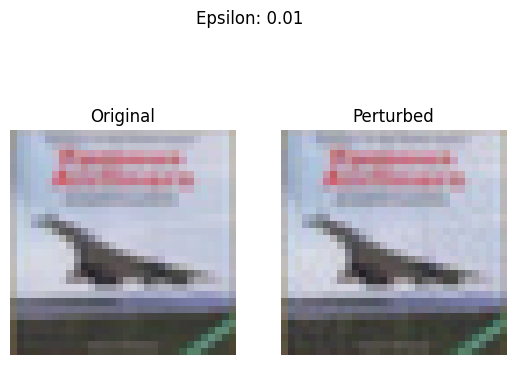

In [107]:
for i, epsilon_examples in enumerate(examples):
    epsilon = epsilons[i]
    print(f"Examples for Epsilon: {epsilon}")
    for j, example in enumerate(epsilon_examples):
        if j >= 4:
            break
        original_image, original_label, perturbed_data, perturbed_label, epsilon_value, sign = example
        # Select the first image from the batch for visualization
        original_image = original_image[0]
        perturbed_data = perturbed_data[0]
        print(sign[0])
        # Plot original and perturbed images
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(denormalize_image(original_image, mean, std), cmap='gray')
        
        # plt.imshow(original_image, cmap='gray')
        plt.title(f'Original')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(denormalize_image(perturbed_data, mean, std), cmap='gray')
        # plt.imshow(perturbed_data, cmap='gray')
        plt.title(f'Perturbed')
        plt.axis('off')
        # Print epsilon value on top of plot
        plt.suptitle(f'Epsilon: {epsilon_value}')
        plt.show()

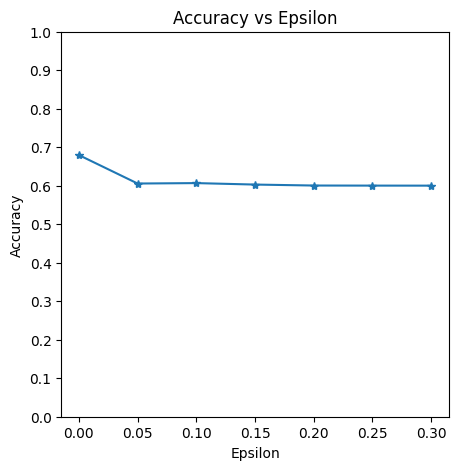

In [87]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# font = {'family': 'sans-serif', 'weight': 'normal', 'size': 10}
# plt.rc('font', **font)

# plt.figure(figsize=(15, 2)) 
# sns.lineplot(final_bet_p_indices[:100], color='blue', label='Predicted', linewidth=0.7)
# sns.lineplot(y_test[:100], color='red', linestyle='dashed', label='True', linewidth=0.7)

# # Add labels and title
# plt.xlabel('Number of samples', fontdict=font)
# plt.ylabel('Class Value', fontdict=font)
# plt.title('Predicted BetP vs. True Values', fontdict=font)

# # Add a legend
# plt.legend()

# # Show the plot
# plt.show()

In [ ]:
def calculate_plausibility(A, bel):
    plausibility = 0

    plaus = []
    for i, A in enumerate(new_classes):
        for j, B in enumerate(new_classes):
            if set(B).intersection(set(A)):
                plausibility += bel[j]
        
        plaus.append(plausibility)

    return np.array(plaus)

pla = []
for k in range(test_preds.shape[0]):
    pla.append(calculate_plausibility(new_classes, test_preds_mass[k]))

pl = np.array(pla)
pl[pl < 0] = 0

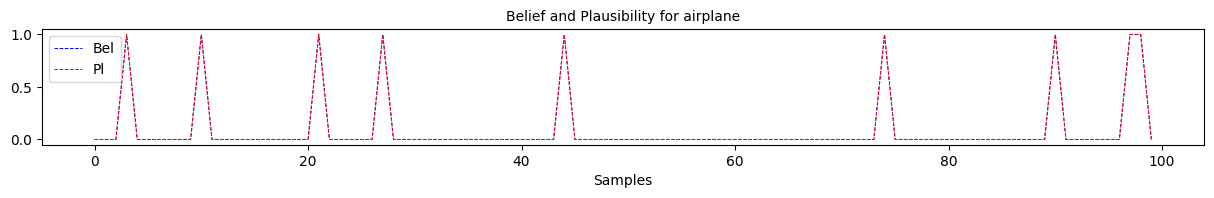

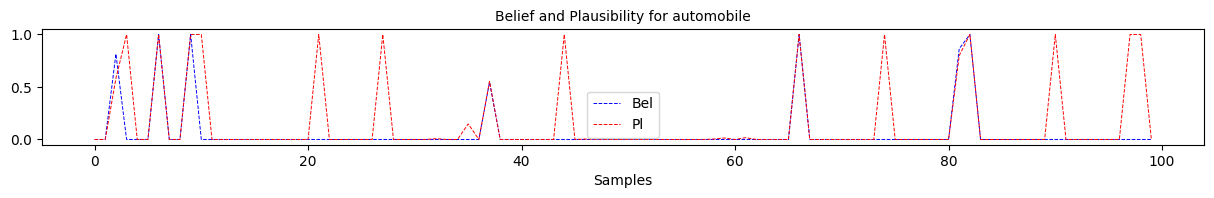

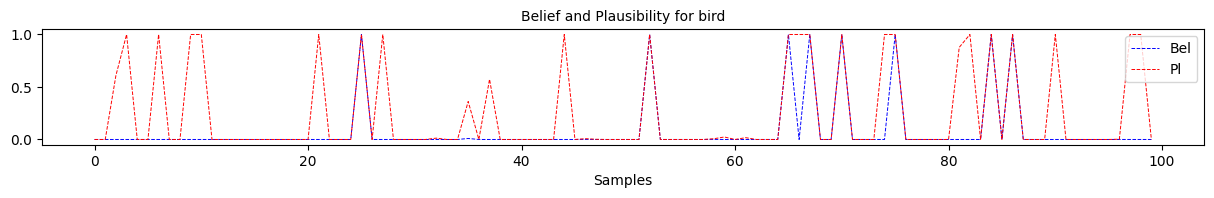

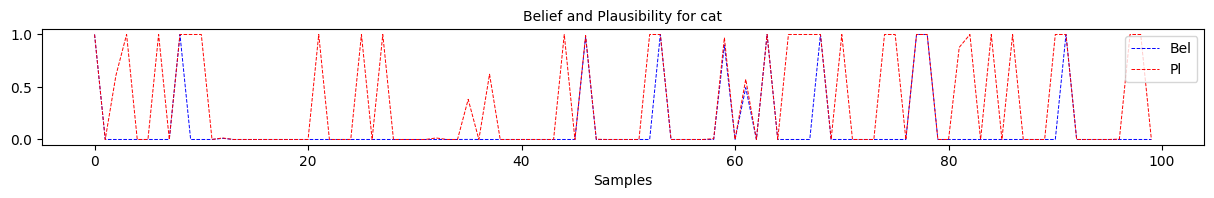

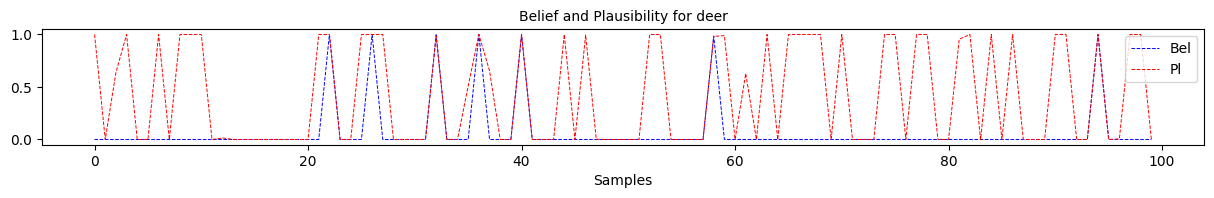

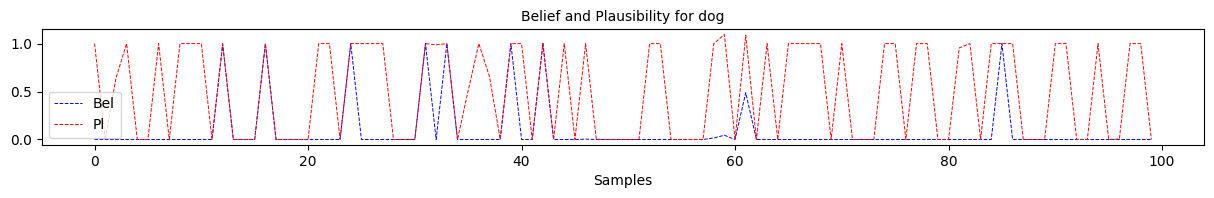

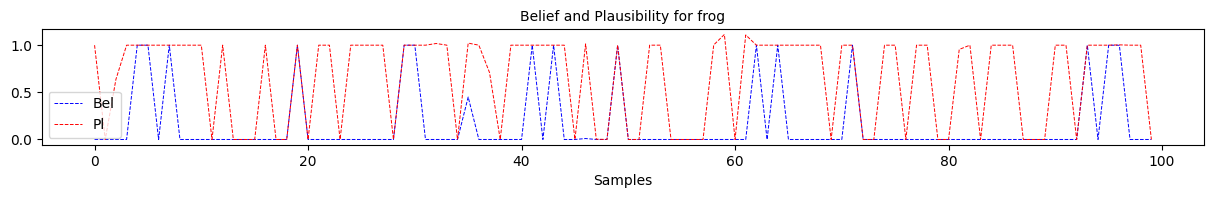

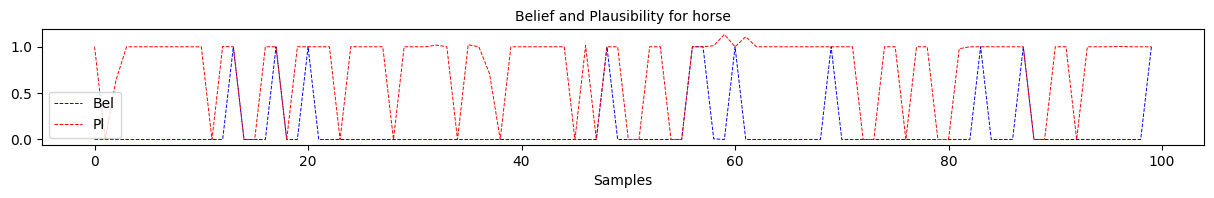

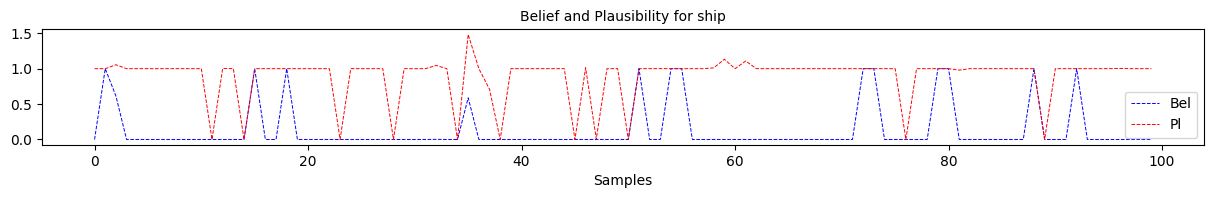

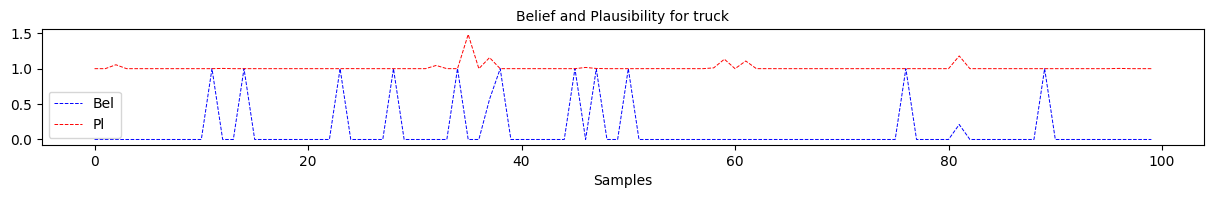

In [ ]:
font = {'family': 'sans-serif', 'weight': 'normal', 'size': 10}
plt.rc('font', **font)

# Plot the line graphs for each subset
for i, subset in enumerate(classes):
    plt.figure(figsize=(15, 1.5)) 
    sns.lineplot(test_preds[:100, i], color='blue', linestyle='dashed', label='Bel', linewidth=0.7)
    #sns.lineplot(final_bet_p[:100, i], color='green', label='BetP', linewidth=0.7)
    sns.lineplot(pl[:100, i], color='red', linestyle='dashed', label='Pl', linewidth=0.7)
    plt.xlabel('Samples', fontdict=font)
    #plt.ylabel('Value')
    plt.title(f'Belief and Plausibility for {subset}', fontdict=font)
    plt.legend()
    plt.show()

/tmp/ipykernel_3221508/1654376233.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(incorrect_probs, color='red', label='Incorrectly Classified', kde=True, bins=20)
/tmp/ipykernel_3221508/1654376233.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(correct_probs, color='blue', label='Corre

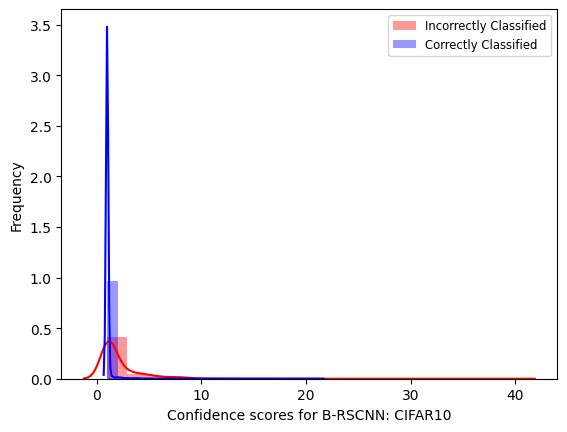

In [32]:
# Find the indices of incorrectly classified samples
incorrect_idx = np.nonzero(final_bet_p_indices != y_test)[0]

# Filter out the confidence scores for the incorrectly classified samples
incorrect_probs = np.max(final_bet_p[incorrect_idx], axis=1)

# Find the indices of incorrectly classified samples
correct_idx = np.nonzero(final_bet_p_indices == y_test)[0]

# Filter out the confidence scores for the incorrectly classified samples
correct_probs = np.max(final_bet_p[correct_idx], axis=1)

# Plot the histogram of confidence scores
# plt.hist(incorrect_probs, bins=10)
sns.distplot(incorrect_probs, color='red', label='Incorrectly Classified', kde=True, bins=20)
sns.distplot(correct_probs, color='blue', label='Correctly Classified', kde=True, bins=20)
#plt.title('Confidence Scores for Incorrectly Classified Samples')
legend = plt.legend(fontsize='small')
plt.xlabel('Confidence scores for B-RSCNN: CIFAR10')
#plt.ylim(0,6)
plt.ylabel('Frequency')
plt.savefig("Confidence_Brscnn_k100.pdf", format="pdf", bbox_inches="tight")

plt.show()


79/79 [==============================] - 11s 120ms/step


/tmp/ipykernel_53783/1139665736.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(incorrect_probs_cnn, color='red', label='Incorrectly Classified', kde=True)
/tmp/ipykernel_53783/1139665736.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(correct_probs_cnn, color='blue', label='Correctly 

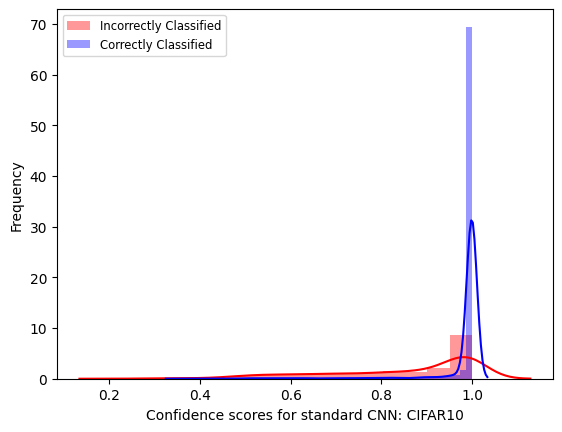

In [ ]:
test_preds_org = model.predict(x_test, verbose=1, batch_size=batch_size)

# Find the indices of incorrectly classified samples
correct_idx_cnn = np.nonzero(np.argmax(test_preds_org, axis=-1) == y_test)[0]

# Filter out the confidence scores for the incorrectly classified samples
correct_probs_cnn = np.max(test_preds_org[correct_idx_cnn], axis=1)

# Find the indices of incorrectly classified samples
incorrect_idx_cnn = np.nonzero(np.argmax(test_preds_org, axis=-1) != y_test)[0]

# Filter out the confidence scores for the incorrectly classified samples
incorrect_probs_cnn = np.max(test_preds_org[incorrect_idx_cnn], axis=1)

# Plot the histogram of confidence scores
# plt.hist(incorrect_probs, bins=10)
sns.distplot(incorrect_probs_cnn, color='red', label='Incorrectly Classified', kde=True)
sns.distplot(correct_probs_cnn, color='blue', label='Correctly Classified', kde=True)
legend = plt.legend(fontsize='small')
plt.xlabel('Confidence scores for standard CNN: CIFAR10')
#plt.ylim(0,6)
plt.ylabel('Frequency')
#plt.savefig("Confidence_cnn_cifar10.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [ ]:
correct_idx_lbbnn = np.nonzero(np.argmax(test_preds_cifar10_lbbnn, axis=-1) == y_test)[0]
correct_probs_lbbnn = np.max(test_preds_cifar10_lbbnn[correct_idx_lbbnn], axis=1)
incorrect_idx_lbbnn = np.nonzero(np.argmax(test_preds_cifar10_lbbnn, axis=-1) != y_test)[0]
incorrect_probs_lbbnn = np.max(test_preds_cifar10_lbbnn[incorrect_idx_lbbnn], axis=1)
correct_idx_enn = np.nonzero(np.argmax(test_preds_cifar10_enn, axis=-1) == y_test)[0]
correct_probs_enn = np.max(test_preds_cifar10_enn[correct_idx_enn], axis=1)
incorrect_idx_enn = np.nonzero(np.argmax(test_preds_cifar10_enn, axis=-1) != y_test)[0]
incorrect_probs_enn = np.max(test_preds_cifar10_enn[incorrect_idx_enn], axis=1)

/tmp/ipykernel_53783/3659153261.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(incorrect_probs, color='blue', label='Incorrectly Classified', kde=True)
/tmp/ipykernel_53783/3659153261.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(incorrect_probs_cnn, color='red', label='Incorrectly 

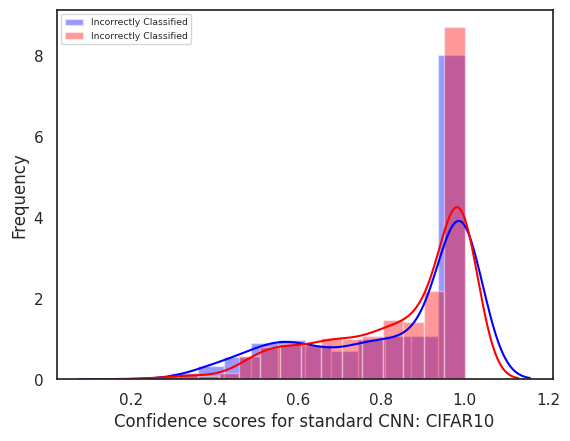

In [ ]:
# test_preds_org = model.predict(x_test, verbose=1, batch_size=batch_size)

# # Find the indices of incorrectly classified samples
# correct_idx_cnn = np.nonzero(np.argmax(test_preds_org, axis=-1) == y_test)[0]

# # Filter out the confidence scores for the incorrectly classified samples
# correct_probs_cnn = np.max(test_preds_org[correct_idx_cnn], axis=1)

# # Find the indices of incorrectly classified samples
# incorrect_idx_cnn = np.nonzero(np.argmax(test_preds_org, axis=-1) != y_test)[0]

# # Filter out the confidence scores for the incorrectly classified samples
# incorrect_probs_cnn = np.max(test_preds_org[incorrect_idx_cnn], axis=1)

# Plot the histogram of confidence scores
# plt.hist(incorrect_probs, bins=10)
sns.distplot(incorrect_probs, color='blue', label='Incorrectly Classified', kde=True)
sns.distplot(incorrect_probs_cnn, color='red', label='Incorrectly Classified', kde=True)
# sns.distplot(incorrect_probs_lbbnn, color='orange', label='Incorrectly Classified', kde=True)
# sns.distplot(incorrect_probs_enn, color='green', label='Incorrectly Classified', kde=True)
# sns.distplot(correct_probs_cnn, color='blue', label='Correctly Classified', kde=True)
legend = plt.legend(fontsize='small')
plt.xlabel('Confidence scores for standard CNN: CIFAR10')
#plt.ylim(0,6)
plt.ylabel('Frequency')
#plt.savefig("Confidence_cnn_cifar10.pdf", format="pdf", bbox_inches="tight")

plt.show()

## SPECIFICITY (Pal)

In [ ]:
def specific(test_preds_mass, new_classes):
    specif = []
    for i in range(len(test_preds_mass)):
        spec = 0
        for j,A in enumerate(new_classes):
                spec += test_preds_mass[i][j] / len(A)
        specif.append(spec)
    return specif

specificity = np.array(specific(test_preds_mass, new_classes_with_full))
specificity.shape, specificity

((10000,),
 array([1.        , 1.        , 0.98160256, ..., 1.        , 1.        ,
        1.        ]))

In [ ]:
len(incorrect_idx)

700

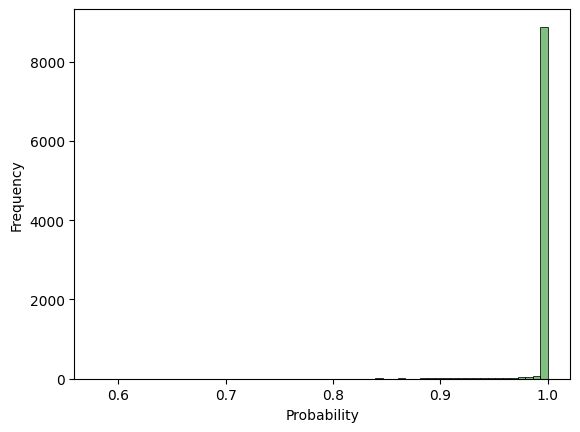

In [ ]:
sns.histplot(specificity[correct_idx], color='green', label='Correctly Classified', bins=60, alpha=0.5)
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

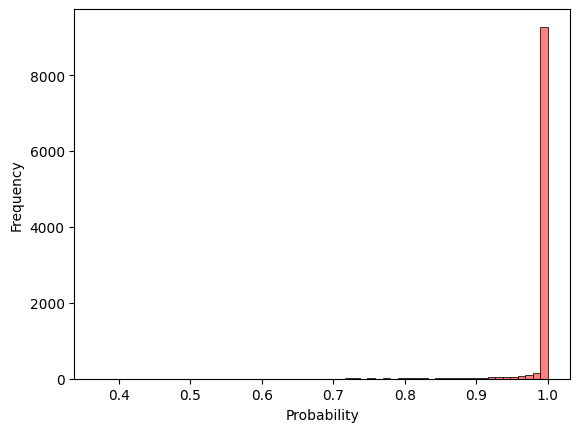

In [ ]:
sns.histplot(specificity, color='red', label='Incorrectly Classified', bins=60, alpha=0.5)
#plt.title('Specificity')
#plt.ylim(0,500)
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

In [ ]:
mass_cardinality_greater = []
indices_top_card = []

for i in range(len(test_preds_mass)):
    top_labels_mass = np.argsort(test_preds_mass[i])[::-1][:70]
    #t = top_labels_mass[0] 
    check = False
    for t in top_labels_mass:
        if len(new_classes_with_full[t]) == 0:
            check = True
            break
    if not check:
        mass_card = test_preds_mass[i]
        mass_cardinality_greater.append(mass_card)
        indices_top_card.append((i, top_labels_mass[0], len(new_classes_with_full[top_labels_mass[0]]), new_classes_with_full[top_labels_mass[0]]))

mass_cardinality_greater = np.array(mass_cardinality_greater)
indices_top_card = np.array(indices_top_card)

In [ ]:
indices_top_card

array([[0, 3, 1, {'cat'}],
       [1, 8, 1, {'ship'}],
       [2, 1, 1, {'automobile'}],
       ...,
       [9997, 5, 1, {'dog'}],
       [9998, 1, 1, {'automobile'}],
       [9999, 7, 1, {'horse'}]], dtype=object)

In [ ]:
unique_numbers = np.unique(indices_top_card[:, 2])
selected_samples = []

# Randomly select one sample for each unique number
for num in unique_numbers:
    indices = np.where(indices_top_card[:, 2] == num)[0]
    selected_sample = np.random.choice(indices)
    selected_samples.append(selected_sample)

# Randomly select additional samples until the total count reaches 100
remaining_samples = 100 - len(selected_samples)
if remaining_samples > 0:
    all_indices = np.arange(len(indices_top_card))
    remaining_sample_indices = np.setdiff1d(all_indices, selected_samples)
    additional_samples = np.random.choice(remaining_sample_indices, remaining_samples, replace=False)
    selected_samples.extend(additional_samples)

selected_samples = np.array(selected_samples)
selected_data = indices_top_card[selected_samples]

In [ ]:
selected_data[:,0]

array([1640, 1538, 4442, 8305, 6264, 2289, 6139, 8445, 4028, 2960, 4048,
       7920, 1992, 3971, 1596, 2031, 1894, 1517, 9023, 3532, 5025, 1169,
       4856, 5661, 9976, 5613, 1022, 6411, 2724, 744, 9564, 8489, 2842,
       3774, 1628, 6244, 9779, 7, 1971, 1105, 678, 4563, 2252, 4346, 7422,
       3424, 4730, 1773, 8174, 5856, 7306, 6221, 2916, 1837, 1256, 420,
       5297, 1084, 174, 5816, 8470, 6550, 5179, 6226, 2739, 4809, 3232,
       9877, 9, 1396, 2768, 1402, 1641, 4957, 4043, 5327, 5360, 8039,
       2736, 6328, 5714, 3529, 9957, 7032, 3265, 3103, 5250, 236, 7450,
       2390, 5542, 3128, 830, 410, 1277, 2952, 862, 6630, 3211, 9437],
      dtype=object)

In [ ]:
np.unique(indices_top_card[:,2])

array([1, 2, 10], dtype=object)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


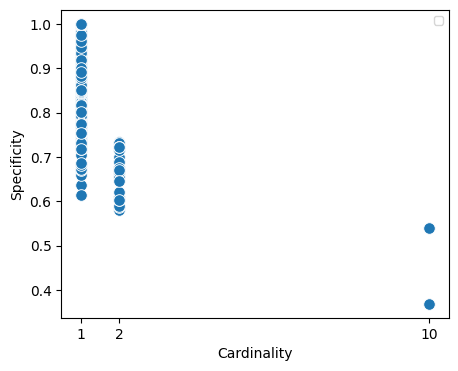

In [ ]:
plt.figure(figsize=(5,4))
sns.scatterplot(x=indices_top_card[:,2], y=specificity[indices_top_card[:,0].astype(int)], s=70)
plt.xlabel('Cardinality')
plt.xticks(np.unique(indices_top_card[:,2]).astype(int))
plt.xlim(0.5, np.max(indices_top_card[:,2])+0.5)
plt.ylabel('Specificity')
#plt.title('Specificity vs Cardinality')
legend = plt.legend(fontsize='small')
#plt.ylim(0,6)
plt.savefig("spec_card_cifar10.pdf", format="pdf", bbox_inches="tight")
plt.show()

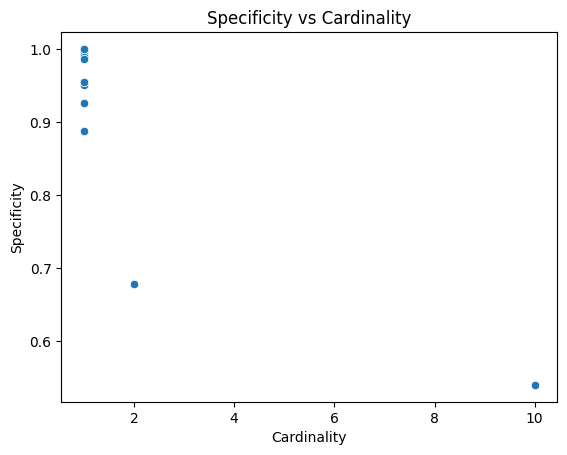

In [ ]:
sample_index = selected_data[:,0].astype(int)
sns.scatterplot(x=selected_data[:,2], y=specificity[sample_index])
plt.xlabel('Cardinality')
plt.ylabel('Specificity')
plt.title('Specificity vs Cardinality')
plt.show()

## NON-SPECIFICITY (Klir, Dubois, Prade)

In [ ]:
def non_specificity_Klir(test_preds_mass, new_classes):
    non_specif = []
    for i in range(len(test_preds_mass)):
        non_spec = 0
        for j,A in enumerate(new_classes):
                non_spec += test_preds_mass[i][j] * np.log(len(A))
        non_specif.append(non_spec)
    return non_specif

non_specificity_Klir = np.array(non_specificity_Klir(test_preds_mass, new_classes))
non_specificity_Klir.shape, non_specificity_Klir

((10000,),
 array([4.71031837e-13, 1.31236108e-20, 3.03174802e-02, ...,
        1.04846824e-16, 1.64550144e-17, 2.82695844e-15]))

In [ ]:
# sns.displot(non_specificity_Klir[correct_idx]).set(title='Non-Specificity(Klir) for Correctly classified samples')

In [ ]:
# sns.displot(non_specificity_Klir[incorrect_idx]).set(title='Non-Specificity(Klir) for Inorrectly classified samples')

In [ ]:
# font = {'family': 'sans-serif', 'weight': 'normal', 'size': 10}
# plt.rc('font', **font)

# plt.figure(figsize=(15, 2)) 
# sns.lineplot(np.max(final_bet_p[:100], axis = -1), color='blue', label='BetP', linewidth=0.7)
# sns.lineplot(non_specificity[:100], color='red', label='Non-Spec Pal', linewidth=0.7)
# sns.lineplot(non_specificity_Klir[:100], color='green', label='Non-Spec Klir', linewidth=0.7)


# # Add labels and title
# plt.xlabel('Number of samples', fontdict=font)
# #plt.ylabel('Class Value', fontdict=font)
# plt.title('Predicted BetP vs. Non-Specificity', fontdict=font)

# # Add a legend
# plt.legend()

# # Show the plot
# plt.show()

## CREDAL SET VERTICES

In [76]:
import itertools
from tqdm import tqdm

def compute_vertices(mass, classes, class_index):
    vertices = []
    # permutations_iter = itertools.permutations(classes)
    num_permutations = 0
    # subset_permutations = list(itertools.islice(permutations_iter, num_permutations))
      
    
    subset_permutations = []
    class_indexes = np.arange(len(classes))
    classes_array = np.array(classes)
    for _ in range(num_permutations):
      np.random.shuffle(class_indexes)
      subset_permutations.append(list(classes_array[class_indexes]))
    
    for i,c in enumerate(classes):
      p_0 = classes.copy()
      p_0[0], p_0[i] = p_0[i], p_0[0]
      
      p_1 = classes.copy()
      p_1[-1], p_1[i] = p_1[i], p_1[-1]
      
      subset_permutations = [p_0] + [p_1] + subset_permutations
    
    for perm in subset_permutations:
        # print(perm)
        p = 0
        #print(perm)
        # for i,curr_elem in enumerate(perm):
        i, curr_elem = perm.index(classes[class_index]), classes[class_index]
        # print(curr_elem)
        # curr_elem = i
        # print("current", curr_elem)
        for c in new_classes_with_full:
          if curr_elem in c:
            for k in range(i):
              if perm[k] in c:
                break
            else:
              # print(c)
              p += mass[new_classes_with_full.index(c)]
        # print(p)
        vertices.append(p)
           
    return np.array(vertices)

In [39]:
test_preds_mass.shape

(10000, 1023)

In [91]:
new_classes_with_full = list(new_classes_with_full)


In [90]:
new_classes = list(new_classes)

In [77]:
vertices_list = []
for k in range(len(x_test)): 
  # print(y_test[k])
  vertices_list.append(compute_vertices(test_preds_mass[k], classes, final_bet_p_indices[k]))
vertices_list = np.array(vertices_list)

In [39]:
vertices_list.shape

(10000, 20)

In [ ]:
final_bet_p_correct = final_bet_p[correct_idx]
final_bet_p_incorrect = final_bet_p[incorrect_idx]

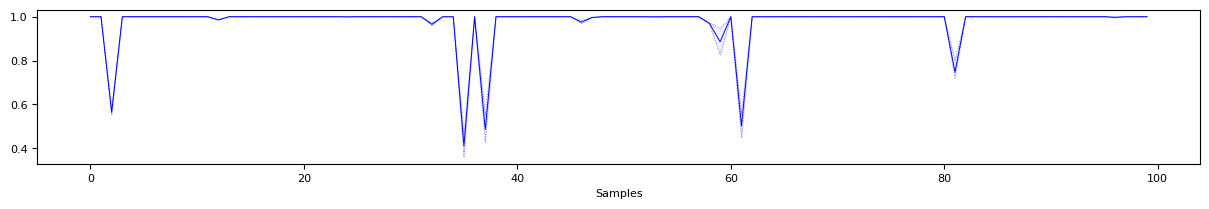

In [ ]:
#os.makedirs("credal_plots_shaded_new/", exist_ok=True)

fig, ax = plt.subplots(figsize=(15, 2)) 
font = {'family': 'sans-serif', 'weight': 'normal', 'size': 8}
plt.rc('font', **font)
    
    
for i in range(0, 100, 100):   
    if i in correct_idx:
        color = 'blue'
        label_suffix = ' (Correct)'
    elif i in incorrect_idx:
        color = 'red'
        label_suffix = ' (Incorrect)'
    else:
        continue
    
    ax.plot(np.max(vertices_list[i:i+100], axis=-1), color=color, label=f'Max P{label_suffix}', linewidth=0.7, linestyle="dotted", alpha=0.5)
    ax.plot(np.max(final_bet_p[i:i+100], axis=-1), color=color, label=f'BetP{label_suffix}', linewidth=0.7)
    ax.plot(np.min(vertices_list[i:i+100], axis=-1), color=color, label=f'Min P{label_suffix}', linewidth=0.7, linestyle="dotted", alpha=0.5)
    ax.fill_between(np.arange(100),
                    np.max(vertices_list[i:i+100], axis=-1), np.min(vertices_list[i:i+100], axis=-1), color=color, alpha=.05)

plt.xlabel('Samples', fontdict=font)

# Add legend
#plt.legend()

# Save or show the plot
# plt.savefig(f"credal_plots_shaded_new/credal_plot_combined.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
def vertices(test_preds_mass, classes):
    vertices_p = {}
    for i,c in tqdm(enumerate(classes)):
        vertices_list = []
        for k in range(len(test_preds_mass)): 
            vertices_list.append(compute_vertices(test_preds_mass[k], classes, i))
        vertices_list = np.array(vertices_list)
        vertices_p[c] = vertices_list
    return vertices_list, vertices_p

In [ ]:
vertices_list = []
for k in range(len(test_preds_mass)): 
  # print(y_test[k])
  vertices_list.append(compute_vertices(test_preds_mass[k], classes, final_bet_p_indices[k]))
vertices_list = np.array(vertices_list)

In [51]:
vertices_p_correct = {}
vertices_p_incorrect = {}

for i,c in tqdm(enumerate(classes)):
    vertices_list_correct = []
    for k in (correct_idx): 
        vertices_list_correct.append(compute_vertices(test_preds_mass[k], classes, i))
    vertices_list_correct = np.array(vertices_list_correct)
    vertices_p_correct[c] = vertices_list_correct

for i,c in tqdm(enumerate(classes)):
    vertices_list_incorrect = []
    for k in (incorrect_idx): 
        vertices_list_incorrect.append(compute_vertices(test_preds_mass[k], classes, i))
    vertices_list_incorrect = np.array(vertices_list_incorrect)
    vertices_p_incorrect[c] = vertices_list_incorrect

0it [01:20, ?it/s]


KeyboardInterrupt: 

In [ ]:
max_min_incorrect = {}
for c in vertices_p_incorrect:
    temp = np.max(vertices_p_incorrect[c], axis=-1) - np.min(vertices_p_incorrect[c], axis=-1)
    #max_min[c] = list(np.sort(temp)[::-1][:100]) + list(np.random.choice(np.sort(temp)[::-1][300:500], 10))
    max_min_incorrect[c] = temp

max_min_correct = {}
for c in vertices_p_correct:
    temp = np.max(vertices_p_correct[c], axis=-1) - np.min(vertices_p_correct[c], axis=-1)
    max_min_correct[c] = temp

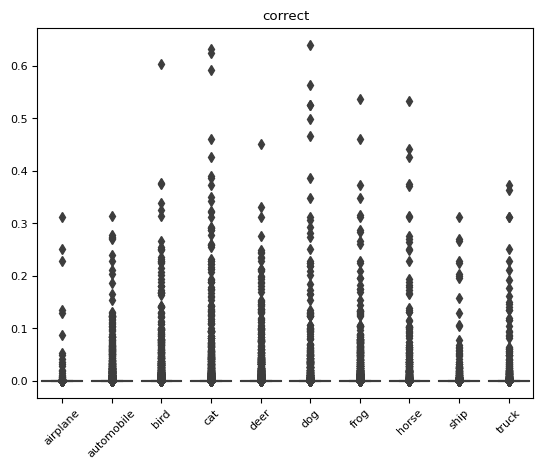

In [ ]:
ax = sns.boxplot(pd.DataFrame(max_min_correct))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title('correct')
plt.savefig("Credal_set_max_min_correct.pdf", format="pdf", bbox_inches="tight")

Text(0.5, 1.0, 'incorrect')

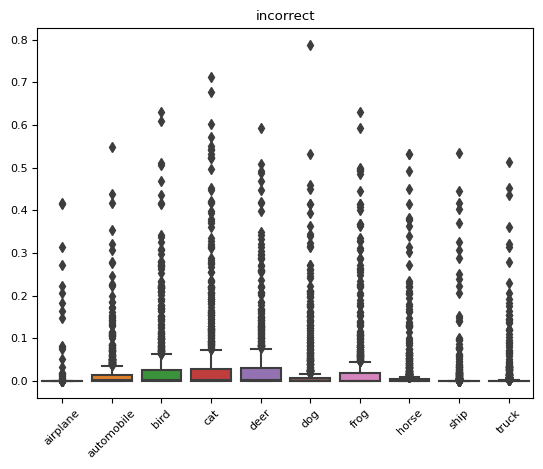

In [ ]:
ax = sns.boxplot(pd.DataFrame(max_min_incorrect))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title('incorrect')
#plt.savefig("Credal_set_max_min_incorrect.pdf", format="pdf", bbox_inches="tight")
#plt.ylim((0,1))

In [ ]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridisBig2 = cm.get_cmap('Oranges_r', 512)
newcmp2 = ListedColormap(viridisBig2(np.linspace(0, 0.25, 256)))

/tmp/ipykernel_53783/644803833.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridisBig2 = cm.get_cmap('Oranges_r', 512)


In [ ]:
viridisBig = cm.get_cmap('viridis', 512)
newcmp = ListedColormap(viridisBig(np.linspace(0.20, 0.45, 256)))

/tmp/ipykernel_53783/1017487931.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridisBig = cm.get_cmap('viridis', 512)


/tmp/ipykernel_61777/2471665532.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(newcmp)
/tmp/ipykernel_61777/2471665532.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(newcmp)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_61777/2471665532.py:31: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to

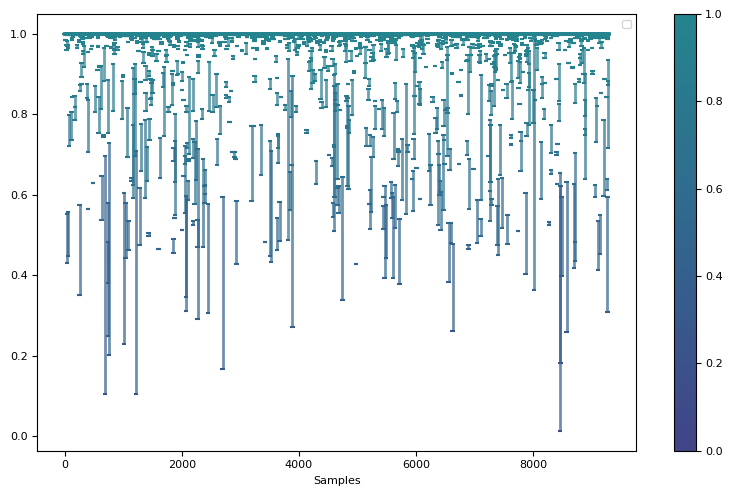

In [ ]:
subset = vertices_list[correct_idx]

max_values = np.max(subset, axis=1)
min_values = np.min(subset, axis=1)
fig, ax = plt.subplots(figsize=(8, 5))

x = np.arange(len(subset))

threshold = 0  # Adjust this threshold value as needed
line_width = 2  # Adjust the line width as desired

for i in range(len(subset)):
    if abs(max_values[i] - min_values[i]) > threshold:
        cmap = plt.cm.get_cmap(newcmp)
        color = cmap((max_values[i] + min_values[i]) / 2)
        ax.vlines(x[i], ymin=min_values[i], ymax=max_values[i], color=color, alpha=0.7, linewidth=line_width)

cmap = plt.cm.get_cmap(newcmp)
max_colors = cmap(max_values)
min_colors = cmap(min_values)
ax.scatter(x, max_values, marker='_', s=10, c=max_colors)
ax.scatter(x, min_values, marker='_', s=10, c=min_colors)

ax.set_xlabel('Samples')
#ax.set_ylabel('Value')
#ax.set_title('Max and Min Values for 100 Samples')
ax.legend()

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([]) 
cbar = plt.colorbar(sm)
#cbar.set_label('Color')

plt.tight_layout()
plt.show()

In [ ]:
np.sum(max_values>0.7)

NameError: name 'max_values' is not defined

In [ ]:
len(vertices_list)

10000

/tmp/ipykernel_53783/3111149279.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = plt.cm.get_cmap(newcmp2)
/tmp/ipykernel_53783/3111149279.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = plt.cm.get_cmap(newcmp2)
/tmp/ipykernel_53783/3111149279.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(newcmp)
/tmp/ipykernel_53783/3111149279.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and w

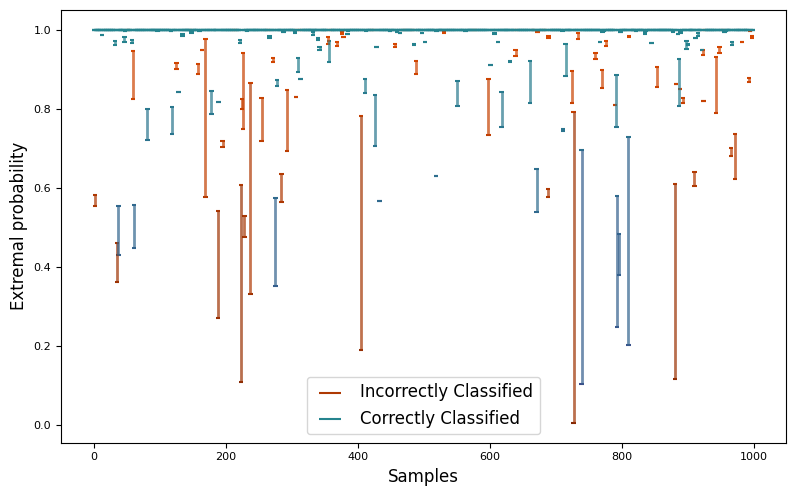

In [ ]:
import matplotlib.pyplot as plt
num_samples_to_disp = 1000

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

subset_incorrent_indices = incorrect_idx[incorrect_idx<num_samples_to_disp]
# Plot another set of max-min intervals with the Inferno colormap
subset2 = vertices_list[subset_incorrent_indices]  # Replace with your data for the second set
max_values2 = np.max(subset2, axis=1)
min_values2 = np.min(subset2, axis=1)

x = np.arange(len(vertices_list))[subset_incorrent_indices]

threshold2 = 0
for i in range(len(subset2)):
    #if abs(max_values2[i] - min_values2[i]) > threshold2:
        cmap2 = plt.cm.get_cmap(newcmp2)
        color2 = cmap2((max_values2[i] + min_values2[i]) / 2)
        ax.vlines(x[i], ymin=min_values2[i], ymax=max_values2[i], color=color2, alpha=0.7, linewidth=line_width)

cmap2 = plt.cm.get_cmap(newcmp2)
max_colors2 = cmap2(max_values2)
min_colors2 = cmap2(min_values2)
# ax.scatter(x[max_values2 - min_values2 > threshold2], max_values2[max_values2 - min_values2 > threshold2],
#            marker='_', s=10, c=max_colors2[max_values2 - min_values2 > threshold2], label='Incorrectly Classified')
# ax.scatter(x[max_values2 - min_values2 > threshold2], min_values2[max_values2 - min_values2 > threshold2],
#            marker='_', s=10, c=min_colors2[max_values2 - min_values2 > threshold2])
ax.scatter(x, max_values2,
           marker='_', s=10, c=max_colors2, label='Incorrectly Classified')
ax.scatter(x, min_values2,
           marker='_', s=10, c=min_colors2)

subset_corrent_indices = correct_idx[correct_idx<num_samples_to_disp]
# Define your data and settings
subset = vertices_list[subset_corrent_indices]
max_values = np.max(subset, axis=1)
min_values = np.min(subset, axis=1)


x = np.arange(len(vertices_list))[subset_corrent_indices]

threshold1 = 0  # Adjust this threshold value as needed
line_width = 2  # Adjust the line width as desired

for i in range(len(subset)):
    # if abs(max_values[i] - min_values[i]) < threshold1:
    cmap = plt.cm.get_cmap(newcmp)
    color = cmap((max_values[i] + min_values[i]) / 2)
    ax.vlines(x[i], ymin=min_values[i], ymax=max_values[i], color=color, alpha=0.7, linewidth=line_width)

cmap = plt.cm.get_cmap(newcmp)
max_colors = cmap(max_values)
min_colors = cmap(min_values)
# ax.scatter(x[max_values - min_values < threshold1], max_values[max_values - min_values < threshold1],
#            marker='_', s=10, c=max_colors[max_values - min_values > threshold1], label='Correctly Classified')
# ax.scatter(x[max_values - min_values < threshold1], min_values[max_values - min_values < threshold1],
#            marker='_', s=10, c=min_colors[max_values - min_values > threshold1])
ax.scatter(x, max_values,
           marker='_', s=10, c=max_colors, label='Correctly Classified')
ax.scatter(x, min_values,
           marker='_', s=10, c=min_colors)



ax.set_xlabel('Samples', fontsize=12)
ax.set_ylabel('Extremal probability', fontsize=12)

ax.legend(prop = { "size": 12}, markerscale=5.0)

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([]) 
#cbar = plt.colorbar(sm)
plt.savefig("credal_set_width.pdf", format="pdf", bbox_inches="tight")
plt.tight_layout()
plt.show()

In [ ]:
# for i in range(0,1000,100):
#     plt.figure(figsize=(15, 2)) 
#     font = {'family': 'sans-serif', 'weight': 'normal', 'size': 10}
#     plt.rc('font', **font)

#     # Plot the line graphs for each subset
#     #plt.figure(figsize=(10, 5)) 
#     sns.lineplot(np.max(vertices_list[i:i+100], axis=-1), color='red', linestyle='dotted', label='Max P', linewidth=0.7)
#     sns.lineplot(np.max(final_bet_p[i:i+100], axis=-1), color='red', label='Bet P', linewidth=0.7)
#     sns.lineplot(np.min(vertices_list[i:i+100], axis=-1), color='red', linestyle='dotted', label='Min P', linewidth=0.7)
#     plt.xlabel('Samples', fontdict=font)
#     #plt.ylabel('Value')
#     # plt.title(f'Belief and Plausibility intervals for {subset}', fontdict=font)
#     plt.legend()
#     # plt.face_color("grey")
#     # plt.grid(color = 'grey', linestyle = '-', linewidth = 0.5)
#     #plt.savefig(f"credal_plots/credal_plot_{i}.pdf", format="pdf", bbox_inches="tight")
#     plt.show()

/tmp/ipykernel_61777/4154629580.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.max(vertices_list, axis=-1) - np.min(vertices_list, axis=-1))


<Axes: ylabel='Density'>

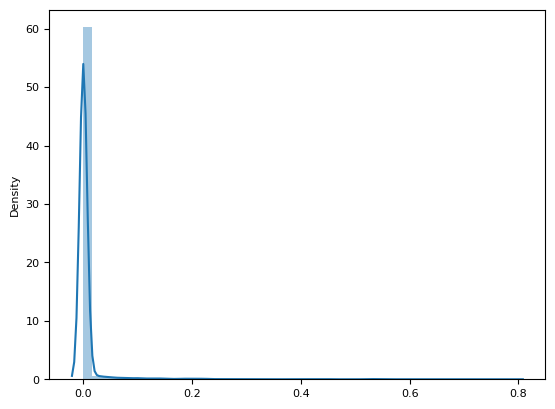

In [ ]:
sns.distplot(np.max(vertices_list, axis=-1) - np.min(vertices_list, axis=-1))

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
vertices_transformed = pca.fit_transform(vertices_list)

In [ ]:
vertices_transformed.shape

(10000, 2)

In [ ]:
#from scipy.spatial import ConvexHull
#hull = ConvexHull(vertices_transformed)

In [ ]:
#x_hull = np.append(vertices_transformed[hull.vertices,0],
#                      vertices_transformed[hull.vertices,0][0])
# y_hull = np.append(vertices_transformed[hull.vertices,1],
#                       vertices_transformed[hull.vertices,1][0])

In [ ]:
#sns.distplot(vertices_transformed.flatten())

In [ ]:
# # for p in vertices_transformed[:10000]:
# plt.scatter(vertices_transformed[:, 0], vertices_transformed[:, 1])
# plt.plot(x_hull, y_hull, "-", c="black")

## ENTROPY

/tmp/ipykernel_3221508/2990164431.py:41: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


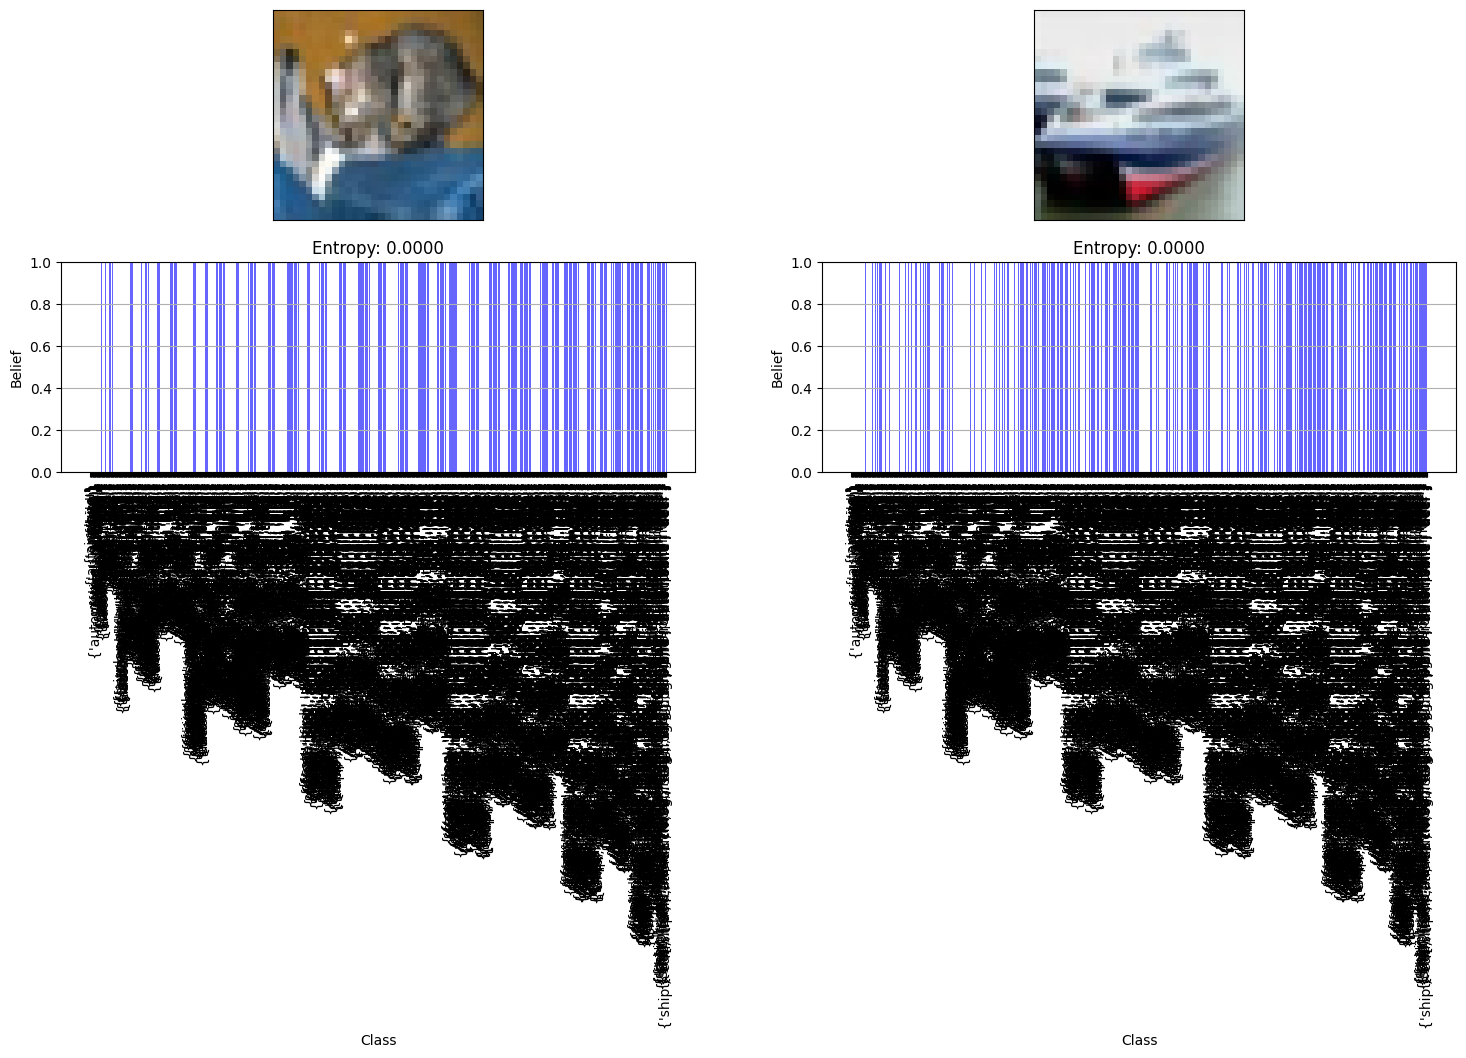

In [42]:
# Calculate the entropy of y_pred
########### FULL 1024 sets   
for dataset_name, models in metrics_data.items():
    print(f"------------{dataset_name}------------")
    for model_name, metrics in models.items():
        print(f"{model_name} - \t AUROC: {metrics['AUROC']:.6f}\tAUPRC: {metrics['AUPRC']:.6f}")

# Select the first 10 samples from y_pred, y_true, and x_true
y_pred_10 = test_preds[:10]
y_true_10 = y_test[:10]
x_true_10 = x_test_org[:10]

# Calculate entropy for the selected samples
entropy_values_10 = entropy_y[:10]

# Create subplots for each sample
fig, axes = plt.subplots(2, 2, figsize=(18, 6))
axes = axes.flatten()

# Loop through the samples and plot the entropy values and true images side by side
for i in range(2):
    ax = axes[i]
    ax.imshow(x_true_10[i], cmap='gray')
    #ax.set_xlabel(f'Entropy: {entropy_values_10[i]:.4f}\nTrue: {y_true_10[i]}')
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Plot the entropy distribution on the right-hand side
    ax_entropy = axes[i+2]
    ax_entropy.bar(np.arange(test_preds.shape[1]), y_pred_10[i], color='b', alpha=0.6)
    ax_entropy.set_xlabel('Class')
    ax_entropy.set_ylabel('Belief')
    ax_entropy.set_title(f'\nEntropy: {entropy_values_10[i]:.4f}')
    ax_entropy.set_xticks(np.arange(test_preds.shape[1]))
    ax_entropy.set_xticklabels(new_classes, rotation=90)
    ax_entropy.set_ylim([0, 1])
    ax_entropy.grid(axis='y')


# plt.savefig("Entropy_belief.pdf", format="pdf", bbox_inches="tight")
plt.tight_layout()
plt.show()

## OOD (NOISY)

(10000, 30)
(10000, 31)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test Accuracy using BetP for noisy test images: 28.52%


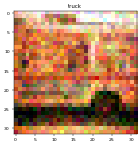

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'deer', 'frog', 'automobile'}			0.9997747540473938
{'horse', 'dog'}			0.9979149699211121
{'deer', 'cat'}			0.9976150989532471
{'truck'}			0.997184693813324
{'dog', 'cat'}			0.9883061051368713

-------------Mass Values----------------------------
{'deer', 'frog', 'automobile'}			0.20015405010492912
{'horse', 'dog'}			0.2001290286992948
{'truck'}			0.19998279405409716
{'deer', 'cat'}			0.1999268747406797
{'dog', 'cat'}			0.19805989966516138

-------------Pignistic Probabilities----------------------------
truck			0.19998279405409716
dog			0.19923946559672834
cat			0.19913558257654349
deer			0.16676000263679497
horse			0.10006461350378242





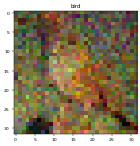

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'horse', 'cat'}			1.0
{'frog', 'automobile'}			1.0
{'bird'}			1.0
{'cat', 'automobile'}			1.0
{'truck', 'horse'}			1.0

-------------Mass Values----------------------------
{'bird'}			0.16666666666653687
{'truck', 'horse'}			0.16666666666653654
{'cat', 'automobile'}			0.16666666666653396
{'horse', 'cat'}			0.16666666666653362
{'frog', 'automobile'}			0.1666666666663126

-------------Pignistic Probabilities----------------------------
automobile			0.22222222222201865
bird			0.22222222222185264
cat			0.166666666666914
horse			0.16666666666653557
frog			0.08333333333374604





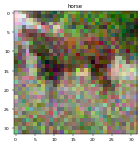

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'cat', 'automobile'}			0.7438924312591553
{'bird', 'deer', 'automobile'}			0.7362349033355713
{'deer', 'frog'}			0.5044025182723999
{'ship', 'automobile'}			0.48696210980415344
{'dog', 'cat'}			0.4842648506164551

-------------Mass Values----------------------------
{'cat', 'automobile'}			0.16133086270234198
{'bird', 'deer', 'automobile'}			0.15951584655117013
{'deer', 'frog'}			0.10892355324647637
{'ship', 'automobile'}			0.10562643628088758
{'frog', 'cat'}			0.10411593856847612

-------------Pignistic Probabilities----------------------------
automobile			0.1872862608693663
cat			0.1700064786963498
frog			0.15939193564999146
deer			0.10796263139603236
ship			0.1047647114320154





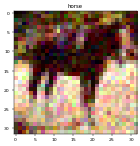

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'frog', 'ship'}			0.9273653030395508
{'dog', 'cat'}			0.7961843609809875
{'ship', 'automobile'}			0.7742230296134949
{'cat', 'automobile'}			0.68971186876297
{'bird', 'deer', 'automobile'}			0.6420730352401733

-------------Mass Values----------------------------
{'frog', 'ship'}			0.231857444055311
{'ship', 'automobile'}			0.19357093363757644
{'cat', 'automobile'}			0.17244911016006026
{'bird', 'deer', 'automobile'}			0.16497769542545132
{'dog'}			0.15902346128509873

-------------Pignistic Probabilities----------------------------
automobile			0.23856856411269606
ship			0.2127238458255979
dog			0.17904715601086912
frog			0.12934094593931056
cat			0.10689768453161164





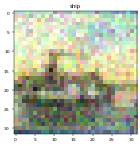

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'deer', 'frog', 'bird'}			1.0
{'ship'}			1.0
{'bird', 'automobile'}			1.0
{'horse', 'dog'}			1.0
{'deer', 'cat'}			9.780208760912235e-12

-------------Mass Values----------------------------
{'ship'}			0.2499999999993312
{'horse', 'dog'}			0.2499999999993312
{'bird', 'automobile'}			0.24999999999933115
{'deer', 'frog', 'bird'}			0.2499999999974101
{'deer', 'cat'}			2.4448918134873406e-12

-------------Pignistic Probabilities----------------------------
ship			0.2499999999993312
bird			0.20833333333223314
automobile			0.12499999999969233
dog			0.12499999999968853
horse			0.12499999999966853





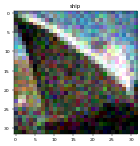

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'bird', 'automobile'}			0.9657986164093018
{'deer', 'frog', 'bird'}			0.9505113959312439
{'ship'}			0.9474936127662659
{'horse', 'dog'}			0.9343821406364441
{'deer', 'frog'}			0.11051640659570694

-------------Mass Values----------------------------
{'bird', 'automobile'}			0.24599379363393514
{'ship'}			0.24194513174592266
{'horse', 'dog'}			0.23857552113875719
{'deer', 'frog', 'bird'}			0.20412252877447545
{'deer', 'frog'}			0.028217476722755746

-------------Pignistic Probabilities----------------------------
ship			0.24194513174592266
bird			0.19652126156339603
automobile			0.12347399185814076
horse			0.11971099799575999
dog			0.11931368600858083





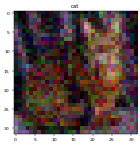

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'cat', 'automobile'}			0.9065974354743958
{'bird', 'deer', 'automobile'}			0.8994786739349365
{'frog', 'ship'}			0.264952689409256
{'dog'}			0.11429112404584885
{'frog', 'bird'}			0.07044883072376251

-------------Mass Values----------------------------
{'cat', 'automobile'}			0.3834108503717972
{'bird', 'deer', 'automobile'}			0.3695437365456313
{'frog', 'ship'}			0.11202203146901812
{'dog'}			0.04834073509891173
{'frog', 'bird'}			0.02836535146593528

-------------Pignistic Probabilities----------------------------
automobile			0.33492590004709677
cat			0.1925604656280967
deer			0.1419627518483801
bird			0.13879548330303085
frog			0.07201750912283145





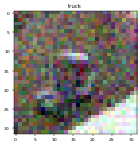

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'frog', 'bird'}			0.999982476234436
{'deer', 'frog'}			0.9999790191650391
{'airplane'}			0.9999780654907227
{'deer', 'cat'}			0.9999672174453735
{'frog', 'ship'}			0.999962568283081

-------------Mass Values----------------------------
{'frog', 'bird'}			0.19999781550656376
{'deer', 'frog'}			0.1999975413905573
{'airplane'}			0.19999736984216782
{'deer', 'cat'}			0.19999454484601115
{'frog', 'ship'}			0.19999424476665023

-------------Pignistic Probabilities----------------------------
frog			0.29999834262457425
airplane			0.19999736984216782
deer			0.1999968323683059
bird			0.10000117515793062
cat			0.09999941550586848





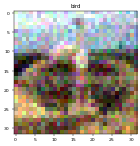

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'ship'}			0.7226086854934692
{'deer', 'frog', 'bird'}			0.6870601773262024
{'bird', 'automobile'}			0.6450685262680054
{'horse', 'dog'}			0.5150184035301208
{'frog', 'ship'}			0.3815310299396515

-------------Mass Values----------------------------
{'ship'}			0.27549910276370976
{'bird', 'automobile'}			0.2458289377628272
{'deer', 'frog', 'bird'}			0.23857986604211348
{'horse', 'dog'}			0.19554512602583474
{'deer', 'frog'}			0.014415898555277808

-------------Pignistic Probabilities----------------------------
ship			0.27549910276370976
bird			0.20696063744833387
automobile			0.12370844934227997
dog			0.0986267116035638
horse			0.09787521026645254





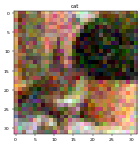

{'dog'}			0.7872902750968933
{'ship', 'automobile'}			0.7823128700256348
{'cat', 'automobile'}			0.7748538851737976
{'dog', 'cat'}			0.7641971111297607
{'bird', 'deer', 'automobile'}			0.7627857327461243

-------------Mass Values----------------------------
{'dog'}			0.19514662237901537
{'ship', 'automobile'}			0.19391116902758904
{'frog', 'ship'}			0.1805487536562558
{'cat', 'automobile'}			0.1425126455772097
{'bird', 'deer', 'automobile'}			0.07715231936411583

-------------Pignistic Probabilities----------------------------
automobile			0.2743236216953697
dog			0.19514662237901537
ship			0.18723098358369666
cat			0.12080700060285518
frog			0.11481144553378334





In [ ]:
# Add random noise to the images
noise = np.random.normal(loc=0.0, scale=0.1, size=x_test.shape)
x_test_noisy = x_test + noise
x_test_org_noisy = x_test_org + noise

# Clip the values to [0, 1] range
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# test_preds_noisy = new_model.predict(x_test_noisy)
test_preds_noisy = np.load("/home/shireen/RS-CNN/CIFAR10_ResNet50/saved_ResNet50/test_preds_noisy.npy")
print(test_preds_noisy.shape)
test_preds_mass_noisy = belief_to_mass(test_preds_noisy, new_classes)
test_preds_mass_noisy[test_preds_mass_noisy<0] = 0
sums_noisy = 1 - np.sum(test_preds_mass_noisy, axis=-1)
sums_noisy[sums_noisy<0] = 0
test_preds_mass_noisy = np.append(test_preds_mass_noisy, sums_noisy[:, None], axis=-1)
test_preds_mass_noisy = test_preds_mass_noisy/np.sum(test_preds_mass_noisy, axis=-1)[:, None]
print(test_preds_mass_noisy.shape)
final_bet_p_noisy = final_betp(test_preds_mass_noisy, classes)

final_bet_p_indices_noisy = np.argmax(final_bet_p_noisy, axis = -1)
accuracy_noisy = (np.sum(final_bet_p_indices_noisy == y_test)/len(y_test))*100
print(f"Test Accuracy using BetP for noisy test images: {accuracy_noisy}%")

for im_index in np.random.randint(0, len(test_preds), 10):
  plt.figure(figsize=(4,4), dpi=40)
  im = x_test_org_noisy[im_index]
  top_labels = np.argsort(test_preds_noisy[im_index])[::-1][:5]
  plt.imshow(im, cmap="gray")
  plt.title(str(classes[y_test[im_index]]))
  plt.show()
  for t in top_labels:
    print(f"{new_classes[t]}\t\t\t{test_preds_noisy[im_index][t]}")
  
  print("\n-------------Mass Values----------------------------")
  top_labels_mass = np.argsort(test_preds_mass_noisy[im_index])[::-1][:5]
  for t in top_labels_mass:
    print(f"{new_classes_with_full[t]}\t\t\t{test_preds_mass_noisy[im_index][t]}")
  
  print("\n-------------Pignistic Probabilities----------------------------")
  top_labels_pignistic = np.argsort(final_bet_p_noisy[im_index])[::-1][:5]
  for t in top_labels_pignistic:
    print(f"{classes[t]}\t\t\t{final_bet_p_noisy[im_index][t]}")

  print("\n\n")



In [ ]:
# np.save("/home/shireen/RS-CNN/CIFAR10_ResNet50/saved_ResNet50/test_preds_noisy.npy", test_preds_noisy)

/tmp/ipykernel_61777/1833434604.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(incorrect_probs_noisy)


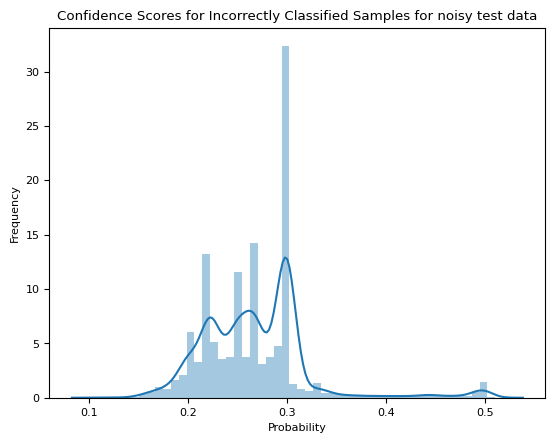

In [ ]:
# Find the indices of incorrectly classified samples
incorrect_idx_noisy = np.nonzero(final_bet_p_indices_noisy != y_test)

# Filter out the confidence scores for the incorrectly classified samples
incorrect_probs_noisy = np.max(final_bet_p_noisy[incorrect_idx_noisy], axis=1)

# Plot the histogram of confidence scores
# plt.hist(incorrect_probs, bins=10)
sns.distplot(incorrect_probs_noisy)
plt.title('Confidence Scores for Incorrectly Classified Samples for noisy test data')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

/tmp/ipykernel_61777/25983583.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(correct_probs_noisy)


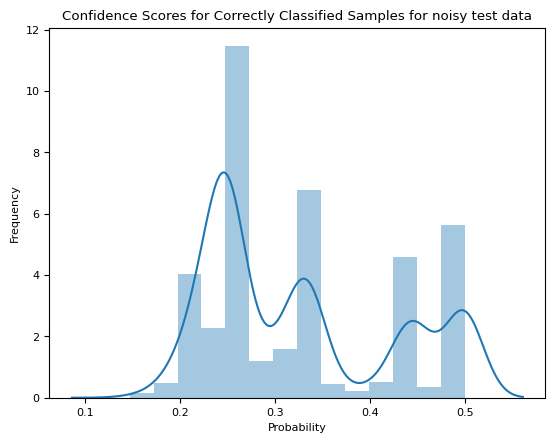

In [ ]:
# Find the indices of correctly classified samples
correct_idx_noisy = np.nonzero(final_bet_p_indices_noisy == y_test)

# Filter out the confidence scores for the correctly classified samples
correct_probs_noisy = np.max(final_bet_p_noisy[correct_idx_noisy], axis=1)

# Plot the histogram of confidence scores
# plt.hist(incorrect_probs, bins=10)
sns.distplot(correct_probs_noisy)
plt.title('Confidence Scores for Correctly Classified Samples for noisy test data')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

/tmp/ipykernel_61777/1142234089.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(incorrect_probs_noisy, color='red', label='Incorrectly Classified', kde=True)
/tmp/ipykernel_61777/1142234089.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(correct_probs_noisy, color='blue', label='Correc

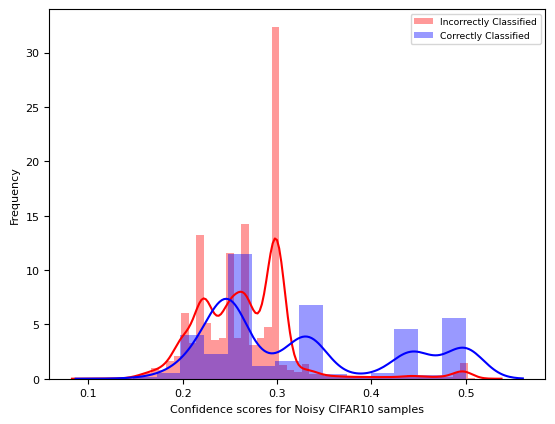

In [ ]:
# Find the indices of correctly classified samples
correct_idx_noisy = np.nonzero(final_bet_p_indices_noisy == y_test)[0]

# Filter out the confidence scores for the correctly classified samples
correct_probs_noisy = np.max(final_bet_p_noisy[correct_idx_noisy], axis=1)

# Find the indices of incorrectly classified samples
incorrect_idx_noisy = np.nonzero(final_bet_p_indices_noisy != y_test)[0]

# Filter out the confidence scores for the incorrectly classified samples
incorrect_probs_noisy = np.max(final_bet_p_noisy[incorrect_idx_noisy], axis=1)

# Plot the histogram of confidence scores
# plt.hist(incorrect_probs, bins=10)
sns.distplot(incorrect_probs_noisy, color='red', label='Incorrectly Classified', kde=True)
sns.distplot(correct_probs_noisy, color='blue', label='Correctly Classified', kde=True)
#plt.title('Confidence Scores for Incorrectly Classified Samples')
legend = plt.legend(fontsize='small')
plt.xlabel('Confidence scores for Noisy CIFAR10 samples')
plt.ylabel('Frequency')
plt.savefig("Confidence_Brscnn_CIFAR10_noisy.pdf", format="pdf", bbox_inches="tight")

plt.show()

/tmp/ipykernel_61777/3974578525.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(entropy(final_bet_p_noisy), label='Entropy')
/tmp/ipykernel_61777/3974578525.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(specific(test_preds_mass_noisy, new_classes), label='Specificity')


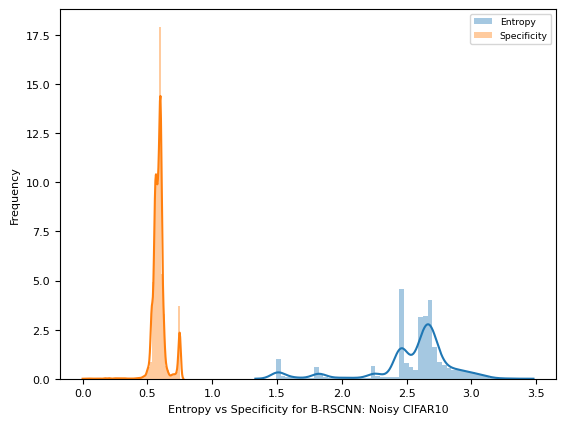

In [ ]:
sns.distplot(entropy(final_bet_p_noisy), label='Entropy')
sns.distplot(specific(test_preds_mass_noisy, new_classes), label='Specificity')
legend = plt.legend(fontsize='small')
plt.xlabel('Entropy vs Specificity for B-RSCNN: Noisy CIFAR10')
#plt.ylim(0,6)
plt.ylabel('Frequency')
plt.savefig("entrospec_brscnn_noisy_cifar10.pdf", format="pdf", bbox_inches="tight")

plt.show()

## ENTROPY FOR OOD (NOISY)

In [61]:
# Calculate the entropy of noisy
def entropy(pred_probs):
    # Avoid log(0) by setting it to a very small value
    eps = 1e-8
    entropy = -np.sum(pred_probs * np.log2(np.clip(pred_probs, eps, 1.0)), axis=1)
    return entropy

# Select the first 10 samples from y_pred, y_true, and x_true
y_pred_10_noisy = test_preds_noisy[:10]
y_true_10 = y_test[:10]
x_true_10 = x_test_org_noisy[:10]

# Calculate entropy for the selected samples
entropy_values_10 = entropy(y_pred_10_noisy)

# Create subplots for each sample
fig, axes = plt.subplots(2, 2, figsize=(18, 6))
axes = axes.flatten()

# Loop through the samples and plot the entropy values and true images side by side
for i in range(2):
    ax = axes[i]
    ax.imshow(x_true_10[i], cmap='gray')
    #ax.set_xlabel(f'Entropy: {entropy_values_10[i]:.4f}\nTrue: {y_true_10[i]}')
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Plot the entropy distribution on the right-hand side
    ax_entropy = axes[i+2]
    ax_entropy.bar(np.arange(test_preds_noisy.shape[1]), y_pred_10_noisy[i], color='b', alpha=0.6)
    ax_entropy.set_xlabel('Class')
    ax_entropy.set_ylabel('Probability')
    ax_entropy.set_title(f'\nEntropy: {entropy_values_10[i]:.4f}')
    ax_entropy.set_xticks(np.arange(test_preds_noisy.shape[1]))
    ax_entropy.set_xticklabels(new_classes, rotation=90)
    ax_entropy.set_ylim([0, 1])
    ax_entropy.grid(axis='y')


plt.tight_layout()
plt.show()

NameError: name 'test_preds_noisy' is not defined

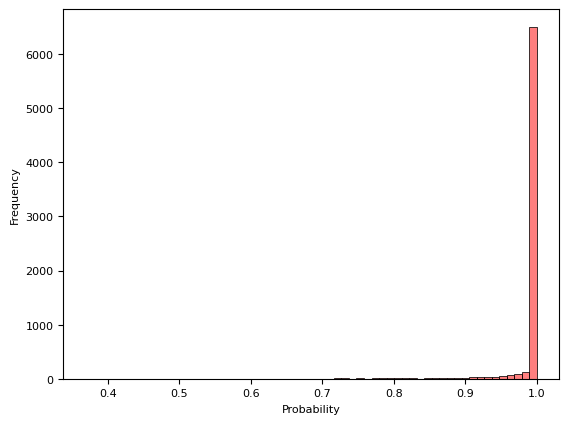

In [ ]:
sns.histplot(specificity[incorrect_idx_noisy], color='red', label='Incorrectly Classified', bins=60, alpha=0.5)
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

## OOD (ROTATED)

In [ ]:
#ROTATING IMAGES FOR TESTING
import random
import cv2

def rotated(x_test):
    # Rotate images
    rotated_images = []
    for img in x_test:
        # Generate random angle between 0 and 180 degrees
        angle = random.randint(-30, 90)
        # Rotate image by random angle clockwise
        M = cv2.getRotationMatrix2D((14,14), angle, 1) 
        rotated_img = cv2.warpAffine(img, M, (32, 32))
        rotated_images.append(rotated_img)

    # Convert list to NumPy array
    rotated_images = np.array(rotated_images)
    
    return rotated_images

x_test_rotated = rotated(x_test)
#x_test_rotated = np.expand_dims(x_test_rotated, -1)
x_test_org_rotated = rotated(x_test_org)
#x_test_org_rotated = np.expand_dims(x_test_org_rotated, -1)

(10000, 31)
Test Accuracy using BetP for rotated test images: 28.610000000000003%


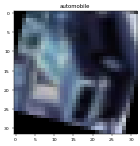

{'bird', 'deer', 'automobile'}			0.6789912581443787
{'frog', 'ship'}			0.6684150695800781
{'cat', 'automobile'}			0.6582983732223511
{'ship', 'automobile'}			0.6055634617805481
{'dog'}			0.5912972688674927

-------------Mass Values----------------------------
{'bird', 'deer', 'automobile'}			0.18147355530710016
{'cat', 'automobile'}			0.17363613258657437
{'ship', 'automobile'}			0.17072211149617558
{'dog'}			0.1667049109634676
{'frog', 'ship'}			0.15159636458239928

-------------Pignistic Probabilities----------------------------
automobile			0.2476525683987406
dog			0.1667049109634676
ship			0.16116153707075875
frog			0.13506025407630656
cat			0.11356329476719984





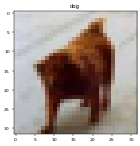

{'dog'}			0.9990455508232117
{'dog', 'cat'}			0.9990429282188416
{'cat', 'automobile'}			0.9990168809890747
{'bird', 'deer', 'automobile'}			0.9989929795265198
{'ship', 'automobile'}			0.9989405274391174

-------------Mass Values----------------------------
{'dog'}			0.19992670661561598
{'ship', 'automobile'}			0.1999056869285737
{'frog', 'ship'}			0.19983860725048475
{'cat', 'automobile'}			0.1997301174861256
{'bird', 'deer', 'automobile'}			0.19936958148157313

-------------Pignistic Probabilities----------------------------
automobile			0.2667896949193159
dog			0.19992670661561598
ship			0.19987214953007482
frog			0.10016408091896244
cat			0.10005591032353252





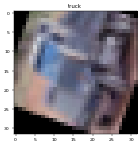

{'deer', 'frog', 'automobile'}			0.9913554787635803
{'deer', 'cat'}			0.9880157113075256
{'dog', 'cat'}			0.9873700141906738
{'truck'}			0.9871494174003601
{'horse', 'dog'}			0.9847524762153625

-------------Mass Values----------------------------
{'deer', 'frog', 'automobile'}			0.202741300066098
{'deer', 'cat'}			0.19701747152201826
{'dog', 'cat'}			0.19688871416098075
{'truck'}			0.19684472820633547
{'horse', 'dog'}			0.1963667400082711

-------------Pignistic Probabilities----------------------------
cat			0.19695310566227253
truck			0.19684472820633547
dog			0.1966277316889799
deer			0.16846158746381873
horse			0.09818338988072656





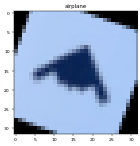

{'airplane'}			1.0
{'frog', 'ship'}			1.0
{'deer', 'frog'}			1.0
{'deer', 'cat'}			1.0
{'frog', 'bird'}			1.0

-------------Mass Values----------------------------
{'deer', 'frog'}			0.19999999999963344
{'airplane'}			0.19999999999963344
{'deer', 'cat'}			0.19999999999963247
{'frog', 'bird'}			0.19999999999963122
{'frog', 'ship'}			0.19999999999961346

-------------Pignistic Probabilities----------------------------
frog			0.2999999999996647
deer			0.19999999999967188
airplane			0.19999999999963344
bird			0.10000000000022327
cat			0.10000000000003613





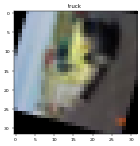

{'deer', 'cat'}			0.9999949932098389
{'horse', 'dog'}			0.9999949932098389
{'dog', 'cat'}			0.9999884366989136
{'deer', 'frog', 'automobile'}			0.9999858140945435
{'truck'}			0.9999850988388062

-------------Mass Values----------------------------
{'deer', 'cat'}			0.20000018558824723
{'horse', 'dog'}			0.2000001855882445
{'deer', 'frog', 'automobile'}			0.19999964496178949
{'dog', 'cat'}			0.1999988742782781
{'truck'}			0.1999982067022966

-------------Pignistic Probabilities----------------------------
cat			0.19999952993326398
dog			0.19999952993326336
truck			0.1999982067022966
deer			0.16666721542057894
horse			0.10000009279412321





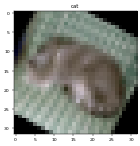

{'frog', 'automobile'}			0.9976517558097839
{'cat'}			0.9971116781234741
{'deer', 'frog', 'automobile'}			0.9970941543579102
{'deer', 'automobile'}			0.9968715310096741
{'bird', 'automobile'}			0.9965194463729858

-------------Mass Values----------------------------
{'frog', 'automobile'}			0.19998207204711058
{'cat'}			0.19989142325851467
{'deer', 'automobile'}			0.1998374842610574
{'bird', 'automobile'}			0.19950711030298754
{'dog', 'bird'}			0.1986182023506837

-------------Pignistic Probabilities----------------------------
automobile			0.29995428732455026
cat			0.19989142325851467
bird			0.19934001162220205
frog			0.10024338102403431
deer			0.09993630603212493





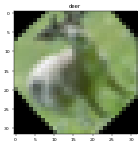

{'deer', 'automobile'}			0.9999990463256836
{'frog', 'bird'}			0.9999985694885254
{'deer'}			0.999997615814209
{'truck', 'horse'}			9.389545851945513e-08
{'horse', 'cat'}			7.426693571233045e-08

-------------Mass Values----------------------------
{'frog', 'bird'}			0.4999997891567123
{'deer'}			0.4999993243618188
{'deer', 'automobile'}			7.152563847293946e-07
{'truck', 'horse'}			4.6358675173774716e-08
{'horse', 'cat'}			3.646450896121268e-08

-------------Pignistic Probabilities----------------------------
deer			0.49999968199001116
frog			0.24999991440311714
bird			0.24999990605677377
automobile			3.8317242261433114e-07
horse			4.1996474925365734e-08





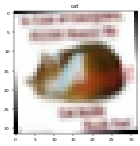

{'cat'}			0.9981628060340881
{'frog', 'automobile'}			0.9979708790779114
{'truck', 'cat'}			0.9978171586990356
{'deer', 'automobile'}			0.9977948665618896
{'bird', 'automobile'}			0.99774569272995

-------------Mass Values----------------------------
{'cat'}			0.19994727608318366
{'frog', 'automobile'}			0.19989566954984436
{'deer', 'automobile'}			0.19986770075554924
{'bird', 'automobile'}			0.19984160749160546
{'dog', 'bird'}			0.19954709764621834

-------------Pignistic Probabilities----------------------------
automobile			0.29989740943622034
cat			0.19994727608318366
bird			0.19971620155538589
frog			0.10013872965352792
dog			0.10000079335342248





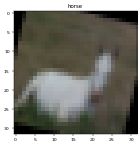

{'truck', 'horse'}			0.9913220405578613
{'truck', 'cat'}			0.9262852668762207
{'horse'}			0.9257753491401672
{'frog', 'cat'}			0.9189499616622925
{'deer', 'frog'}			0.912270188331604

-------------Mass Values----------------------------
{'horse'}			0.22699936322278957
{'truck', 'cat'}			0.22522256272848512
{'deer', 'frog'}			0.2233514989447052
{'frog', 'cat'}			0.22325650811333675
{'frog', 'automobile'}			0.04400986916237731

-------------Pignistic Probabilities----------------------------
frog			0.24547933431732097
horse			0.2350338847209178
cat			0.23324334503862618
truck			0.12064875533131707
deer			0.11661871958553122





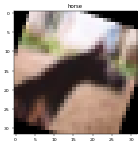

{'bird', 'deer', 'automobile'}			0.9877676367759705
{'cat', 'automobile'}			0.9866989850997925
{'bird'}			0.7679789662361145
{'frog', 'automobile'}			0.7524905204772949
{'deer', 'bird'}			0.744192361831665

-------------Mass Values----------------------------
{'bird', 'deer', 'automobile'}			0.17332699600130974
{'cat', 'automobile'}			0.17036621227724014
{'bird'}			0.1330752362828797
{'frog', 'automobile'}			0.13019023399216118
{'horse', 'cat'}			0.11993449723419176

-------------Pignistic Probabilities----------------------------
automobile			0.23498567405260443
bird			0.1922128794955553
cat			0.14590534055811052
horse			0.11725881945583658
frog			0.08927244760170283





In [ ]:
# test_preds_rotated = new_model.predict(x_test_rotated)
test_preds_rotated = np.load("/home/shireen/RS-CNN/CIFAR10_ResNet50/saved_ResNet50/test_preds_rotated.npy")
test_preds_mass_rotated = belief_to_mass(test_preds_rotated, new_classes)
test_preds_mass_rotated[test_preds_mass_rotated<0] = 0
sums_rotated = 1 - np.sum(test_preds_mass_rotated, axis=-1)
sums_rotated[sums_rotated<0] = 0
test_preds_mass_rotated = np.append(test_preds_mass_rotated, sums_rotated[:, None], axis=-1)
test_preds_mass_rotated = test_preds_mass_rotated/np.sum(test_preds_mass_rotated, axis=-1)[:, None]
print(test_preds_mass_rotated.shape)
final_bet_p_rotated = final_betp(test_preds_mass_rotated, classes)

final_bet_p_indices_rotated = np.argmax(final_bet_p_rotated, axis = -1)
accuracy_rotated = (np.sum(final_bet_p_indices_rotated == y_test)/len(y_test))*100
print(f"Test Accuracy using BetP for rotated test images: {accuracy_rotated}%")

for im_index in np.random.randint(0, len(test_preds), 10):
  plt.figure(figsize=(4,4), dpi=40)
  im = x_test_org_rotated[im_index]
  top_labels = np.argsort(test_preds_rotated[im_index])[::-1][:5]
  plt.imshow(im, cmap="gray")
  plt.title(str(classes[y_test[im_index]]))
  plt.show()
  for t in top_labels:
    print(f"{new_classes[t]}\t\t\t{test_preds_rotated[im_index][t]}")
  
  print("\n-------------Mass Values----------------------------")
  top_labels_mass = np.argsort(test_preds_mass_rotated[im_index])[::-1][:5]
  for t in top_labels_mass:
    print(f"{new_classes_with_full[t]}\t\t\t{test_preds_mass_rotated[im_index][t]}")
  
  print("\n-------------Pignistic Probabilities----------------------------")
  top_labels_pignistic = np.argsort(final_bet_p_rotated[im_index])[::-1][:5]
  for t in top_labels_pignistic:
    print(f"{classes[t]}\t\t\t{final_bet_p_rotated[im_index][t]}")

  print("\n\n")

In [ ]:
# np.save("/home/shireen/RS-CNN/CIFAR10_ResNet50/saved_ResNet50/test_preds_rotated.npy", test_preds_rotated)

/tmp/ipykernel_61777/977543456.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(incorrect_probs_rotated, color='red', label='Incorrectly Classified', kde=True)
/tmp/ipykernel_61777/977543456.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(correct_probs_rotated, color='blue', label='Corr

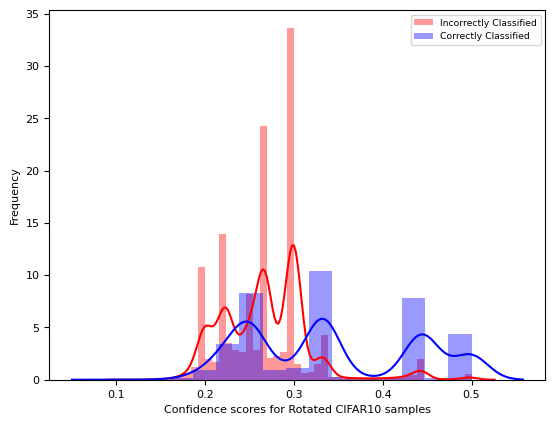

In [ ]:
# Find the indices of correctly classified samples
correct_idx_rotated = np.nonzero(final_bet_p_indices_rotated == y_test)[0]

# Filter out the confidence scores for the correctly classified samples
correct_probs_rotated = np.max(final_bet_p_rotated[correct_idx_rotated], axis=1)

# Find the indices of incorrectly classified samples
incorrect_idx_rotated = np.nonzero(final_bet_p_indices_rotated != y_test)[0]

# Filter out the confidence scores for the incorrectly classified samples
incorrect_probs_rotated = np.max(final_bet_p_rotated[incorrect_idx_rotated], axis=1)

# Plot the histogram of confidence scores
# plt.hist(incorrect_probs, bins=10)
sns.distplot(incorrect_probs_rotated, color='red', label='Incorrectly Classified', kde=True)
sns.distplot(correct_probs_rotated, color='blue', label='Correctly Classified', kde=True)
#plt.title('Confidence Scores for Incorrectly Classified Samples')
legend = plt.legend(fontsize='small')
#plt.ylim(0,10)
plt.xlabel('Confidence scores for Rotated CIFAR10 samples')
plt.ylabel('Frequency')
#plt.savefig("Confidence_Brscnn_CIFAR10_rotated.pdf", format="pdf", bbox_inches="tight")

plt.show()

/tmp/ipykernel_61777/89404495.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(entropy(final_bet_p_rotated), label='Entropy')
/tmp/ipykernel_61777/89404495.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(specific(test_preds_mass_rotated, new_classes), label='Specificity')


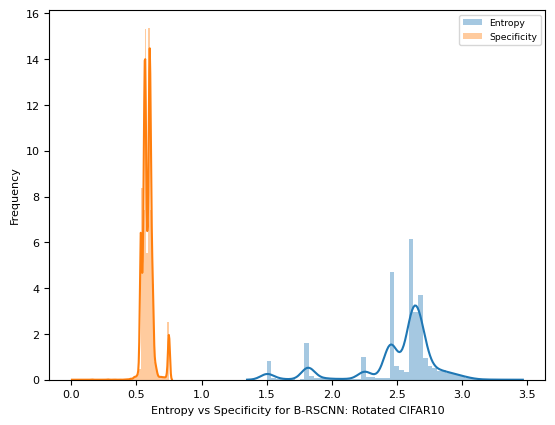

In [ ]:
sns.distplot(entropy(final_bet_p_rotated), label='Entropy')
sns.distplot(specific(test_preds_mass_rotated, new_classes), label='Specificity')
legend = plt.legend(fontsize='small')
plt.xlabel('Entropy vs Specificity for B-RSCNN: Rotated CIFAR10')
#plt.ylim(0,6)
plt.ylabel('Frequency')
plt.savefig("entrospec_brscnn_rotated_cifar10.pdf", format="pdf", bbox_inches="tight")

plt.show()

## ENTROPY FOR OOD (rotated)

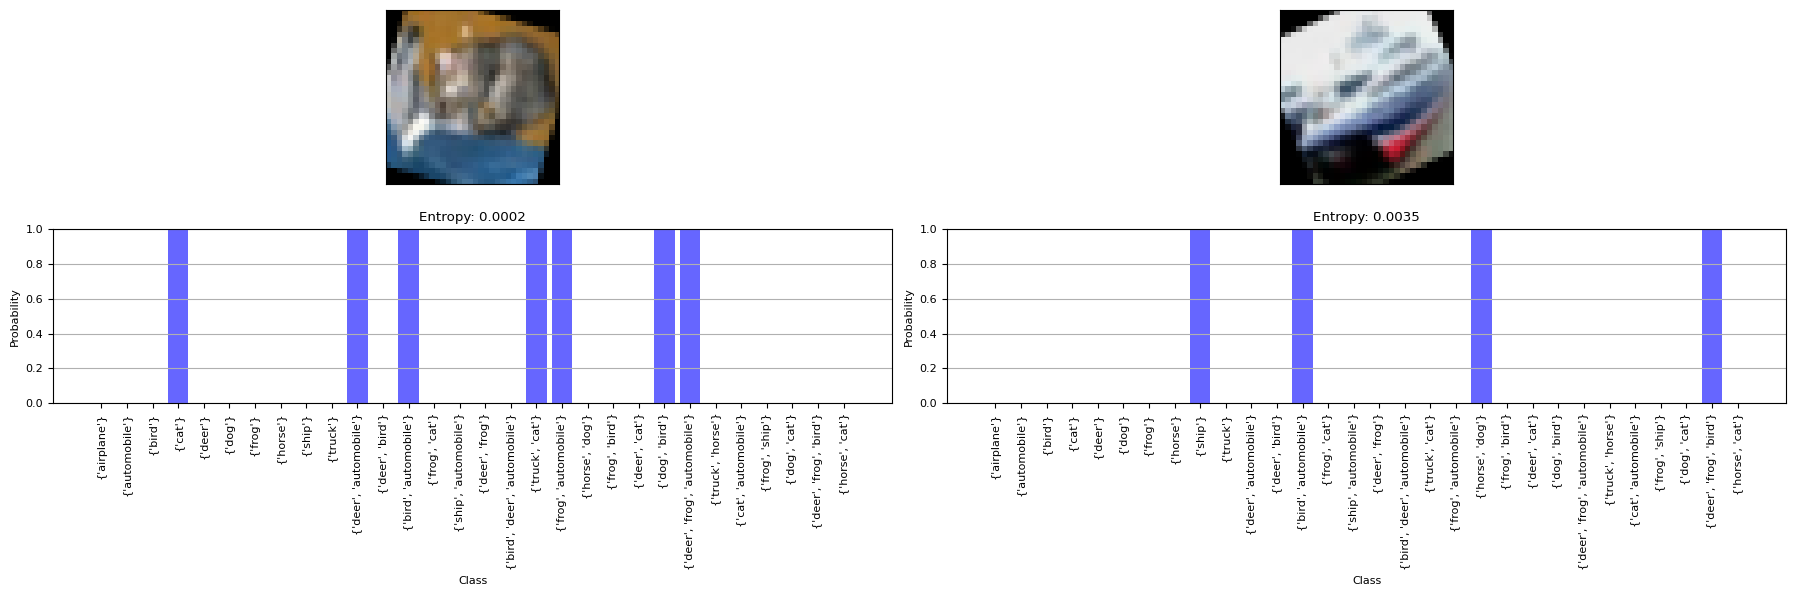

In [ ]:
# Calculate the entropy of rotated
def entropy(pred_probs):
    # Avoid log(0) by setting it to a very small value
    eps = 1e-8
    entropy = -np.sum(pred_probs * np.log2(np.clip(pred_probs, eps, 1.0)), axis=1)
    return entropy

# Select the first 10 samples from y_pred, y_true, and x_true
y_pred_10_rotated = test_preds_rotated[:10]
y_true_10 = y_test[:10]
x_true_10 = x_test_org_rotated[:10]

# Calculate entropy for the selected samples
entropy_values_10 = entropy(y_pred_10_rotated)

# Create subplots for each sample
fig, axes = plt.subplots(2, 2, figsize=(18, 6))
axes = axes.flatten()

# Loop through the samples and plot the entropy values and true images side by side
for i in range(2):
    ax = axes[i]
    ax.imshow(x_true_10[i], cmap='gray')
    #ax.set_xlabel(f'Entropy: {entropy_values_10[i]:.4f}\nTrue: {y_true_10[i]}')
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Plot the entropy distribution on the right-hand side
    ax_entropy = axes[i+2]
    ax_entropy.bar(np.arange(test_preds_rotated.shape[1]), y_pred_10_rotated[i], color='b', alpha=0.6)
    ax_entropy.set_xlabel('Class')
    ax_entropy.set_ylabel('Probability')
    ax_entropy.set_title(f'\nEntropy: {entropy_values_10[i]:.4f}')
    ax_entropy.set_xticks(np.arange(test_preds_rotated.shape[1]))
    ax_entropy.set_xticklabels(new_classes, rotation=90)
    ax_entropy.set_ylim([0, 1])
    ax_entropy.grid(axis='y')


plt.tight_layout()
plt.show()

# PLOTS

/tmp/ipykernel_61777/1434825467.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(incorrect_probs, color='red', label='Incorrectly Classified', kde=True, bins=20,ax=axes[0])
/tmp/ipykernel_61777/1434825467.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(correct_probs, color='blue', label

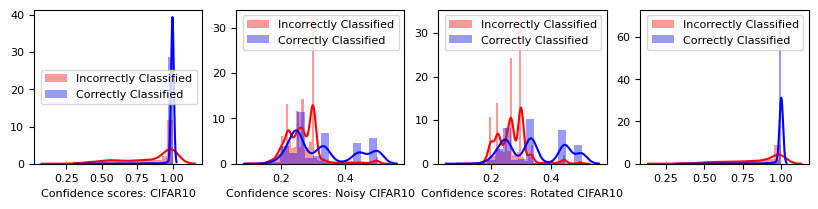

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(10, 2))

# Find the indices of incorrectly classified samples
incorrect_idx = np.nonzero(final_bet_p_indices != y_test)[0]

# Filter out the confidence scores for the incorrectly classified samples
incorrect_probs = np.max(final_bet_p[incorrect_idx], axis=1)

# Find the indices of incorrectly classified samples
correct_idx = np.nonzero(final_bet_p_indices == y_test)[0]

# Filter out the confidence scores for the incorrectly classified samples
correct_probs = np.max(final_bet_p[correct_idx], axis=1)

# Plot the histogram of confidence scores
# plt.hist(incorrect_probs, bins=10)
sns.distplot(incorrect_probs, color='red', label='Incorrectly Classified', kde=True, bins=20,ax=axes[0])
sns.distplot(correct_probs, color='blue', label='Correctly Classified', kde=True, bins=20,ax=axes[0])
#plt.title('Confidence Scores for Incorrectly Classified Samples')
axes[0].set_xlabel('Confidence scores: CIFAR10')

#plt.ylim(0,6)
#plt.savefig("Confidence_Brscnn_k100.pdf", format="pdf", bbox_inches="tight")



# Find the indices of correctly classified samples
correct_idx_noisy = np.nonzero(final_bet_p_indices_noisy == y_test)[0]

# Filter out the confidence scores for the correctly classified samples
correct_probs_noisy = np.max(final_bet_p_noisy[correct_idx_noisy], axis=1)

# Find the indices of incorrectly classified samples
incorrect_idx_noisy = np.nonzero(final_bet_p_indices_noisy != y_test)[0]

# Filter out the confidence scores for the incorrectly classified samples
incorrect_probs_noisy = np.max(final_bet_p_noisy[incorrect_idx_noisy], axis=1)

# Plot the histogram of confidence scores
# plt.hist(incorrect_probs, bins=10)
sns.distplot(incorrect_probs_noisy, color='red', label='Incorrectly Classified', kde=True,ax=axes[1])
sns.distplot(correct_probs_noisy, color='blue', label='Correctly Classified', kde=True,ax=axes[1])
#plt.title('Confidence Scores for Incorrectly Classified Samples')
axes[1].set_xlabel('Confidence scores: Noisy CIFAR10')

#plt.savefig("Confidence_Brscnn_CIFAR10_noisy.pdf", format="pdf", bbox_inches="tight")

# Find the indices of correctly classified samples
correct_idx_rotated = np.nonzero(final_bet_p_indices_rotated == y_test)[0]

# Filter out the confidence scores for the correctly classified samples
correct_probs_rotated = np.max(final_bet_p_rotated[correct_idx_rotated], axis=1)

# Find the indices of incorrectly classified samples
incorrect_idx_rotated = np.nonzero(final_bet_p_indices_rotated != y_test)[0]

# Filter out the confidence scores for the incorrectly classified samples
incorrect_probs_rotated = np.max(final_bet_p_rotated[incorrect_idx_rotated], axis=1)

# Plot the histogram of confidence scores
# plt.hist(incorrect_probs, bins=10)
sns.distplot(incorrect_probs_cnn, color='red', label='Incorrectly Classified', kde=True,ax=axes[3])
sns.distplot(correct_probs_cnn, color='blue', label='Correctly Classified', kde=True,ax=axes[3])
sns.distplot(incorrect_probs_rotated, color='red', label='Incorrectly Classified', kde=True,ax=axes[2])
sns.distplot(correct_probs_rotated, color='blue', label='Correctly Classified', kde=True,ax=axes[2])
#plt.title('Confidence Scores for Incorrectly Classified Samples')
#plt.ylim(0,10)
axes[2].set_xlabel('Confidence scores: Rotated CIFAR10')
#plt.savefig("Confidence_Brscnn_CIFAR10_rotated.pdf", format="pdf", bbox_inches="tight")

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[2].set_ylabel('')
#y_min = min(axes[0].get_ylim()[0], axes[1].get_ylim()[0], axes[2].get_ylim()[0])
#y_max = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1], axes[2].get_ylim()[1])
#axes[0].set_ylim(y_min, y_max)
#axes[1].set_ylim(y_min, y_max)
#axes[2].set_ylim(y_min, y_max)

y_min = min(axes[0].get_ylim()[0], axes[1].get_ylim()[0], axes[2].get_ylim()[0],  axes[3].get_ylim()[0])
y_max = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1], axes[2].get_ylim()[1],  axes[3].get_ylim()[1])
axes[3].legend()
axes[3].set_ylabel('')
#axes[3].set_ylim(y_min, y_max)

plt.savefig("Confidence_Brscnn_cifar.pdf", format="pdf", bbox_inches="tight")


plt.show()

/tmp/ipykernel_61777/750452144.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(entropy_y[correct_idx], label='Correctly Classified', ax=axes[0])
/tmp/ipykernel_61777/750452144.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(entropy_y[incorrect_idx], label='Incorrectly Classified', ax=axe

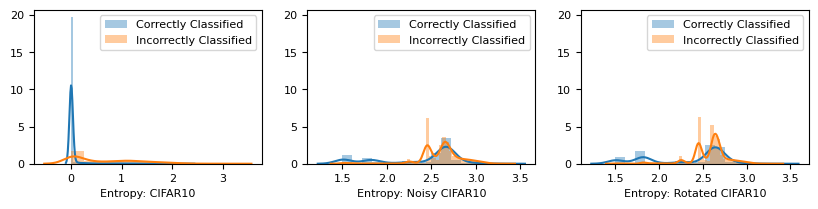

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 2))

sns.distplot(entropy_y[correct_idx], label='Correctly Classified', ax=axes[0])
sns.distplot(entropy_y[incorrect_idx], label='Incorrectly Classified', ax=axes[0])
axes[0].set_xlabel('Entropy: CIFAR10')
#plt.ylim(0,6)
#axes[0].set_ylabel('Frequency')
#plt.savefig("entro_brscnn_cc_cifar10.pdf", format="pdf", bbox_inches="tight")
sns.distplot(entropy(final_bet_p_noisy)[correct_idx_noisy], label='Correctly Classified', ax=axes[1])
sns.distplot(entropy(final_bet_p_noisy)[incorrect_idx_noisy], label='Incorrectly Classified', ax=axes[1])
axes[1].set_xlabel('Entropy: Noisy CIFAR10')

sns.distplot(entropy(final_bet_p_rotated)[correct_idx_rotated], label='Correctly Classified', ax=axes[2])
sns.distplot(entropy(final_bet_p_rotated)[incorrect_idx_rotated], label='Incorrectly Classified', ax=axes[2])
axes[2].set_xlabel('Entropy: Rotated CIFAR10')
axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[2].set_ylabel('')

axes[0].legend()
axes[1].legend()
axes[2].legend()
y_min = min(axes[0].get_ylim()[0], axes[1].get_ylim()[0], axes[2].get_ylim()[0])
y_max = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1], axes[2].get_ylim()[1])
axes[0].set_ylim(y_min, y_max)
axes[1].set_ylim(y_min, y_max)
axes[2].set_ylim(y_min, y_max)
plt.savefig("entro_brscnn_cifar.pdf", format="pdf", bbox_inches="tight")

plt.show()

/tmp/ipykernel_61777/2600927337.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(specificity[correct_idx], label='Correctly Classified', ax=axes[0])
/tmp/ipykernel_61777/2600927337.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(specificity[incorrect_idx], label='Incorrectly Classified', 

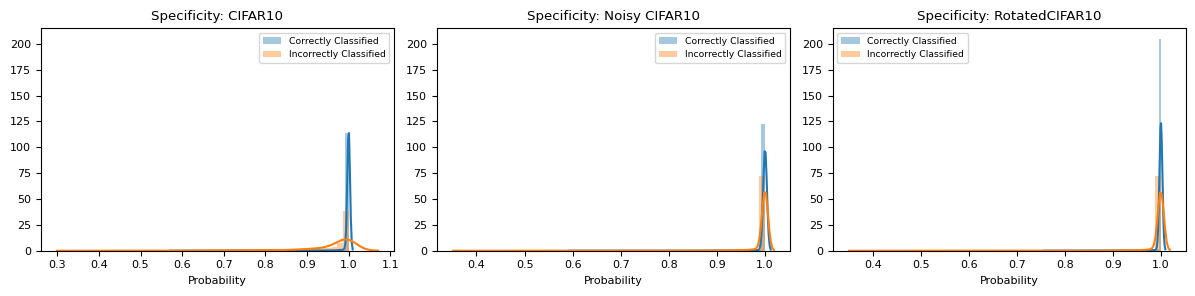

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

sns.distplot(specificity[correct_idx], label='Correctly Classified', ax=axes[0])
sns.distplot(specificity[incorrect_idx], label='Incorrectly Classified', ax=axes[0])

sns.distplot(specificity[correct_idx_noisy], label='Correctly Classified', ax=axes[1])
sns.distplot(specificity[incorrect_idx_noisy], label='Incorrectly Classified', ax=axes[1])

sns.distplot(specificity[correct_idx_rotated], label='Correctly Classified', ax=axes[2])
sns.distplot(specificity[incorrect_idx_rotated], label='Incorrectly Classified', ax=axes[2])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[2].set_ylabel('')

axes[0].legend(fontsize='small')
axes[1].legend(fontsize='small')
axes[2].legend(fontsize='small')

axes[0].set_title('Specificity: CIFAR10')
axes[1].set_title('Specificity: Noisy CIFAR10')
axes[2].set_title('Specificity: RotatedCIFAR10')
axes[0].set_xlabel('Probability')
axes[0].set_ylabel('')
axes[1].set_xlabel('Probability')
axes[1].set_ylabel('')
axes[2].set_xlabel('Probability')
axes[2].set_ylabel('')
y_min = min(axes[0].get_ylim()[0], axes[1].get_ylim()[0], axes[2].get_ylim()[0])
y_max = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1], axes[2].get_ylim()[1])
axes[0].set_ylim(y_min, y_max)
axes[1].set_ylim(y_min, y_max)
axes[2].set_ylim(y_min, y_max)
plt.tight_layout()
#plt.savefig("Spec_incorrec_cifar10.pdf", format="pdf", bbox_inches="tight")
plt.show()

## STANDARD CNN

In [ ]:
test_preds_org_noisy = model.predict(x_test_noisy)
score_noisy = model.evaluate(x_test_noisy, y_test_one_hot)
print(f"Test Accuracy of standard CNN for noisy test images: {score_noisy[1]*100}%")
test_preds_org_rotated = model.predict(x_test_rotated)
score_rot = model.evaluate(x_test_rotated, y_test_one_hot)
print(f"Test Accuracy of standard CNN for rotated test images: {score_rot[1]*100}%")
print(f"Test Accuracy using BetP for rotated test images: {accuracy_rotated}%")
print(f"Test Accuracy using BetP for noisy test images: {accuracy_noisy}%")

313/313 [==============================] - 11s 34ms/step - loss: 3.5993 - accuracy: 0.4533
Test Accuracy of standard CNN for noisy test images: 45.329999923706055%
313/313 [==============================] - 11s 34ms/step - loss: 2.8202 - accuracy: 0.5640
Test Accuracy of standard CNN for rotated test images: 56.40000104904175%
Test Accuracy using BetP for rotated test images: 28.610000000000003%
Test Accuracy using BetP for noisy test images: 28.52%


10it [00:08,  1.23it/s]


Text(0.5, 1.0, 'correct')

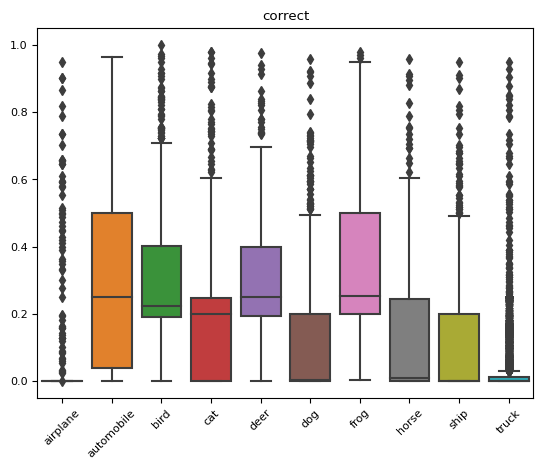

In [ ]:
vertices_noisy_incorrect,  vertices_p_noisy_incorrect= vertices(test_preds_mass_noisy, classes)
max_min_noisy_incorrect = {}
for c in vertices_p_noisy_incorrect:
    temp = np.max(vertices_p_noisy_incorrect[c], axis=-1) - np.min(vertices_p_noisy_incorrect[c], axis=-1)
    #max_min[c] = list(np.sort(temp)[::-1][:100]) + list(np.random.choice(np.sort(temp)[::-1][300:500], 10))
    max_min_noisy_incorrect[c] = temp
ax = sns.boxplot(pd.DataFrame(max_min_noisy_incorrect))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title('correct')
#plt.savefig("Credal_set_max_min_correct.pdf", format="pdf", bbox_inches="tight")

/tmp/ipykernel_61777/2835552953.py:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(incorrect_probs_cnn, color='red', label='Incorrectly Classified', kde=True)
/tmp/ipykernel_61777/2835552953.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(incorrect_probs, color='blue', label='Correctly Cl

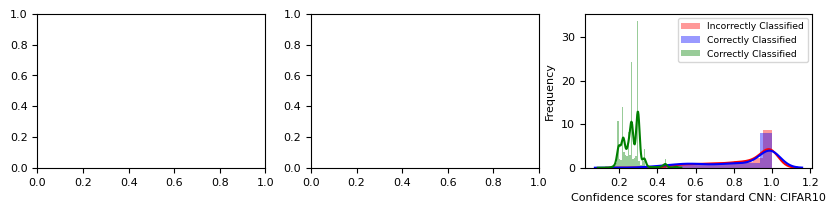

In [ ]:
#sns.distplot(incorrect_probs_cnn, color='green', label='Incorrectly Classified', kde=True, bins=20)
#sns.distplot(incorrect_probs, color='blue', label='Incorrectly Classified', kde=True, bins=20)
fig, axes = plt.subplots(1, 3, figsize=(10, 2))

# Find the indices of incorrectly classified samples
incorrect_idx_cnn_noisy = np.nonzero(np.argmax(test_preds_org_noisy, axis=-1) != y_test)[0]

# Filter out the confidence scores for the incorrectly classified samples
incorrect_probs_cnn_noisy = np.max(test_preds_org_noisy[incorrect_idx_cnn_noisy], axis=1)

# Find the indices of incorrectly classified samples
incorrect_idx_cnn_rotated = np.nonzero(np.argmax(test_preds_org_rotated, axis=-1) != y_test)[0]

# Filter out the confidence scores for the incorrectly classified samples
incorrect_probs_cnn_rotated = np.max(test_preds_org_rotated[incorrect_idx_cnn_rotated], axis=1)

# Plot the histogram of confidence scores
# plt.hist(incorrect_probs, bins=10)
sns.distplot(incorrect_probs_cnn, color='red', label='Incorrectly Classified', kde=True)
sns.distplot(incorrect_probs, color='blue', label='Correctly Classified', kde=True)
sns.distplot(incorrect_probs_rotated, color='green', label='Correctly Classified', kde=True)
legend = plt.legend(fontsize='small')
plt.xlabel('Confidence scores for standard CNN: CIFAR10')
#plt.ylim(0,6)
plt.ylabel('Frequency')
#plt.savefig("Confidence_cnn_cifar10.pdf", format="pdf", bbox_inches="tight")

plt.show()
plt.show()

### OOD (SVHN)

In [56]:
import scipy.io

# train_data = scipy.io.loadmat('/home/shireen/RSCNN/train_32x32.mat')
test_data = scipy.io.loadmat('/home/shireen/RSCNN/test_32x32.mat')

# x_train_svhn = train_data['X']
# y_train_svhn = train_data['y']
x_test_svhn = test_data['X']
y_test_svhn = test_data['y']
# x_train_svhn = x_train_svhn.transpose(3, 0, 1, 2)
x_test_svhn = x_test_svhn.transpose(3, 0, 1, 2)
#y_train_svhn = np.squeeze(y_train_svhn)

In [57]:
# Scaling images to [0, 1] range
# x_train_svhn = x_train_svhn.astype("float32") / 255
x_test_svhn = x_test_svhn.astype("float32") / 255
x_test_org = x_test

# standard normalizing
# x_train_svhn = (x_train_svhn - np.array([[[0.4914, 0.4822, 0.4465]]])) / np.array([[[0.2023, 0.1994, 0.2010]]])
x_test_svhn = (x_test_svhn - np.array([[[0.4914, 0.4822, 0.4465]]])) / np.array([[[0.2023, 0.1994, 0.2010]]])

# y_train_init = y_train
# y_test_init = y_test
# y_train_svhn = y_train_svhn[:,0]
y_test_svhn = y_test_svhn[:,0]

In [58]:
# x_train_svhn = x_train_svhn[0:50000]
x_test_svhn = x_test_svhn[0:10000]
# y_train_svhn = y_train_svhn[0:50000]
y_test_svhn = y_test_svhn[0:10000]

In [ ]:
# #x_train_svhn = np.array([cv2.resize(image, (224, 224)) for image in x_train_svhn])
# x_test_svhn = np.array([cv2.resize(image, (224, 224)) for image in x_test_svhn])

In [46]:
x_test_svhn.shape

(10000, 32, 32, 3)

In [65]:
new_classes = list(new_classes)

In [90]:
test_preds_svhn = new_model.predict(x_test_svhn)
# test_preds_svhn = np.load("/home/shireen/RS-CNN/CIFAR10_ResNet50/saved_ResNet50/test_preds_svhn.npy")
# test_preds_mass_svhn = belief_to_mass(test_preds_svhn, new_classes)
test_preds_mass_svhn = tf.matmul(test_preds_svhn, mass_coeff_matrix)
test_preds_mass_svhn = np.array(test_preds_mass_svhn)
test_preds_mass_svhn[test_preds_mass_svhn<0] = 0
sums_svhn = 1 - np.sum(test_preds_mass_svhn, axis=-1)
sums_svhn[sums_svhn<0] = 0
test_preds_mass_svhn = np.append(test_preds_mass_svhn, sums_svhn[:, None], axis=-1)
test_preds_mass_svhn = test_preds_mass_svhn/np.sum(test_preds_mass_svhn, axis=-1)[:, None]
final_bet_p_svhn = final_betp(test_preds_mass_svhn, classes)
# final_bet_p_svhn = test_preds_mass_svhn @ betp_approx(classes)

final_bet_p_indices_svhn = np.argmax(final_bet_p_svhn, axis = -1)
accuracy_svhn = (np.sum(final_bet_p_indices_svhn == y_test_svhn)/len(y_test_svhn))*100
print(f"Test Accuracy using BetP for SVHN (OOD) test images: {accuracy_svhn}%")



129/313 [===========>..................] - ETA: 2s

313/313 [==============================] - 5s 16ms/step
Test Accuracy using BetP for SVHN (OOD) test images: 10.02%


In [ ]:
entropy_ood_svhn = entropy(final_bet_p_svhn)

In [ ]:
# np.save("/home/shireen/RS-CNN/CIFAR10_ResNet50/saved_ResNet50/test_preds_svhn.npy", tet_preds_svhn)

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_ood(y_test_ood, final_bet_p_ood):
    # Calculate confusion matrix for OOD
    conf_matrix_ood = confusion_matrix(y_test_ood, np.argmax(final_bet_p_ood, axis=1))

    # Calculate FPR and TPR for each class
    num_classes = 10
    fpr_ood = np.zeros(num_classes)
    tpr_ood = np.zeros(num_classes)
    roc_auc = np.zeros(num_classes)

    for class_idx in range(num_classes):
        tn_ood = np.sum(np.delete(conf_matrix_ood, class_idx, axis=0)[:, class_idx])
        fp_ood = np.sum(conf_matrix_ood[class_idx, :]) - conf_matrix_ood[class_idx, class_idx]
        fn_ood = np.sum(conf_matrix_ood[class_idx, :]) - conf_matrix_ood[class_idx, class_idx]
        tp_ood = conf_matrix_ood[class_idx, class_idx]
        
        fpr_ood[class_idx] = fp_ood / (fp_ood + tn_ood)
        tpr_ood[class_idx] = tp_ood / (tp_ood + fn_ood)
        
        # Calculate ROC curve and AUROC for each class
        fpr, tpr, _ = roc_curve(y_test_ood == class_idx, final_bet_p_ood[:, class_idx])
        roc_auc[class_idx] = auc(fpr, tpr)

    # Calculate overall FPR and TPR
    overall_fpr = np.mean(fpr_ood)
    overall_tpr = np.mean(tpr_ood)

    # Calculate overall AUROC by averaging AUROC values for all classes
    overall_auroc = np.mean(roc_auc)

    # Print overall TPR, FPR, and AUROC
    print("Overall TPR:", overall_tpr)
    print("Overall FPR:", overall_fpr)
    print("Overall AUROC:", overall_auroc)

In [ ]:
evaluate_ood(y_test_svhn, final_bet_p_svhn)

Overall TPR: nan
Overall FPR: 0.5540592484547638
Overall AUROC: nan


/tmp/ipykernel_53783/3536025608.py:20: RuntimeWarning: invalid value encountered in scalar divide
  tpr_ood[class_idx] = tp_ood / (tp_ood + fn_ood)
/home/shireen/miniconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


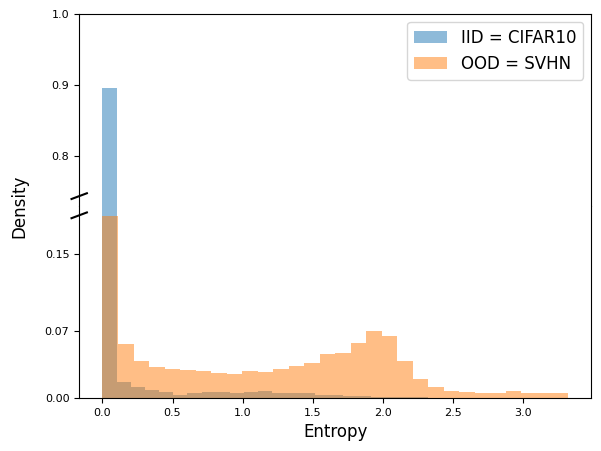

In [ ]:
f, (ax, ax2) = plt.subplots(2, 1, sharex=True, facecolor='w', )

bins = 30
ax.hist(entropy_y, bins, weights=np.ones(len(entropy_y)) / len(entropy_y), alpha=0.5, label='IID = CIFAR10')
ax2.hist(entropy_y, bins, weights=np.ones(len(entropy_y)) / len(entropy_y), alpha=0.5, label='IID = CIFAR10')


ax.hist(entropy(final_bet_p_svhn), bins , weights=np.ones(len(entropy_y)) / len(entropy_y), alpha=0.5, label='OOD = SVHN')
ax2.hist(entropy(final_bet_p_svhn), bins , weights=np.ones(len(entropy_y)) / len(entropy_y), alpha=0.5, label='OOD = SVHN')

ax2.set_ylim(0, 0.2)
ax.set_ylim(0.73,1.0)

ax.set_yticks([0.8, 0.9,1.0])
ax2.set_yticks([0,0.07,0.15])

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax.yaxis.tick_left()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (0.05-d, 0.05+d), **kwargs)
# ax.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (0.95-d, 0.95+d), **kwargs)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0)

ax.legend(prop = { "size": 12 })

ax.set_ylabel("Density", fontsize=12)
ax.yaxis.set_label_coords(-0.1,0)

ax2.set_xlabel("Entropy", fontsize=12)
#plt.savefig("plots saved/iid_ood_shift_fmnist.pdf", format="pdf", bbox_inches="tight")

plt.show()

### OOD (Intel Image)

In [64]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [ ]:
# from zipfile import ZipFile
# file_name="/home/shireen/RS-CNN/SVHN dataset/archive.zip"

# with ZipFile(file_name,'r') as zip:
#   zip.extractall()
#   print('done')

In [65]:
seg_train = './seg_train'
seg_test = './seg_test/seg_test'
# seg_pred = './seg_pred/seg_pred'
input_shape=(100,100,3)

generate = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

training_set = generate.flow_from_directory(seg_train,
                                            target_size = (100, 100),
                                            batch_size = 14034,
                                            classes = ["buildings","forest","glacier","mountain","sea","street"],
                                            class_mode = 'sparse',
                                            shuffle = False)
test_set = generate.flow_from_directory(seg_test,
                                        target_size = (100, 100),
                                        batch_size = 3000,
                                        classes = ["buildings","forest","glacier","mountain","sea","street"],
                                        class_mode = 'sparse',
                                        shuffle=False)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [66]:
x_train_intel, y_train_intel = training_set.next()
x_test_intel, y_test_intel = test_set.next()

In [ ]:
import numpy as np

In [ ]:
cifar10_iid = np.load("/home/shireen/RS-CNN/ENN/enn_preds/enn_preds/cifar10_iid/enn_preds_cifar10_iid.npy")


In [ ]:
cifar10_iid.shape

(2, 10000, 10)

In [64]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x)
    return e_x / np.sum(e_x, axis=-1, keepdims=True)#[:,:,None] # only difference

In [ ]:
def entropy(pred_probs):
    # Avoid log(0) by setting it to a very small value
    eps = 1e-8
    entrop = -np.sum(pred_probs * np.log2(np.clip(pred_probs, eps, 1.0)), axis=1)
    return entrop

In [ ]:
preds_s = softmax(np.mean(cifar10_iid, axis=0))
preds_s.shape

(10000, 10)

In [ ]:
ent = entropy(preds_s)
ent.shape

(10000,)

/tmp/ipykernel_53783/2040119659.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ent)


<Axes: ylabel='Density'>

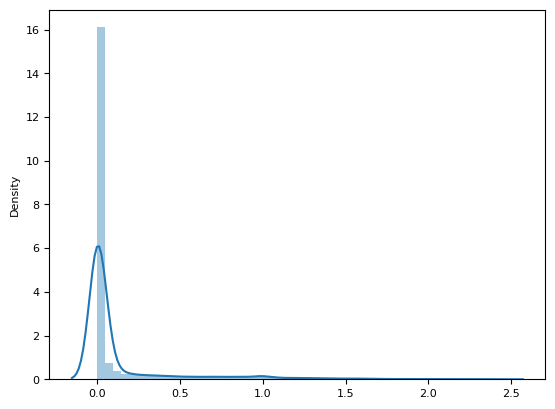

In [ ]:
import seaborn as sns
sns.distplot(ent)

/tmp/ipykernel_53783/2040119659.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ent)


<Axes: ylabel='Density'>

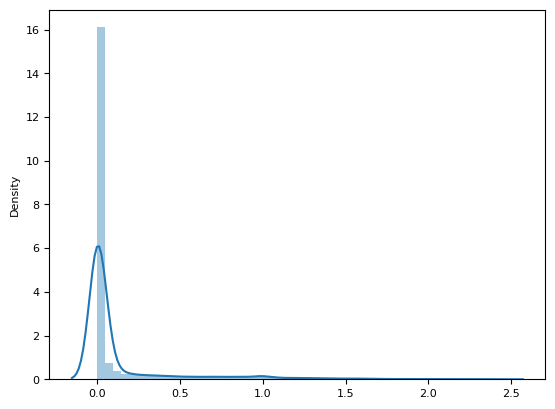

In [ ]:
import seaborn as sns
sns.distplot(ent)

In [ ]:
2,10000,10

(2, 10000, 10)

In [67]:
import cv2
def resize_images(images, target_size):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        resized_images.append(resized_img)
    return np.array(resized_images)

target_size = (32, 32)
x_train_intel = resize_images(x_train_intel, target_size)
x_test_intel = resize_images(x_test_intel, target_size)


In [66]:
x_train_intel.shape, y_train_intel.shape

((14034, 32, 32, 3), (14034,))

In [61]:
y_train_intel = to_categorical(y_train_intel)
y_test_intel = to_categorical(y_test_intel)

In [68]:
num_images_to_move = 7000
additional_x_test = x_train_intel[:num_images_to_move]
additional_y_test = y_train_intel[:num_images_to_move]

x_test_intel = np.concatenate((x_test_intel, additional_x_test), axis=0)
y_test_intel = np.concatenate((y_test_intel, additional_y_test), axis=0)

In [68]:
x_test_intel.shape, y_test_intel.shape

((10000, 32, 32, 3), (10000,))

In [ ]:
x_test_intel[0].shape

(32, 32, 3)

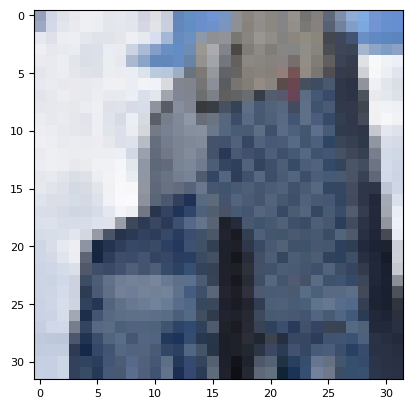

In [ ]:
plt.imshow(x_test_intel[0])

In [88]:
test_preds_intel = new_model.predict(x_test_intel)
# test_preds_intel = np.load("/home/shireen/RS-CNN/CIFAR10_ResNet50/saved_ResNet50/test_preds_intel.npy")
# test_preds_mass_intel = belief_to_mass(test_preds_intel, new_classes)
# test_preds_mass_intel[test_preds_mass_intel<0] = 0
# test_preds_mass_intel = test_preds_mass_intel/np.sum(test_preds_mass_intel, axis=-1)[:, None]
# final_bet_p_intel = final_betp(test_preds_mass_intel, classes)
test_preds_mass_intel = tf.matmul(test_preds_intel, mass_coeff_matrix)
test_preds_mass_intel = np.array(test_preds_mass_intel)
test_preds_mass_intel[test_preds_mass_intel<0] = 0
sums_intel = 1 - np.sum(test_preds_mass_intel, axis=-1)
sums_intel[sums_intel<0] = 0
test_preds_mass_intel = np.append(test_preds_mass_intel, sums_intel[:, None], axis=-1)

test_preds_mass_intel = test_preds_mass_intel/np.sum(test_preds_mass_intel, axis=-1)[:, None]
# final_bet_p_intel = test_preds_mass_intel @ betp_approx(classes)

final_bet_p_intel = final_betp(test_preds_mass_intel, classes)

final_bet_p_indices_intel = np.argmax(final_bet_p_intel, axis = -1)
accuracy_intel = (np.sum(final_bet_p_indices_intel == y_test_intel)/len(y_test_intel))*100
print(f"Test Accuracy using BetP for INTEL (OOD) test images: {accuracy_intel}%")

entropy_ood_intel = entropy(final_bet_p_intel)

313/313 [==============================] - 5s 16ms/step
Test Accuracy using BetP for INTEL (OOD) test images: 1.4000000000000001%


In [89]:
test_preds_mass_intel.shape

(10000, 31)

In [ ]:
# np.save("/home/shireen/RS-CNN/CIFAR10_ResNet50/saved_ResNet50/test_preds_intel.npy", test_preds_intel)

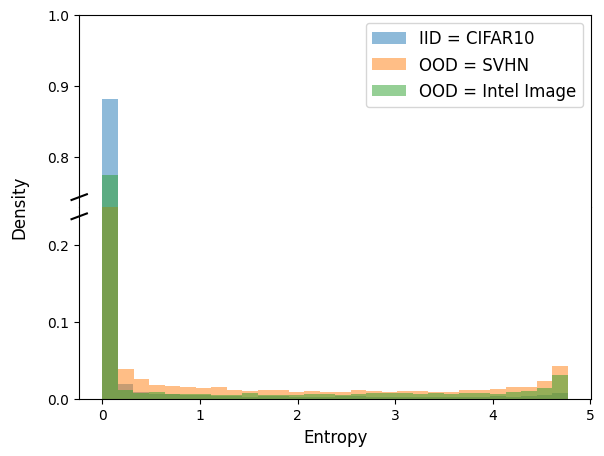

In [80]:
# x = np.linspace(0,10,100)
# x[75:] = np.linspace(40,42.5,25)

# y = np.sin(x)

f, (ax, ax2) = plt.subplots(2, 1, sharex=True, facecolor='w', )


bins = 30
ax.hist(entropy_y, bins, weights=np.ones(len(entropy_y)) / len(entropy_y), alpha=0.5, label='IID = CIFAR10')
ax2.hist(entropy_y, bins, weights=np.ones(len(entropy_y)) / len(entropy_y), alpha=0.5, label='IID = CIFAR10')
# plot the same data on both axes
# ax.plot(x, y)
# ax2.plot(x, y)

ax.hist(entropy(final_bet_p_svhn), bins , weights=np.ones(len(entropy_y)) / len(entropy_y), alpha=0.5, label='OOD = SVHN')
ax2.hist(entropy(final_bet_p_svhn), bins , weights=np.ones(len(entropy_y)) / len(entropy_y), alpha=0.5, label='OOD = SVHN')

ax.hist(entropy(final_bet_p_intel), bins , weights=np.ones(len(final_bet_p_intel)) / len(final_bet_p_intel), alpha=0.5, label='OOD = Intel Image')
ax2.hist(entropy(final_bet_p_intel), bins , weights=np.ones(len(final_bet_p_intel)) / len(final_bet_p_intel), alpha=0.5, label='OOD = Intel Image')


ax2.set_ylim(0, 0.25)
ax.set_ylim(0.73,1.0)

ax.set_yticks([0.8, 0.9,1.0])
ax2.set_yticks([0,0.1,0.2])

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax.yaxis.tick_left()
# ax.tick_params(labelright='off')
# ax2.yaxis.tick_right()

# This looks pretty good, and was fairly painless, but you can get that
# cut-out diagonal lines look with just a bit more work. The important
# thing to know here is that in axes coordinates, which are always
# between 0-1, spine endpoints are at these locations (0, 0), (0, 1),
# (1, 0), and (1, 1).  Thus, we just need to put the diagonals in the
# appropriate corners of each of our axes, and so long as we use the
# right transform and disable clipping.

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (0.05-d, 0.05+d), **kwargs)
# ax.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (0.95-d, 0.95+d), **kwargs)
# ax2.plot((-d, +d), (1-d, 1+d), **kwargs)
# ax2.plot((-d, +d), (-d, +d), **kwargs)

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0)

ax.legend(prop = { "size": 12 })

ax.set_ylabel("Density", fontsize=12)
ax.yaxis.set_label_coords(-0.1,0)

ax2.set_xlabel("Entropy", fontsize=12)
# plt.savefig("iid_ood_shift_kmnist.pdf", format="pdf", bbox_inches="tight")

plt.show()

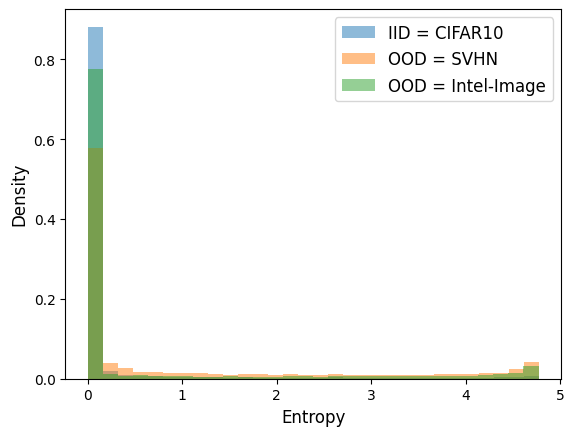

In [79]:
f, ax = plt.subplots(1, 1, sharex=True, facecolor='w', )


bins = 30
ax.hist(entropy_y, bins, weights=np.ones(len(entropy_y)) / len(entropy_y), alpha=0.5, label='IID = CIFAR10')
#ax.hist(entropy_y, bins, weights=np.ones(len(entropy_y)) / len(entropy_y), alpha=0.5, label='IID = CIFAR10')
# plot the same data on both axes
# ax.plot(x, y)
# ax2.plot(x, y)

ax.hist(entropy(final_bet_p_svhn), bins , weights=np.ones(len(entropy_y)) / len(entropy_y), alpha=0.5, label='OOD = SVHN')
#ax.hist(entropy(final_bet_p_svhn), bins , weights=np.ones(len(entropy_y)) / len(entropy_y), alpha=0.5, label='OOD = SVHN')

ax.hist(entropy(final_bet_p_intel), bins , weights=np.ones(len(final_bet_p_intel)) / len(final_bet_p_intel), alpha=0.5, label='OOD = Intel-Image')
#ax.hist(entropy(final_bet_p_intel), bins , weights=np.ones(len(final_bet_p_intel)) / len(final_bet_p_intel), alpha=0.5, label='OOD = Intel-Image')

ax.legend(prop = { "size": 12 })

ax.set_ylabel("Density", fontsize=12)
#ax.yaxis.set_label_coords(0.1,0)

ax.set_xlabel("Entropy", fontsize=12)
#plt.savefig("plots saved/iid_ood_shift_cifar10.pdf", format="pdf", bbox_inches="tight")

plt.show()

### ENTROPY OOD COMPARISON

In [111]:
test_preds_cifar10_lbbnn = np.load("/home/shireen/RS-CNN/LB-BNN/cifar10_results/cifar10_iid/lbbnn_cifar10_iid_preds.npy")
test_preds_cifar10_enn = np.load("/home/shireen/RS-CNN/ENN/enn_preds/enn_preds/cifar10_iid/enn_preds_cifar10_iid.npy")
test_preds_svhn_lbbnn = np.load("/home/shireen/RS-CNN/LB-BNN/cifar10_results/svhn/lbbnn_svhn_preds.npy")
test_preds_svhn_enn = np.load("/home/shireen/RS-CNN/ENN/enn_preds/enn_preds/svhn_ood/enn_preds_svhn_ood.npy")
test_preds_intel_lbbnn = np.load("/home/shireen/RS-CNN/LB-BNN/cifar10_results/intel_image/lbbnn_intel_image_32_preds (1).npy")
test_preds_intel_enn = np.load("/home/shireen/RS-CNN/ENN/enn_preds/enn_preds/intel_image_ood/enn_preds_intel_image_ood.npy")

FileNotFoundError: [Errno 2] No such file or directory: '/home/shireen/RS-CNN/LB-BNN/cifar10_results/cifar10_iid/lbbnn_cifar10_iid_preds.npy'

In [ ]:
test_preds_cifar10_enn.shape

(2, 10000, 10)

In [ ]:
from scipy.special import softmax

test_preds_cifar10_enn = np.mean(test_preds_cifar10_enn, axis=0)
test_preds_cifar10_enn = softmax(test_preds_cifar10_enn, axis=-1)

test_preds_svhn_enn = np.mean(test_preds_svhn_enn, axis=0)
test_preds_svhn_enn = softmax(test_preds_svhn_enn, axis=-1)

test_preds_intel_enn = np.mean(test_preds_intel_enn, axis=0)
test_preds_intel_enn = softmax(test_preds_intel_enn, axis=-1)

In [91]:
## No alpha beta
print(f"Entropy of RS-CNN on CIFAR10 (IID) = {round(np.mean(entropy_y), 4)} +/- {round(np.std(entropy_y), 4)}")
print(f"Entropy of RS-CNN on SVHN (OOD) = {round(np.mean(entropy(final_bet_p_svhn)), 4)} +/- {round(np.std(entropy(final_bet_p_svhn)), 4)}")
print(f"Entropy of RS-CNN on Intel (OOD) = {round(np.mean(entropy(final_bet_p_intel)), 4)} +/- {round(np.std(entropy(final_bet_p_intel)), 4)}")

Entropy of RS-CNN on CIFAR10 (IID) = 0.0854 +/- 0.3099
Entropy of RS-CNN on SVHN (OOD) = 1.1029 +/- 1.0733
Entropy of RS-CNN on Intel (OOD) = 1.006 +/- 0.9724


In [72]:
# ## FULL 1024 sets
# print(f"Entropy of RS-CNN on CIFAR10 (IID) = {round(np.mean(entropy_y), 4)} +/- {round(np.std(entropy_y), 4)}")
# print(f"Entropy of RS-CNN on SVHN (OOD) = {round(np.mean(entropy(final_bet_p_svhn)), 4)} +/- {round(np.std(entropy(final_bet_p_svhn)), 4)}")
# print(f"Entropy of RS-CNN on Intel (OOD) = {round(np.mean(entropy(final_bet_p_intel)), 4)} +/- {round(np.std(entropy(final_bet_p_intel)), 4)}")

In [ ]:
print(f"Entropy of RS-CNN on CIFAR10 (IID) = {round(np.mean(entropy_y), 4)} +/- {round(np.std(entropy_y), 4)}")
print(f"Entropy of RS-CNN on SVHN (OOD) = {round(np.mean(entropy(final_bet_p_svhn)), 4)} +/- {round(np.std(entropy(final_bet_p_svhn)), 4)}")
print(f"Entropy of RS-CNN on Intel (OOD) = {round(np.mean(entropy(final_bet_p_intel)), 4)} +/- {round(np.std(entropy(final_bet_p_intel)), 4)}")

Entropy of RS-CNN on CIFAR10 (IID) = 0.0883 +/- 0.3095
Entropy of RS-CNN on SVHN (OOD) = 1.1313 +/- 0.8547
Entropy of RS-CNN on Intel (OOD) = 1.5427 +/- 0.7386


In [ ]:
print(f"Entropy of LB-BNN on CIFAR10 (IID) = {round(np.mean(entropy(test_preds_cifar10_lbbnn)), 4)} +/- {round(np.std(entropy(test_preds_cifar10_lbbnn)), 4)}")
print(f"Entropy of LB-BNN on SVHN (OOD) = {round(np.mean(entropy(test_preds_svhn_lbbnn)), 4)} +/- {round(np.std(test_preds_svhn_lbbnn), 4)}")
print(f"Entropy of LB-BNN on Intel (OOD) = {round(np.mean(entropy(test_preds_intel_lbbnn)), 4)} +/- {round(np.std(entropy(test_preds_intel_lbbnn)), 4)}")

Entropy of LB-BNN on CIFAR10 (IID) = 0.19179999828338623 +/- 0.41280001401901245
Entropy of LB-BNN on SVHN (OOD) = 0.8288999795913696 +/- 0.24379999935626984
Entropy of LB-BNN on Intel (OOD) = 0.763700008392334 +/- 0.7221999764442444


In [ ]:
print(f"Entropy of ENN on CIFAR10 (IID) = {round(np.mean(entropy(test_preds_cifar10_enn)), 4)} +/- {round(np.std(entropy(test_preds_cifar10_enn)), 4)} ")
print(f"Entropy of ENN on SVHN (OOD) = {round(np.mean(entropy(test_preds_svhn_enn)), 4)} +/- {round(np.std(entropy(test_preds_svhn_enn)), 4)}")
print(f"Entropy of ENN on Intel (OOD) = {round(np.mean(entropy(test_preds_intel_enn)), 4)} +/- {round(np.std(entropy(test_preds_intel_enn)), 4)}")

Entropy of ENN on CIFAR10 (IID) = 0.12680000066757202 +/- 0.3237999975681305 
Entropy of ENN on SVHN (OOD) = 0.8877000212669373 +/- 0.51419997215271
Entropy of ENN on Intel (OOD) = 0.6004999876022339 +/- 0.5787000060081482


In [ ]:
test_preds_svhn_cnn = model.predict(x_test_svhn)
test_preds_intel_cnn = model.predict(x_test_intel)[:3000]
print(f"Entropy of CNN on CIFAR10 (IID) = {round(np.mean(entropy(test_preds_org)), 4)} +/- {round(np.std(entropy(test_preds_org)), 4)} ")
print(f"Entropy of CNN on SVHN (OOD) = {round(np.mean(entropy(test_preds_svhn_cnn)), 4)} +/- {round(np.std(entropy(test_preds_svhn_cnn)), 4)}")
print(f"Entropy of CNN on Intel (OOD) = {round(np.mean(entropy(test_preds_intel_cnn)), 4)} +/- {round(np.std(entropy(test_preds_intel_cnn)), 4)}")

313/313 [==============================] - 10s 32ms/step
Entropy of CNN on CIFAR10 (IID) = 0.11460000276565552 +/- 0.30480000376701355 
Entropy of CNN on SVHN (OOD) = 0.9301000237464905 +/- 0.6107000112533569
Entropy of CNN on Intel (OOD) = 0.7217000126838684 +/- 0.6801999807357788


In [73]:
confidence = np.max(final_bet_p, axis=1)
confidence_svhn = np.max(final_bet_p_svhn, axis=1)
confidence_intel = np.max(final_bet_p_intel, axis=1)

NameError: name 'test_preds_svhn_lbbnn' is not defined

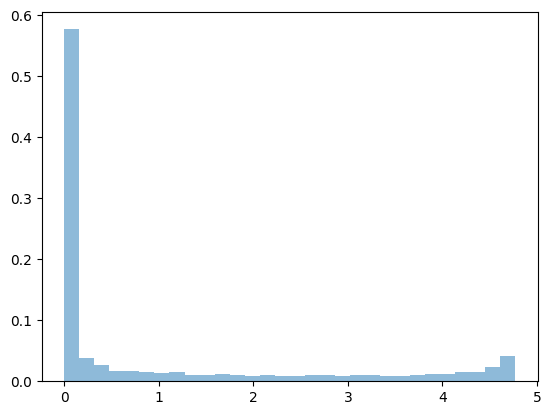

In [83]:
f, ax = plt.subplots(1, 1, sharex=True, facecolor='w', )


bins = 30
ax.hist(entropy(final_bet_p_svhn), bins, weights=np.ones(len(entropy(final_bet_p_svhn))) / len(entropy(final_bet_p_svhn)), alpha=0.5, label='RS-CNN')
#ax.hist(entropy_y, bins, weights=np.ones(len(entropy_y)) / len(entropy_y), alpha=0.5, label='IID = CIFAR10')
# plot the same data on both axes
# ax.plot(x, y)
# ax2.plot(x, y)

ax.hist(entropy(test_preds_svhn_lbbnn), bins , weights=np.ones(len(entropy(test_preds_svhn_lbbnn))) / len(entropy(test_preds_svhn_lbbnn)), alpha=0.5, label='LB-BNN')
#ax.hist(entropy(final_bet_p_svhn), bins , weights=np.ones(len(entropy_y)) / len(entropy_y), alpha=0.5, label='OOD = SVHN')

ax.hist(entropy(test_preds_svhn_enn), bins , weights=np.ones(len(entropy(test_preds_svhn_enn))) / len(entropy(test_preds_svhn_enn)), alpha=0.5, label='ENN')
#ax.hist(entropy(final_bet_p_intel), bins , weights=np.ones(len(final_bet_p_intel)) / len(final_bet_p_intel), alpha=0.5, label='OOD = Intel-Image')

ax.legend(prop = { "size": 12 })

ax.set_ylabel("Density", fontsize=12)
#ax.yaxis.set_label_coords(0.1,0)

ax.set_xlabel("Entropy", fontsize=12)
# plt.savefig("plots saved/iid_ood_shift_cifar10.pdf", format="pdf", bbox_inches="tight")

plt.show()

NameError: name 'test_preds_svhn_lbbnn' is not defined

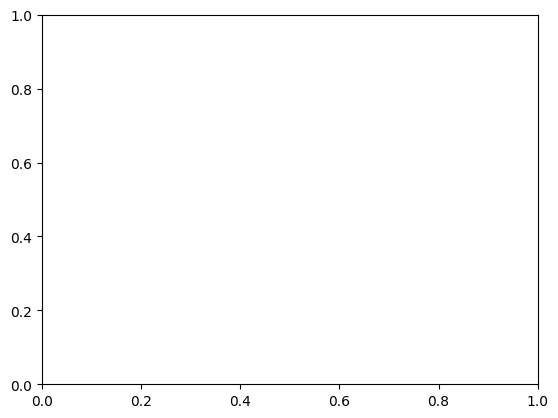

In [84]:
f, ax = plt.subplots(1, 1, sharex=True, facecolor='w', )

ax.hist(entropy(test_preds_svhn_lbbnn), bins=20, alpha = 0.5, weights=np.ones(len(entropy(test_preds_svhn_lbbnn))) / len(entropy(test_preds_svhn_lbbnn)))
ax.hist(entropy(test_preds_svhn_enn), bins=20, alpha = 0.5, weights=np.ones(len(entropy(test_preds_svhn_enn))) / len(entropy(test_preds_svhn_enn)))
ax.hist(entropy(final_bet_p_svhn), bins=20,  alpha = 0.5,weights=np.ones(len(entropy(final_bet_p_svhn))) / len(entropy(final_bet_p_svhn)))
plt.title("Entropy Distribution")
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.legend()
plt.show()

/tmp/ipykernel_61777/3810300036.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/tmp/ipykernel_61777/3810300036.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/tmp/ipykernel_61777/3810300036.py:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code 

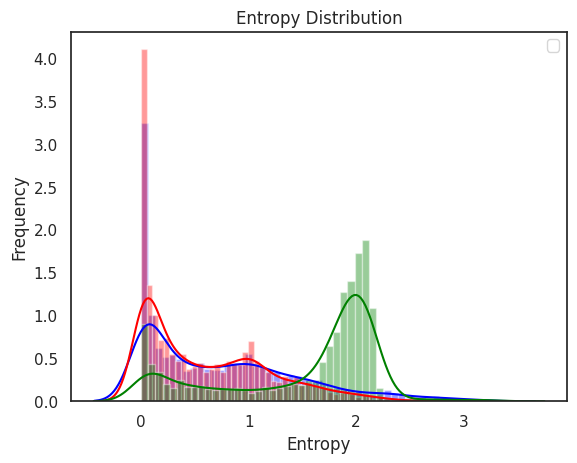

In [ ]:
sns.distplot(entropy(test_preds_intel_lbbnn), bins=50, color='blue')
sns.distplot(entropy(test_preds_intel_enn), bins=50, color='red')
sns.distplot(entropy(final_bet_p_intel), bins=50, color='green')
plt.title("Entropy Distribution")
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### OOD (AUROC)

In [73]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

def calculate_metrics(uncertainty_iid, uncertainty_ood):
    uncertainties = np.concatenate((uncertainty_iid, uncertainty_ood))
    
    in_labels = np.zeros(uncertainty_iid.shape[0])
    ood_labels = np.ones(uncertainty_ood.shape[0])
    
    # if confidence:
    #     in_labels = 1 - in_labels
    #     ood_labels = 1 - ood_labels
    
    labels = np.concatenate((in_labels, ood_labels))
    
    fpr, tpr, thresholds = roc_curve(labels, uncertainties)
    auroc = roc_auc_score(labels, uncertainties)
    precision, recall, prc_thresholds = precision_recall_curve(labels, uncertainties)
    
    auprc = average_precision_score(labels, uncertainties)
    
    return (fpr, tpr, thresholds), (precision, recall, prc_thresholds), auroc, auprc
metrics_data = {}

In [109]:
def evaluate_metrics(model_name, dataset_name, labels, predictions):
    (fpr, tpr, thresholds), (precision, recall, prc_thresholds), auroc, auprc = calculate_metrics(labels, predictions)
    
    if dataset_name not in metrics_data:
        metrics_data[dataset_name] = {}
    
    metrics_data[dataset_name][model_name] = {
        'AUROC': auroc,
        'AUPRC': auprc,
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds,
        'precision': precision,
        'recall': recall,
        'prc_thresholds': prc_thresholds     
    }

# Evaluate metrics for SVHN
evaluate_metrics("RS-CNN", "SVHN", entropy_y, entropy(final_bet_p_svhn))
# evaluate_metrics("LB-BNN", "SVHN", entropy(test_preds_cifar10_lbbnn), entropy(test_preds_svhn_lbbnn))
# evaluate_metrics("ENN", "SVHN", entropy(test_preds_cifar10_enn), entropy(test_preds_svhn_enn))
# evaluate_metrics("CNN", "SVHN", entropy(test_preds_org), entropy(test_preds_svhn_cnn))

# Evaluate metrics for INTEL
evaluate_metrics("RS-CNN", "Intel Image", entropy_y[3000:6000], entropy(final_bet_p_intel[:3000]))
# evaluate_metrics("LB-BNN", "Intel Image", entropy(test_preds_cifar10_lbbnn), entropy(test_preds_intel_lbbnn))
# evaluate_metrics("ENN", "Intel Image", entropy(test_preds_cifar10_enn), entropy(test_preds_intel_enn))
# evaluate_metrics("CNN", "Intel Image", entropy(test_preds_org), entropy(test_preds_intel_cnn[:3000]))

In [110]:
########### FULL 1024 sets   /no alpha beta
for dataset_name, models in metrics_data.items():
    print(f"------------{dataset_name}------------")
    for model_name, metrics in models.items():
        print(f"{model_name} - \t AUROC: {metrics['AUROC']:.6f}\tAUPRC: {metrics['AUPRC']:.6f}")

------------SVHN------------
RS-CNN - 	 AUROC: 0.924857	AUPRC: 0.914954
------------Intel Image------------
RS-CNN - 	 AUROC: 0.906265	AUPRC: 0.889065


In [ ]:
for dataset_name, models in metrics_data.items():
    print(f"------------{dataset_name}------------")
    for model_name, metrics in models.items():
        print(f"{model_name} - \t AUROC: {metrics['AUROC']:.6f}\tAUPRC: {metrics['AUPRC']:.6f}")

------------SVHN------------
RS-CNN - 	 AUROC: 0.945844	AUPRC: 0.934338
LB-BNN - 	 AUROC: 0.881394	AUPRC: 0.819594
ENN - 	 AUROC: 0.927636	AUPRC: 0.890482
CNN - 	 AUROC: 0.931067	AUPRC: 0.909996
------------Intel Image------------
RS-CNN - 	 AUROC: 0.973032	AUPRC: 0.906899
LB-BNN - 	 AUROC: 0.822053	AUPRC: 0.551689
ENN - 	 AUROC: 0.856737	AUPRC: 0.580896
CNN - 	 AUROC: 0.880196	AUPRC: 0.666207


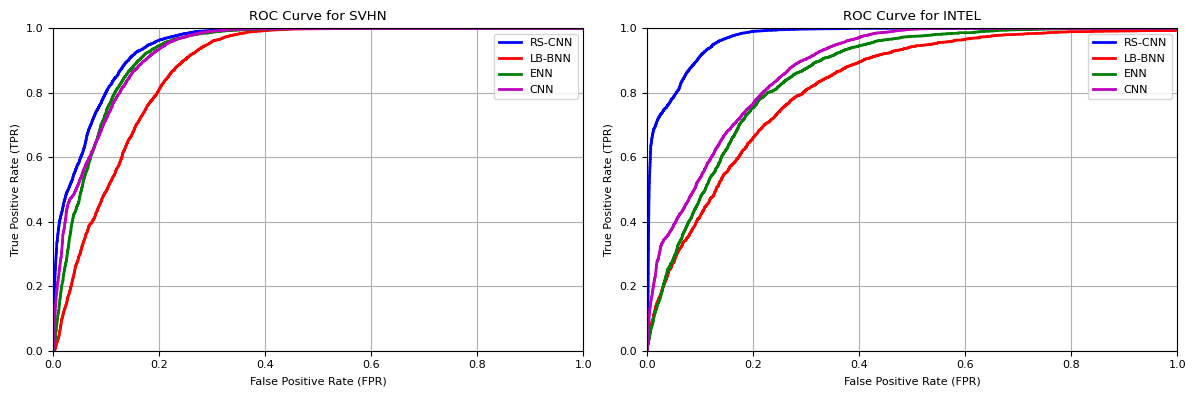

In [ ]:
datasets = ["SVHN", "INTEL"]
models = ["RS-CNN", "LB-BNN", "ENN", "CNN"]
colors = ['b', 'r', 'g', 'm']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, dataset in enumerate(datasets):
    ax = axes[i]
    ax.set_title(f'ROC Curve for {dataset}')
    ax.set_xlabel('False Positive Rate (FPR)')
    ax.set_ylabel('True Positive Rate (TPR)')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.grid(True)

    for j, model_name in enumerate(models):
        fpr = metrics_data[dataset][model_name]["fpr"]
        tpr = metrics_data[dataset][model_name]["tpr"]
        ax.plot(fpr, tpr, color=colors[j], linestyle='-', linewidth=2, label=f'{model_name}')

    ax.legend()

plt.tight_layout()
plt.show()

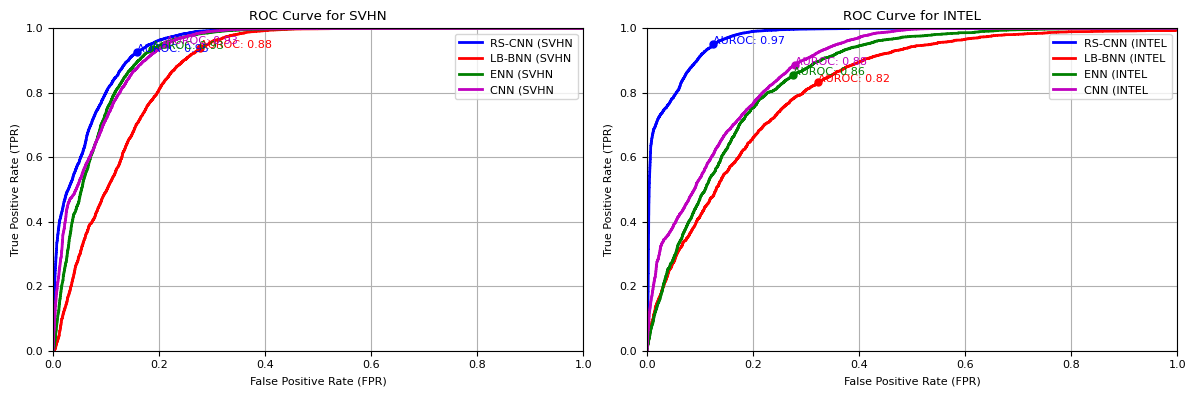

In [ ]:
datasets = ["SVHN", "INTEL"]
models = ["RS-CNN", "LB-BNN", "ENN", "CNN"]
colors = ['b', 'r', 'g', 'm']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, dataset in enumerate(datasets):
    ax = axes[i]
    ax.set_title(f'ROC Curve for {dataset}')
    ax.set_xlabel('False Positive Rate (FPR)')
    ax.set_ylabel('True Positive Rate (TPR)')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.grid(True)

    for j, model in enumerate(models):
        fpr = metrics_data[dataset][model]["fpr"]
        tpr = metrics_data[dataset][model]["tpr"]
        auroc = metrics_data[dataset][model]["AUROC"]
        ax.plot(fpr, tpr, color=colors[j], linestyle='-', linewidth=2, label=f'{model} ({dataset}')
        
        # Plot AUROC as a point with the same color
        auroc_index = np.argmax(tpr - fpr)
        ax.plot(fpr[auroc_index], tpr[auroc_index], marker='o', markersize=5, color=colors[j])
        
        # Set the color of AUROC label
        ax.text(fpr[auroc_index], tpr[auroc_index], f'AUROC: {auroc:.2f}', fontsize=8, color=colors[j])

    ax.legend()

plt.tight_layout()
plt.show()

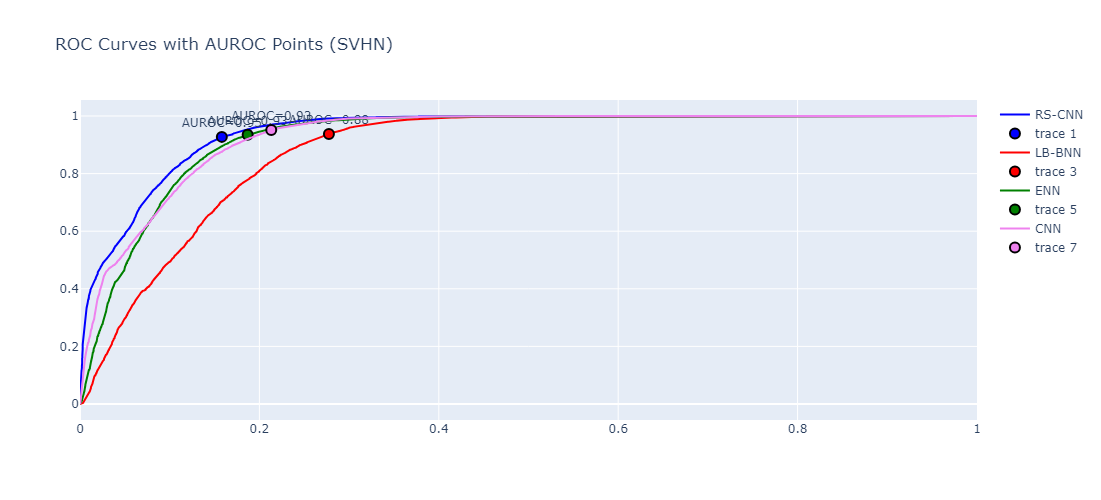

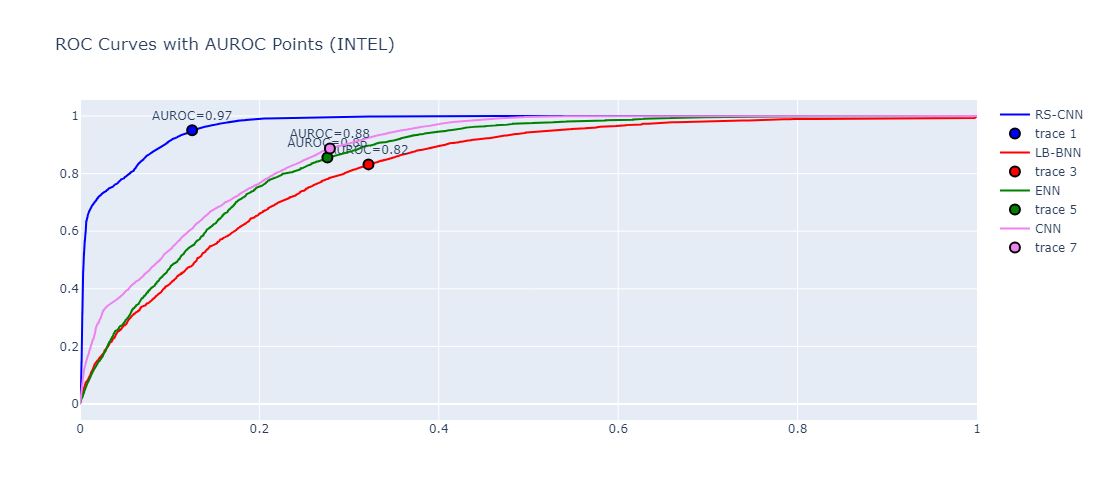

In [ ]:
import plotly.graph_objects as go

datasets = ["SVHN", "INTEL"]
models = ["RS-CNN", "LB-BNN", "ENN", "CNN"]
colors = ['blue', 'red', 'green', 'violet']

fig_svhn = go.Figure()
fig_intel = go.Figure()

figs = [fig_svhn, fig_intel]

# Define the width and height of the plots
plot_width = 800
plot_height = 500

for dataset_idx, dataset in enumerate(datasets):
    fig = figs[dataset_idx]
    
    for model_idx, model in enumerate(models):
        color = colors[model_idx]

        fpr = metrics_data[dataset][model]["fpr"]
        tpr = metrics_data[dataset][model]["tpr"]
        auroc = metrics_data[dataset][model]["AUROC"]

        fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'{model}', line=dict(color=color)))
        
        auroc_index = np.argmax(tpr - fpr)
        fig.add_trace(go.Scatter(x=[fpr[auroc_index]], y=[tpr[auroc_index]],
                                 mode='markers+text',
                                 marker=dict(size=10, color=color, line=dict(color='black', width=2)),
                                 text=[f'AUROC={auroc:.2f}'],
                                 textposition="top center"))

    # Set title for the figure
    fig.update_layout(title_text=f'ROC Curves with AUROC Points ({dataset})')
    
    # Set the width and height of the plot
    fig.update_layout(width=plot_width, height=plot_height)

# Show the figures
fig_svhn.show()
fig_intel.show()

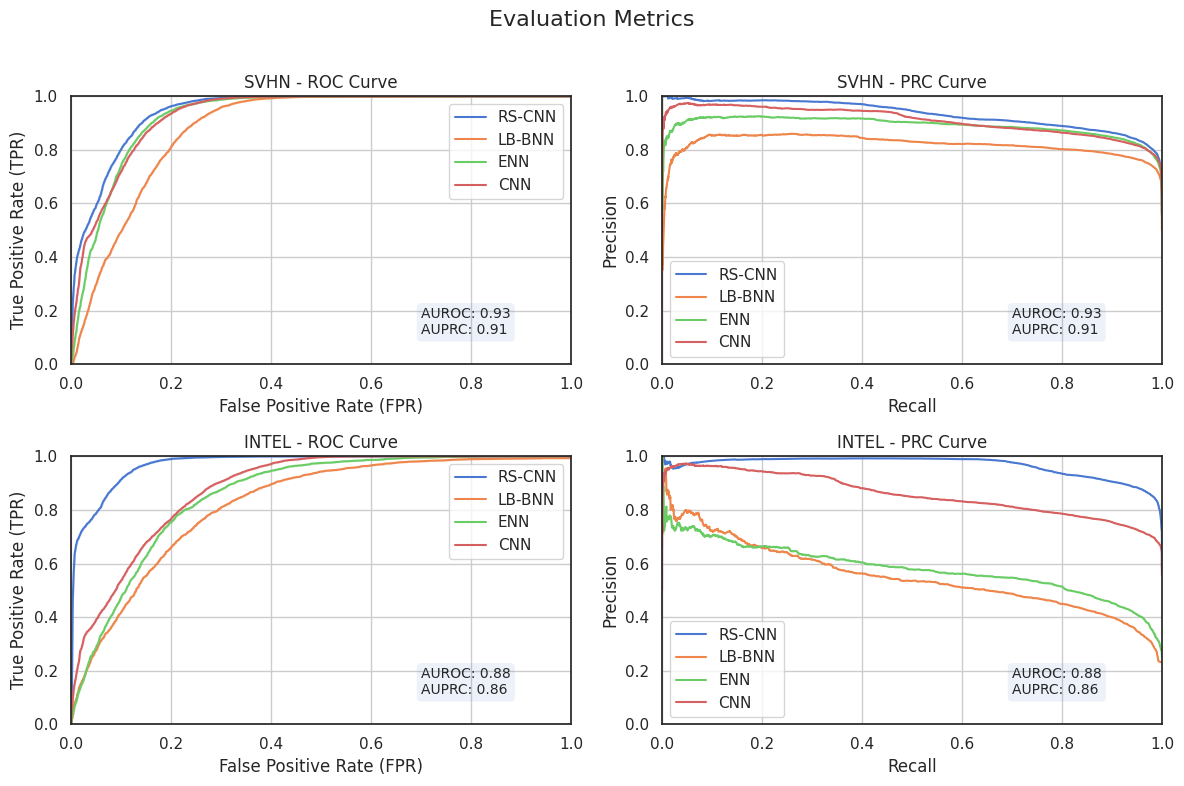

In [ ]:
import seaborn as sns
from cycler import cycler

# Set Seaborn style
sns.set(style="white", palette="muted")

# Sample data
datasets = ["SVHN", "INTEL"]
models = ["RS-CNN", "LB-BNN", "ENN", "CNN"]
muted_colors = sns.color_palette("muted", n_colors=len(models))

# Create subplots with two rows for each dataset
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Evaluation Metrics', fontsize=16)

for i, dataset in enumerate(datasets):
    for j, metric in enumerate(["ROC Curve", "PRC Curve"]):
        ax = axes[i, j]
        ax.set_title(f'{dataset} - {metric}')
        ax.set_xlabel('False Positive Rate (FPR)') if metric == "ROC Curve" else ax.set_xlabel('Recall')
        ax.set_ylabel('True Positive Rate (TPR)') if metric == "ROC Curve" else ax.set_ylabel('Precision')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.0])
        ax.grid(True)  # Remove the grid

        # Apply milder tones to the line styles
        ax.set_prop_cycle(cycler('color', muted_colors))

        for k, model in enumerate(models):
            fpr = metrics_data[dataset][model]["fpr"]
            tpr = metrics_data[dataset][model]["tpr"]
            precision = metrics_data[dataset][model]["precision"]
            recall = metrics_data[dataset][model]["recall"]
            auroc = metrics_data[dataset][model]["AUROC"]
            auprc = metrics_data[dataset][model]["AUPRC"]

            if metric == "ROC Curve":
                sns.lineplot(x=fpr, y=tpr, label=f'{model}', ax=ax)
            else:
                sns.lineplot(x=recall, y=precision, label=f'{model}', ax=ax)

            # Annotate with AUROC and AUPRC values
        
            if k == len(models) - 1:
                ax.text(0.7, 0.1, f'AUROC: {auroc:.2f}\nAUPRC: {auprc:.2f}', transform=ax.transAxes, fontsize=10,
                        verticalalignment='bottom', bbox=dict(boxstyle="round", alpha=0.1))

        ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

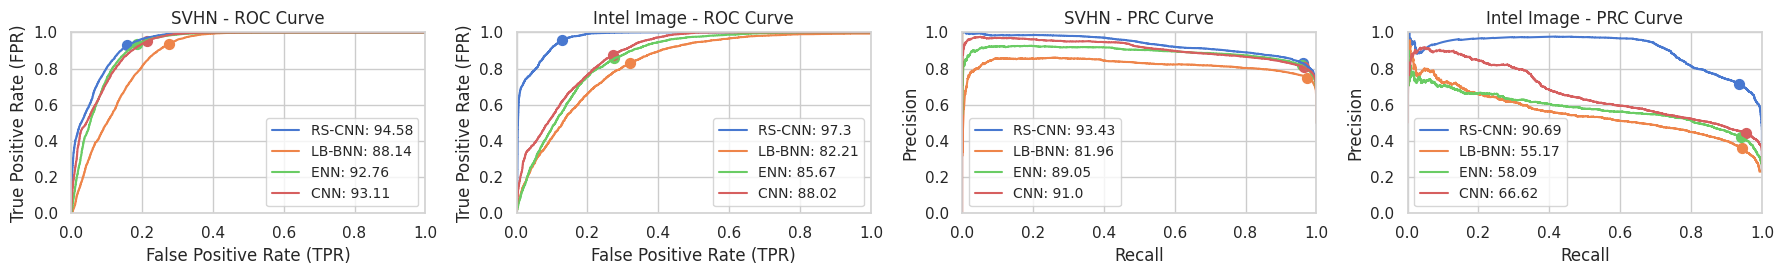

In [ ]:
import seaborn as sns
from cycler import cycler

# Set Seaborn style
sns.set(style="white", palette="muted")

# Sample data
datasets = ["SVHN", "Intel Image"]
models = ["RS-CNN", "LB-BNN", "ENN", "CNN"]
muted_colors = sns.color_palette("muted", n_colors=len(models))

# Create subplots with two rows for each dataset
fig, axes = plt.subplots(1, 4, figsize=(18, 3))
# fig.suptitle('Evaluation Metrics', fontsize=16)
legend_locs = ['lower right']*2+['lower left']*2

for j, metric in enumerate(["ROC Curve", "PRC Curve"]):
    for i, dataset in enumerate(datasets):
        
        ax = axes[(j*2)+i]
        ax.set_title(f'{dataset} - {metric}')
        ax.set_xlabel('False Positive Rate (TPR)') if metric == "ROC Curve" else ax.set_xlabel('Recall')
        ax.set_ylabel('True Positive Rate (FPR)') if metric == "ROC Curve" else ax.set_ylabel('Precision')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.0])
        ax.grid(True)  # Remove the grid

        # Apply milder tones to the line styles
        ax.set_prop_cycle(cycler('color', muted_colors))

        for k, model in enumerate(models):
            fpr = metrics_data[dataset][model]["fpr"]
            tpr = metrics_data[dataset][model]["tpr"]
            precision = metrics_data[dataset][model]["precision"]
            recall = metrics_data[dataset][model]["recall"]
            auroc = metrics_data[dataset][model]["AUROC"]*100
            auprc = metrics_data[dataset][model]["AUPRC"]*100

            if metric == "ROC Curve":
                # line = sns.lineplot(x=fpr, y=tpr, label=f'{model}', ax=ax
                ax.plot(fpr, tpr, label=f'{model}: {np.round(auroc,2)}')
                auroc_index = np.argmax(tpr - fpr)
                ax.scatter(fpr[auroc_index], tpr[auroc_index], marker='o', s=50)

            else:
                # line = sns.lineplot(x=recall, y=precision, label=f'{model}', ax=ax)
                ax.plot(recall, precision, label=f'{model}: {np.round(auprc,2)}')
                auprc_index = np.argmax(precision + recall)
                ax.scatter(recall[auprc_index], precision[auprc_index], marker='o', s=50)

        # # Annotate with AUROC and AUPRC values
        # if metric == "ROC Curve":
        #     auroc_texts = [f'{model}: {auroc:.2f}' for model, auroc in zip(models, [metrics_data[dataset][model]["AUROC"] for model in models])]
        #     ax.text(0.5, -0.15, '\n'.join(auroc_texts), transform=ax.transAxes, fontsize=10,
        #             verticalalignment='bottom', bbox=dict(boxstyle="round", alpha=0.1))

        # else:
        #     auprc_texts = [f'{model}: {auprc:.2f}' for model, auprc in zip(models, [metrics_data[dataset][model]["AUPRC"] for model in models])]
        #     ax.text(0.5, -0.25, '\n'.join(auprc_texts), transform=ax.transAxes, fontsize=10,
        #             verticalalignment='bottom', bbox=dict(boxstyle="round", alpha=0.1))

        ax.legend(prop={'size': 10}, loc=legend_locs[(j*2)+i])
        ax.margins(x=0)
        for pos in ['right', 'top', 'bottom', 'left']: 
            ax.spines[pos].set_color("lightgray") 

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig("ROC_PRC_Curve.pdf", format="pdf", bbox_inches="tight")
plt.show()

KeyboardInterrupt: 

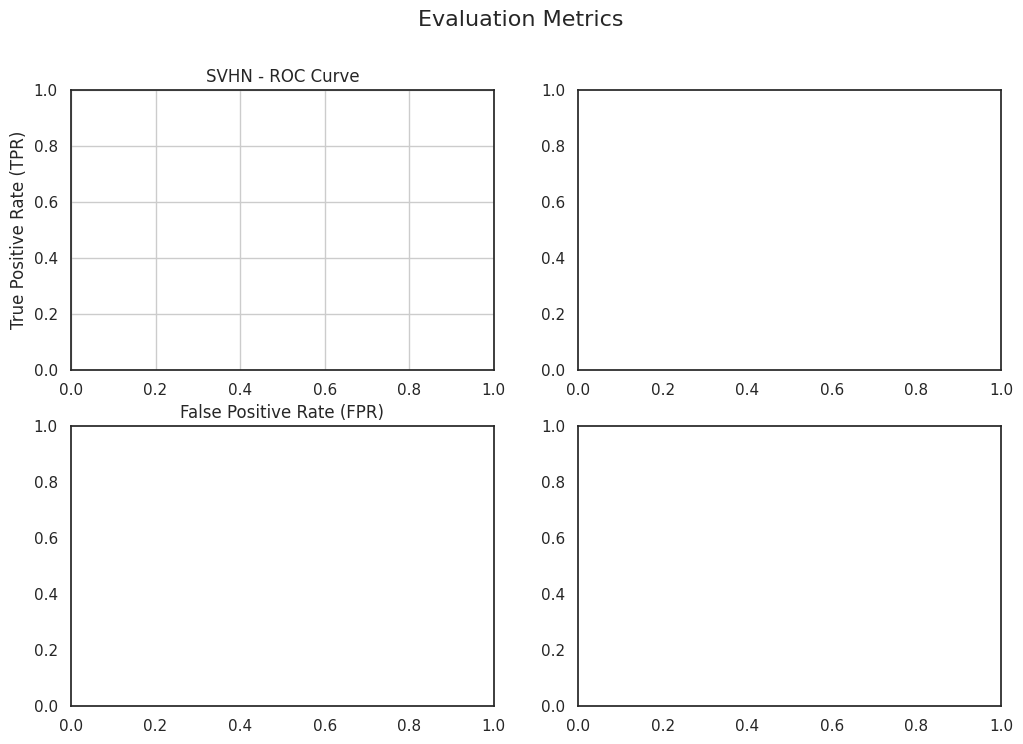

In [ ]:
import seaborn as sns
from cycler import cycler

# Set Seaborn style
sns.set(style="white", palette="muted")

# Sample data
datasets = ["SVHN", "INTEL"]
models = ["RS-CNN", "LB-BNN", "ENN", "CNN"]
muted_colors = sns.color_palette("muted", n_colors=len(models))

# Create subplots with two rows for each dataset
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Evaluation Metrics', fontsize=16)

for i, dataset in enumerate(datasets):
    for j, metric in enumerate(["ROC Curve", "PRC Curve"]):
        ax = axes[i, j]
        ax.set_title(f'{dataset} - {metric}')
        ax.set_xlabel('False Positive Rate (FPR)') if metric == "ROC Curve" else ax.set_xlabel('Recall')
        ax.set_ylabel('True Positive Rate (TPR)') if metric == "ROC Curve" else ax.set_ylabel('Precision')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.0])
        ax.grid(True)  # Remove the grid

        # Apply milder tones to the line styles
        ax.set_prop_cycle(cycler('color', muted_colors))

        for k, model in enumerate(models):
            fpr = metrics_data[dataset][model]["fpr"]
            tpr = metrics_data[dataset][model]["tpr"]
            precision = metrics_data[dataset][model]["precision"]
            recall = metrics_data[dataset][model]["recall"]
            auroc = metrics_data[dataset][model]["AUROC"]
            auprc = metrics_data[dataset][model]["AUPRC"]

            if metric == "ROC Curve":
                line = sns.lineplot(x=fpr, y=tpr, label=f'{model}', ax=ax)
                auroc_index = np.argmax(tpr - fpr)
                ax.scatter(fpr[auroc_index], tpr[auroc_index], marker='o', color=line.get_lines()[-1].get_color(), s=50)

            else:
                line = sns.lineplot(x=recall, y=precision, label=f'{model}', ax=ax)
                auprc_index = np.argmax(precision - recall)
                ax.scatter(recall[auprc_index], precision[auprc_index], marker='o', color=line.get_lines()[-1].get_color(), s=50)

        # Annotate with AUROC and AUPRC values
        if metric == "ROC Curve":
            auroc_texts = [f'{model}: {auroc:.2f}' for model, auroc in zip(models, [metrics_data[dataset][model]["AUROC"] for model in models])]
            ax.text(0.5, 1.05, '\n'.join(auroc_texts), transform=ax.transAxes, fontsize=10,
                    verticalalignment='bottom', bbox=dict(boxstyle="round", alpha=0.1))

        else:
            auprc_texts = [f'{model}: {auprc:.2f}' for model, auprc in zip(models, [metrics_data[dataset][model]["AUPRC"] for model in models])]
            ax.text(0.5, 1.05, '\n'.join(auprc_texts), transform=ax.transAxes, fontsize=10,
                    verticalalignment='bottom', bbox=dict(boxstyle="round", alpha=0.1))

        ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [112]:
import numpy as np

def expected_calibration_error(confidences, predictions, true_labels, num_bins=10):
    """
    Calculate Expected Calibration Error (ECE).

    Parameters:
    - confidences: List or array of confidence scores predicted by the model.
    - predictions: List or array of predicted class labels.
    - true_labels: List or array of true class labels.
    - num_bins: Number of bins for binning confidence scores.

    Returns:
    - ece: Expected Calibration Error.
    """
    # Ensure inputs are numpy arrays
    confidences = np.array(confidences)
    confidences = np.max(confidences, axis=1)
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)

    # Binning confidence scores
    bins = np.linspace(0, 1, num_bins + 1)
    bin_indices = np.digitize(confidences, bins, right=True)

    # Initialize variables to store bin-wise accuracy and confidence
    bin_accuracy = np.zeros(num_bins)
    bin_confidence = np.zeros(num_bins)

    weights = np.zeros(num_bins)

    # Populate bin-wise accuracy and confidence
    for i in range(1, num_bins + 1):
        bin_mask = (bin_indices == i)
        weights[i-1] = sum(bin_mask)
        if sum(bin_mask) != 0:
            bin_accuracy[i - 1] = np.mean(np.equal(predictions[bin_mask], true_labels[bin_mask]))
            # print(np.equal(predictions[bin_mask], true_labels[bin_mask]))
            bin_confidence[i - 1] = np.mean(confidences[bin_mask])

    # Calculate ECE
    # print(weights)
    # print(bin_accuracy)
    # print(bin_confidence)
    ece = np.sum(np.abs(bin_accuracy - bin_confidence) * (weights/len(true_labels)))

    return ece

In [113]:
##################### FULL set 1024
ece_value = expected_calibration_error(final_bet_p, np.argmax(final_bet_p, axis=-1), y_test, 5)
print(f"Expected Calibration Error (ECE): {ece_value:.4f}")

Expected Calibration Error (ECE): 0.0546


In [ ]:
ece_value = expected_calibration_error(final_bet_p, np.argmax(final_bet_p, axis=-1), y_test, 5)
print(f"Expected Calibration Error (ECE): {ece_value:.4f}")

Expected Calibration Error (ECE): 0.0484


In [ ]:
ece_value = expected_calibration_error(y_pred, np.argmax(y_pred, axis=-1), y_test, 5)
print(f"Expected Calibration Error (ECE): {ece_value:.4f}")

Expected Calibration Error (ECE): 0.0669


In [ ]:
ece_value = expected_calibration_error(test_preds_cifar10_lbbnn, np.argmax(test_preds_cifar10_lbbnn, axis=-1), y_test, 5)
print(f"Expected Calibration Error (ECE): {ece_value:.4f}")

Expected Calibration Error (ECE): 0.0585


In [ ]:
ece_value = expected_calibration_error(test_preds_cifar10_enn, np.argmax(test_preds_cifar10_enn, axis=-1), y_test, 5)
print(f"Expected Calibration Error (ECE): {ece_value:.4f}")

Expected Calibration Error (ECE): 0.0556


In [ ]:
import math

COUNT = "count"
CONF = "conf"
ACC = "acc"
BIN_ACC = "bin_acc"
BIN_CONF = "bin_conf"

def _bin_initializer(num_bins=10):
    bin_dict = {}
    for i in range(num_bins):
        bin_dict[i] = {}
        bin_dict[i][COUNT] = 0
        bin_dict[i][CONF] = 0
        bin_dict[i][ACC] = 0
        bin_dict[i][BIN_ACC] = 0
        bin_dict[i][BIN_CONF] = 0

    return bin_dict

def _populate_bins(confs, preds, labels, num_bins=10):

    bin_dict = _bin_initializer(num_bins)
    num_test_samples = len(confs)

    for i in range(0, num_test_samples):
        confidence = confs[i]
        prediction = preds[i]
        label = labels[i]
        binn = int(math.ceil(((num_bins * confidence) - 1)))
        bin_dict[binn][COUNT] = bin_dict[binn][COUNT] + 1
        bin_dict[binn][CONF] = bin_dict[binn][CONF] + confidence
        bin_dict[binn][ACC] = bin_dict[binn][ACC] + (1 if (label == prediction) else 0)

    for binn in range(0, num_bins):
        if bin_dict[binn][COUNT] == 0:
            bin_dict[binn][BIN_ACC] = 0
            bin_dict[binn][BIN_CONF] = 0
        else:
            bin_dict[binn][BIN_ACC] = float(bin_dict[binn][ACC]) / bin_dict[binn][COUNT]
            bin_dict[binn][BIN_CONF] = bin_dict[binn][CONF] / float(bin_dict[binn][COUNT])
    return bin_dict

def expected_calibration_error(confs, preds, labels, num_bins=10):
    bin_dict = _populate_bins(confs, preds, labels, num_bins)
    num_samples = len(labels)
    ece = 0
    for i in range(num_bins):
        bin_accuracy = bin_dict[i][BIN_ACC]
        bin_confidence = bin_dict[i][BIN_CONF]
        bin_count = bin_dict[i][COUNT]
        ece += (float(bin_count) / num_samples) * abs(bin_accuracy - bin_confidence)
    return ece

In [ ]:
test_preds_cifar10_enn.shape

(10000, 10)

In [ ]:
ece_value = expected_calibration_error(np.max(test_preds_cifar10_enn, axis=-1), np.argmax(test_preds_cifar10_enn, axis=-1), y_test, 5)
print(f"Expected Calibration Error (ECE): {ece_value:.4f}")

Expected Calibration Error (ECE): 0.0556


In [ ]:
def ece_score(py, y_test, n_bins=10):
    py = np.array(py)
    y_test = np.array(y_test)
    if y_test.ndim > 1:
        y_test = np.argmax(y_test, axis=1)
    py_index = np.argmax(py, axis=1)
    py_value = []
    for i in range(py.shape[0]):
        py_value.append(py[i, py_index[i]])
    py_value = np.array(py_value)
    acc, conf = np.zeros(n_bins), np.zeros(n_bins)
    Bm = np.zeros(n_bins)
    for m in range(n_bins):
        a, b = m / n_bins, (m + 1) / n_bins
        for i in range(py.shape[0]):
            if py_value[i] > a and py_value[i] <= b:
                Bm[m] += 1
                if py_index[i] == y_test[i]:
                    acc[m] += 1
                conf[m] += py_value[i]
        if Bm[m] != 0:
            acc[m] = acc[m] / Bm[m]
            conf[m] = conf[m] / Bm[m]
    ece = 0
    for m in range(n_bins):
        ece += Bm[m] * np.abs((acc[m] - conf[m]))
    return ece / sum(Bm)

In [ ]:
ece_value = ece_score(y_pred, y_test, 5)
print(f"Expected Calibration Error (ECE): {ece_value:.4f}")

Expected Calibration Error (ECE): 0.0669


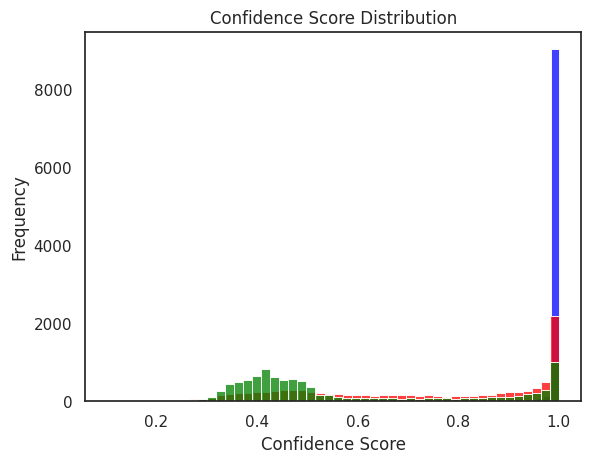

In [ ]:
sns.histplot(np.max(final_bet_p, axis=1), bins=50, color='blue')
sns.histplot(np.max(final_bet_p_svhn, axis=1), bins=50, color='red')
sns.histplot(np.max(final_bet_p_intel, axis=1), bins=50, color='green')
plt.title("Confidence Score Distribution")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.show()

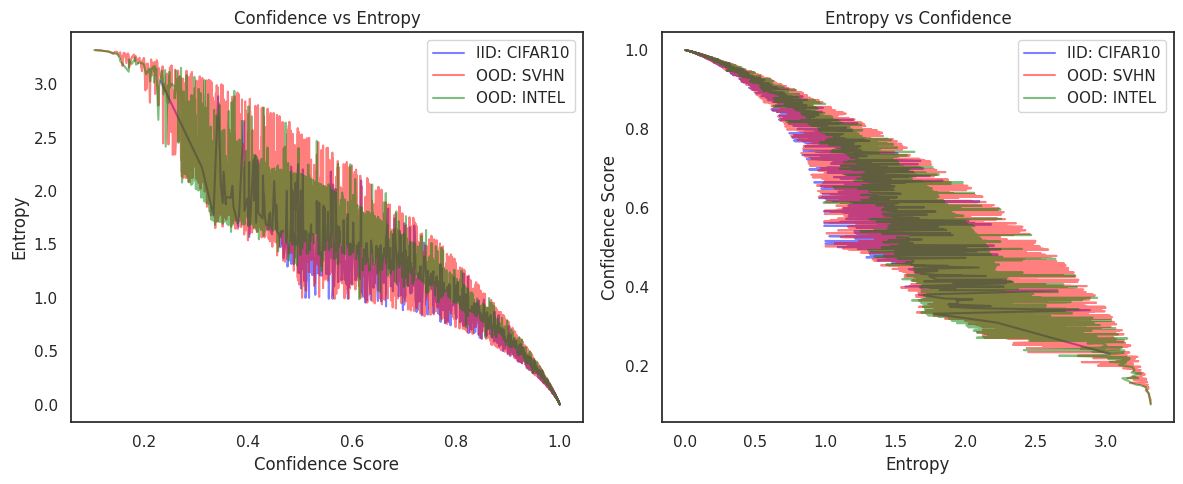

In [ ]:
sorted_indices = np.argsort(confidence)
sorted_indices_svhn = np.argsort(confidence_svhn)
sorted_indices_intel = np.argsort(confidence_intel)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confidence vs Entropy
axes[0].plot(confidence[sorted_indices], entropy_y[sorted_indices], color='blue', label='IID: CIFAR10', alpha=0.5)
axes[0].plot(confidence_svhn[sorted_indices_svhn], entropy(final_bet_p_svhn)[sorted_indices_svhn], color='red', label='OOD: SVHN', alpha=0.5)
axes[0].plot(confidence_intel[sorted_indices_intel], entropy(final_bet_p_intel)[sorted_indices_intel], color='green', label='OOD: INTEL', alpha=0.5)
axes[0].set_title("Confidence vs Entropy")
axes[0].set_xlabel("Confidence Score")
axes[0].set_ylabel("Entropy")
axes[0].legend()

# Entropy vs Confidence
axes[1].plot(entropy_y[sorted_indices], confidence[sorted_indices], color='blue', label='IID: CIFAR10', alpha=0.5)
axes[1].plot(entropy(final_bet_p_svhn)[sorted_indices_svhn], confidence_svhn[sorted_indices_svhn], color='red', label='OOD: SVHN', alpha=0.5)
axes[1].plot(entropy(final_bet_p_intel)[sorted_indices_intel], confidence_intel[sorted_indices_intel], color='green', label='OOD: INTEL', alpha=0.5)
axes[1].set_title("Entropy vs Confidence")
axes[1].set_ylabel("Confidence Score")
axes[1].set_xlabel("Entropy")
axes[1].legend()

plt.tight_layout()
plt.show()

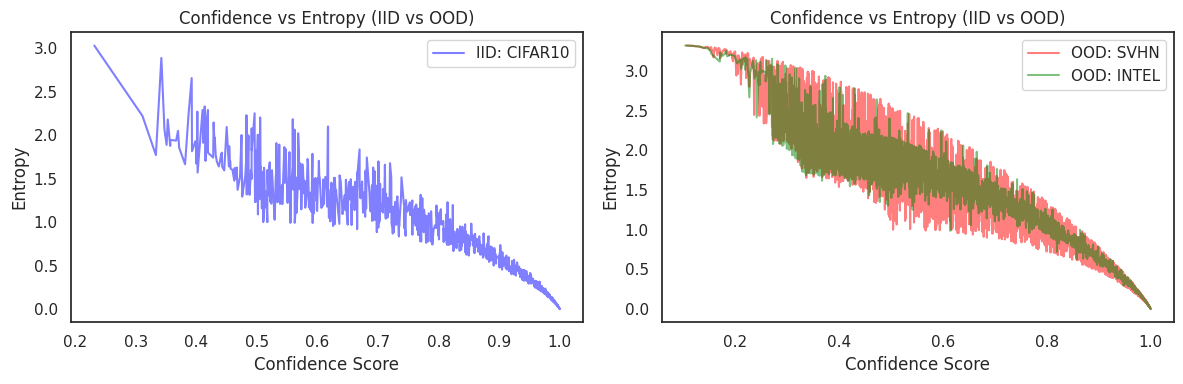

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(confidence[sorted_indices], entropy_y[sorted_indices], color='blue', label='IID: CIFAR10', alpha=0.5)
axs[0].set_title("Confidence vs Entropy (IID vs OOD)")
axs[0].set_xlabel("Confidence Score")
axs[0].set_ylabel("Entropy")
axs[0].legend()

axs[1].plot(confidence_svhn[sorted_indices_svhn], entropy(final_bet_p_svhn)[sorted_indices_svhn], color='red', label='OOD: SVHN', alpha=0.5)
axs[1].plot(confidence_intel[sorted_indices_intel], entropy(final_bet_p_intel)[sorted_indices_intel], color='green', label='OOD: INTEL', alpha=0.5)
axs[1].set_title("Confidence vs Entropy (IID vs OOD)")
axs[1].set_xlabel("Confidence Score")
axs[1].set_ylabel("Entropy")
axs[1].legend()

# axs[2].plot(confidence_intel[sorted_indices_intel], entropy(final_bet_p_intel)[sorted_indices_intel], color='green', label='OOD: INTEL', alpha=0.5)
# axs[2].set_title("Confidence vs Entropy (IID vs OOD)")
# axs[2].set_xlabel("Confidence Score")
# axs[2].set_ylabel("Entropy")
# axs[2].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


In [ ]:
x_test.shape, x_test_svhn.shape, x_test_intel.shape

((10000, 32, 32, 3), (10000, 32, 32, 3), (10000, 32, 32, 3))

In [ ]:
confidence_cnn = np.max(test_preds_org, axis=1)
confidence_svhn_cnn = np.max(test_preds_svhn_cnn, axis=1)
confidence_intel_cnn = np.max(test_preds_intel_cnn, axis=1)

In [95]:
confidence = np.max(final_bet_p, axis=1)
confidence_svhn = np.max(final_bet_p_svhn, axis=1)
confidence_intel = np.max(final_bet_p_intel, axis=1)

In [ ]:
confidence_lbbnn_cifar10 = np.max(test_preds_cifar10_lbbnn, axis=1)
confidence_lbbnn_svhn = np.max(test_preds_svhn_lbbnn, axis=1)
confidence_lbbnn_intel = np.max(test_preds_intel_lbbnn, axis=1)

In [ ]:
confidence_enn_cifar10 = np.max(test_preds_cifar10_enn, axis=1)
confidence_enn_svhn = np.max(test_preds_svhn_enn, axis=1)
confidence_enn_intel = np.max(test_preds_intel_enn, axis=1)

In [96]:
########################### FULL 1024 sets
print(f"Confidence of RS-CNN on CIFAR10 (IID) = {round(np.mean(confidence), 4)} +/- {round(np.std(confidence), 4)}")
print(f"Confidence of RS-CNN on SVHN (OOD) = {round(np.mean(confidence_svhn), 4)} +/- {round(np.std(confidence_svhn), 4)}")
print(f"Confidence of RS-CNN on Intel (OOD) = {round(np.mean(confidence_intel), 4)} +/- {round(np.std(confidence_intel), 4)}")

Confidence of RS-CNN on CIFAR10 (IID) = 0.979 +/- 0.0858
Confidence of RS-CNN on SVHN (OOD) = 0.7296 +/- 0.2832
Confidence of RS-CNN on Intel (OOD) = 0.7388 +/- 0.2767


In [ ]:
print(f"Confidence of RS-CNN on CIFAR10 (IID) = {round(np.mean(confidence), 4)} +/- {round(np.std(confidence), 4)}")
print(f"Confidence of RS-CNN on SVHN (OOD) = {round(np.mean(confidence_svhn), 4)} +/- {round(np.std(confidence_svhn), 4)}")
print(f"Confidence of RS-CNN on Intel (OOD) = {round(np.mean(confidence_intel), 4)} +/- {round(np.std(confidence_intel), 4)}")

Confidence of RS-CNN on CIFAR10 (IID) = 0.9784 +/- 0.0856
Confidence of RS-CNN on SVHN (OOD) = 0.7152 +/- 0.2451
Confidence of RS-CNN on Intel (OOD) = 0.5733 +/- 0.2331


In [ ]:
print(f"Confidence of LB-BNN on CIFAR10 (IID) = {round(np.mean(confidence_lbbnn_cifar10), 4)} +/- {round(np.std(confidence_lbbnn_cifar10), 4)}")
print(f"Confidence of LB-BNN on SVHN (OOD) = {round(np.mean(confidence_lbbnn_svhn), 4)} +/- {round(np.std(confidence_lbbnn_svhn), 4)}")
print(f"Confidence of LB-BNN on Intel (OOD) = {round(np.mean(confidence_lbbnn_intel), 4)} +/- {round(np.std(confidence_lbbnn_intel), 4)}")

Confidence of LB-BNN on CIFAR10 (IID) = 0.951200008392334 +/- 0.1200999990105629
Confidence of LB-BNN on SVHN (OOD) = 0.7817000150680542 +/- 0.18279999494552612
Confidence of LB-BNN on Intel (OOD) = 0.8109999895095825 +/- 0.20149999856948853


In [ ]:
print(f"Confidence of ENN on CIFAR10 (IID) = {round(np.mean(confidence_enn_cifar10), 4)} +/- {round(np.std(confidence_enn_cifar10), 4)}")
print(f"Confidence of ENN on SVHN (OOD) = {round(np.mean(confidence_enn_svhn), 4)} +/- {round(np.std(confidence_enn_svhn), 4)}")
print(f"Confidence of ENN on Intel (OOD) = {round(np.mean(confidence_enn_intel), 4)} +/- {round(np.std(confidence_enn_intel), 4)}")

Confidence of ENN on CIFAR10 (IID) = 0.9671000242233276 +/- 0.09790000319480896
Confidence of ENN on SVHN (OOD) = 0.7493000030517578 +/- 0.1826000064611435
Confidence of ENN on Intel (OOD) = 0.8392000198364258 +/- 0.18279999494552612


In [ ]:
print(f"Confidence of CNN on CIFAR10 (IID) = {round(np.mean(confidence_cnn), 4)} +/- {round(np.std(confidence_cnn), 4)}")
print(f"Confidence of CNN on SVHN (OOD) = {round(np.mean(confidence_svhn_cnn), 4)} +/- {round(np.std(confidence_svhn_cnn), 4)}")
print(f"Confidence of CNN on Intel (OOD) = {round(np.mean(confidence_intel_cnn), 4)} +/- {round(np.std(confidence_intel_cnn), 4)}")

Confidence of CNN on CIFAR10 (IID) = 0.9693999886512756 +/- 0.09399999678134918
Confidence of CNN on SVHN (OOD) = 0.762499988079071 +/- 0.1932000070810318
Confidence of CNN on Intel (OOD) = 0.8167999982833862 +/- 0.20350000262260437


In [ ]:
# np.savez("/home/shireen/RS-CNN/CIFAR10_ResNet50/saved_ResNet50/heatmaps.npz", confidence = confidence, confidence_svhn = confidence_svhn, confidence_intel = confidence_intel, entropy_y = entropy_y, entropy_svhn = entropy(final_bet_p_svhn), entropy_intel = entropy(final_bet_p_intel))

In [ ]:
# pppreds = np.load("/home/shireen/RS-CNN/CIFAR10_ResNet50/saved_ResNet50/heatmaps.npz")

In [ ]:
# confidence = pppreds["confidence"]
# confidence_svhn = pppreds["confidence_svhn"]
# confidence_intel = pppreds["confidence_intel"]
# entropy_y = pppreds["entropy_y"] 
# entropy_svhn = pppreds["entropy_svhn"]
# entropy_intel = pppreds["entropy_intel"]

In [94]:
entropy_y = entropy(final_bet_p)
entropy_svhn = entropy(final_bet_p_svhn)
entropy_intel = entropy(final_bet_p_intel)

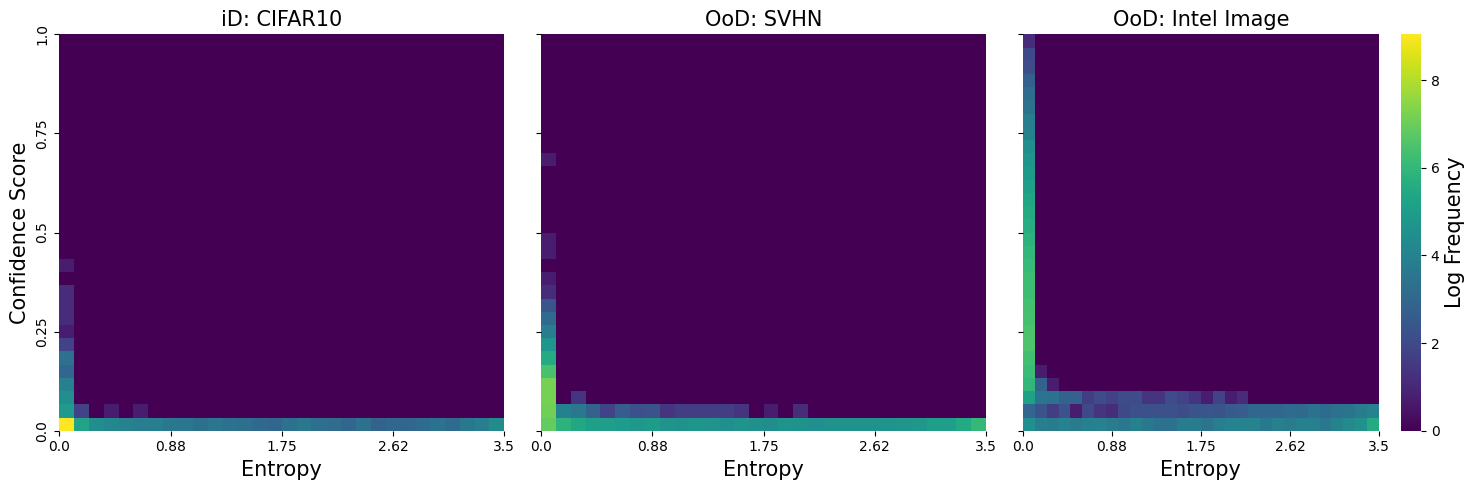

Normalized Heatmaps of Confidence vs. Entropy for different datasets.


In [95]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fontsize = 15
# plt.suptitle("Confidence Score vs. Entropy", fontsize=18)

base = np.e
hist_iid = np.emath.logn(base, np.histogram2d(entropy_y, confidence, bins=30)[0].T + 1e-31)
hist_svhn = np.emath.logn(base, np.histogram2d(entropy_svhn, confidence_svhn, bins=30)[0].T + 1e-31)
hist_intel = np.emath.logn(base, np.histogram2d(entropy_intel, confidence_intel, bins=30)[0].T * (len(entropy_y)/len(entropy_intel)) + 1e-31)

col_name = "viridis"
color_palette = sns.color_palette(col_name, as_cmap=True)
# Create heatmaps with normalized color scale
sns.heatmap(data=hist_iid, cmap=color_palette, cbar=False, ax=axes[0], cbar_kws={'label': 'Frequency'}, vmin=0, vmax=np.max(hist_iid))
sns.heatmap(data=hist_svhn, cmap=color_palette, cbar=False, ax=axes[1], cbar_kws={'label': 'Frequency'}, vmin=0, vmax=np.max(hist_iid))
sns.heatmap(data=hist_intel, cmap=color_palette, cbar=True, ax=axes[2], cbar_kws={'label': 'Frequency'}, vmin=0, vmax=np.max(hist_iid))

# Set plot titles
# axes[0].set_title("Confidence vs. Entropy (IID: CIFAR10)\nConfidence Range: [{:.2f}, {:.2f}], Entropy Range: [0, {:.2f}]".format(np.min(confidence), np.max(confidence), np.max(entropy_y)))
# axes[1].set_title("Confidence vs. Entropy (OOD: SVHN)\nConfidence Range: [{:.2f}, {:.2f}], Entropy Range: [0, {:.2f}]".format(np.min(confidence_svhn), np.max(confidence_svhn), np.max(entropy_svhn)))
# axes[2].set_title("Confidence vs. Entropy (OOD: INTEL)\nConfidence Range: [{:.2f}, {:.2f}], Entropy Range: [0, {:.2f}]".format(np.min(confidence_intel), np.max(confidence_intel), np.max(entropy_intel)))

axes[0].set_title("iD: CIFAR10".format(np.min(confidence), np.max(confidence), np.max(entropy_y)), fontsize=fontsize)
axes[1].set_title("OoD: SVHN".format(np.min(confidence_svhn), np.max(confidence_svhn), np.max(entropy_svhn)), fontsize=fontsize)
axes[2].set_title("OoD: Intel Image".format(np.min(confidence_intel), np.max(confidence_intel), np.max(entropy_intel)), fontsize=fontsize)

# Set colorbar labels
for ax in axes:
    try:
        ax.collections[0].colorbar.set_label('Log Frequency', fontsize=fontsize)
    except:
        pass

# Remove bin sizes on axes
for i,ax in enumerate(axes):
    ax.set_xticks(np.linspace(0,30,5))
    ax.set_xticklabels(np.round(np.linspace(0,3.5,5), 2), rotation = 0)

axes[0].set_yticks(np.linspace(0,30,5))
axes[0].set_yticklabels(np.round(np.linspace(0,1,5), 2))

# Set x and y axis labels
for i,ax in enumerate(axes):
    ax.set_xlabel("Entropy", fontsize=fontsize)
    ax.invert_yaxis()
axes[0].set_ylabel("Confidence Score", fontsize=fontsize)

plt.tight_layout()
# plt.savefig(f"heatmap_confidence_entropy_{col_name}.pdf", format="pdf", bbox_inches="tight")
plt.show()


print("Normalized Heatmaps of Confidence vs. Entropy for different datasets.")

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Create heatmaps with normalized color scale
sns.heatmap(data=np.histogram2d(entropy(test_preds_org), confidence_cnn, bins=50)[0], cmap="Blues", cbar=True, ax=axes[0], cbar_kws={'label': 'Frequency'}, vmin=0, vmax=np.max(entropy(test_preds_org)))
sns.heatmap(data=np.histogram2d(entropy(test_preds_svhn_cnn), confidence_svhn_cnn, bins=50)[0], cmap="Reds", cbar=True, ax=axes[1], cbar_kws={'label': 'Frequency'}, vmin=0, vmax=np.max(entropy(test_preds_svhn_cnn)))
sns.heatmap(data=np.histogram2d(entropy(test_preds_intel_cnn), confidence_intel_cnn, bins=50)[0], cmap="Greens", cbar=True, ax=axes[2], cbar_kws={'label': 'Frequency'}, vmin=0, vmax=np.max(entropy(test_preds_intel_cnn)))

# Set plot titles
axes[0].set_title("Confidence vs. Entropy (IID: CIFAR10)\nConfidence Range: [{:.2f}, {:.2f}], Entropy Range: [0, {:.2f}]".format(np.min(confidence_cnn), np.max(confidence_cnn), np.max(entropy(test_preds_org))))
axes[1].set_title("Confidence vs. Entropy (OOD: SVHN)\nConfidence Range: [{:.2f}, {:.2f}], Entropy Range: [0, {:.2f}]".format(np.min(confidence_svhn_cnn), np.max(confidence_svhn_cnn), np.max(entropy(test_preds_svhn_cnn))))
axes[2].set_title("Confidence vs. Entropy (OOD: INTEL)\nConfidence Range: [{:.2f}, {:.2f}], Entropy Range: [0, {:.2f}]".format(np.min(confidence_intel_cnn), np.max(confidence_intel_cnn), np.max(entropy(test_preds_intel_cnn))))

# Set colorbar labels
for ax in axes:
    ax.collections[0].colorbar.set_label('Frequency')

# Remove bin sizes on axes
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

# Set x and y axis labels
for ax in axes:
    ax.set_xlabel("Entropy")
    ax.set_ylabel("Confidence Score")

plt.tight_layout()
plt.show()


print("Normalized Heatmaps of Confidence vs. Entropy for different datasets.")


In [ ]:
confidence = np.max(final_bet_p, axis=1)
confidence_svhn = np.max(final_bet_p_svhn, axis=1)
confidence_intel = np.max(final_bet_p_intel, axis=1)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

sns.scatterplot(x=entropy_y, y=confidence, ax=axes[0], color='blue', alpha=0.5)
sns.scatterplot(x=entropy(final_bet_p_svhn), y=confidence_svhn, ax=axes[1], color='red', alpha=0.5)
sns.scatterplot(x=entropy(final_bet_p_intel), y=confidence_intel, ax=axes[2], color='green', alpha=0.5)

axes[0].set_title("Confidence vs. Entropy (IID: CIFAR10)")
axes[1].set_title("Confidence vs. Entropy (OOD: SVHN)")
axes[2].set_title("Confidence vs. Entropy (OOD: INTEL)")

for ax in axes:
    ax.set_xlabel("Entropy")
    ax.set_ylabel("Confidence Score")

plt.tight_layout()
plt.show()

print("Scatter plots of Confidence vs. Entropy for different datasets.")

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

sns.scatterplot(x=entropy(test_preds_cifar10_lbbnn), y=confidence_lbbnn_cifar10, ax=axes[0], color='blue', alpha=0.5)
sns.scatterplot(x=entropy(test_preds_svhn_lbbnn), y=confidence_lbbnn_svhn, ax=axes[1], color='red', alpha=0.5)
sns.scatterplot(x=entropy(test_preds_intel_lbbnn), y=confidence_lbbnn_intel, ax=axes[2], color='green', alpha=0.5)

axes[0].set_title("Confidence vs. Entropy (IID: CIFAR10)")
axes[1].set_title("Confidence vs. Entropy (OOD: SVHN)")
axes[2].set_title("Confidence vs. Entropy (OOD: INTEL)")

for ax in axes:
    ax.set_xlabel("Entropy")
    ax.set_ylabel("Confidence Score")

plt.tight_layout()
plt.show()

print("Scatter plots of Confidence vs. Entropy for different datasets.")

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

sns.scatterplot(x=entropy(test_preds_cifar10_enn), y=confidence_enn_cifar10, ax=axes[0], color='blue', alpha=0.5)
sns.scatterplot(x=entropy(test_preds_svhn_enn), y=confidence_enn_svhn, ax=axes[1], color='red', alpha=0.5)
sns.scatterplot(x=entropy(test_preds_intel_enn), y=confidence_enn_intel, ax=axes[2], color='green', alpha=0.5)

axes[0].set_title("Confidence vs. Entropy (IID: CIFAR10)")
axes[1].set_title("Confidence vs. Entropy (OOD: SVHN)")
axes[2].set_title("Confidence vs. Entropy (OOD: INTEL)")

for ax in axes:
    ax.set_xlabel("Entropy")
    ax.set_ylabel("Confidence Score")

plt.tight_layout()
plt.show()

print("Scatter plots of Confidence vs. Entropy for different datasets.")

### OOD (standard CNN)

In [ ]:
sorted_indices_cnn = np.argsort(confidence_cnn)
sorted_indices_svhn_cnn = np.argsort(confidence_svhn_cnn)
sorted_indices_intel_cnn = np.argsort(confidence_intel_cnn)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].plot(confidence_cnn[sorted_indices_cnn], entropy(test_preds_org)[sorted_indices_cnn], color='blue', label='IID: CIFAR10', alpha=0.5)
axs[0].set_title("Confidence vs Entropy (IID vs OOD)")
axs[0].set_xlabel("Confidence Score")
axs[0].set_ylabel("Entropy")
axs[0].legend()

axs[1].plot(confidence_svhn_cnn[sorted_indices_svhn_cnn], entropy(test_preds_svhn_cnn)[sorted_indices_svhn_cnn], color='red', label='OOD: SVHN', alpha=0.5)
#axs[1].plot(confidence_intel, entropy(test_preds_intel_cnn), color='green', label='OOD: INTEL', alpha=0.5)
axs[1].set_title("Confidence vs Entropy (IID vs OOD)")
axs[1].set_xlabel("Confidence Score")
axs[1].set_ylabel("Entropy")
axs[1].legend()

axs[2].plot(confidence_intel_cnn[sorted_indices_intel_cnn], entropy(test_preds_intel_cnn)[sorted_indices_intel_cnn], color='green', label='OOD: INTEL', alpha=0.5)
axs[2].set_title("Confidence vs Entropy (IID vs OOD)")
axs[2].set_xlabel("Confidence Score")
axs[2].set_ylabel("Entropy")
axs[2].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

sns.scatterplot(x=entropy(test_preds_org), y=confidence_cnn, ax=axes[0], color='blue', alpha=0.5)
sns.scatterplot(x=entropy(test_preds_svhn_cnn), y=confidence_svhn_cnn, ax=axes[1], color='blue', alpha=0.5)
sns.scatterplot(x=entropy(test_preds_intel_cnn), y=confidence_intel_cnn, ax=axes[2], color='blue', alpha=0.5)

axes[0].set_title("Confidence vs. Entropy (IID: CIFAR10)")
axes[1].set_title("Confidence vs. Entropy (OOD: SVHN)")
axes[2].set_title("Confidence vs. Entropy (OOD: INTEL)")

for ax in axes:
    ax.set_xlabel("Entropy")
    ax.set_ylabel("Confidence Score")

plt.tight_layout()
plt.show()

print("Scatter plots of Confidence vs. Entropy for different datasets.")

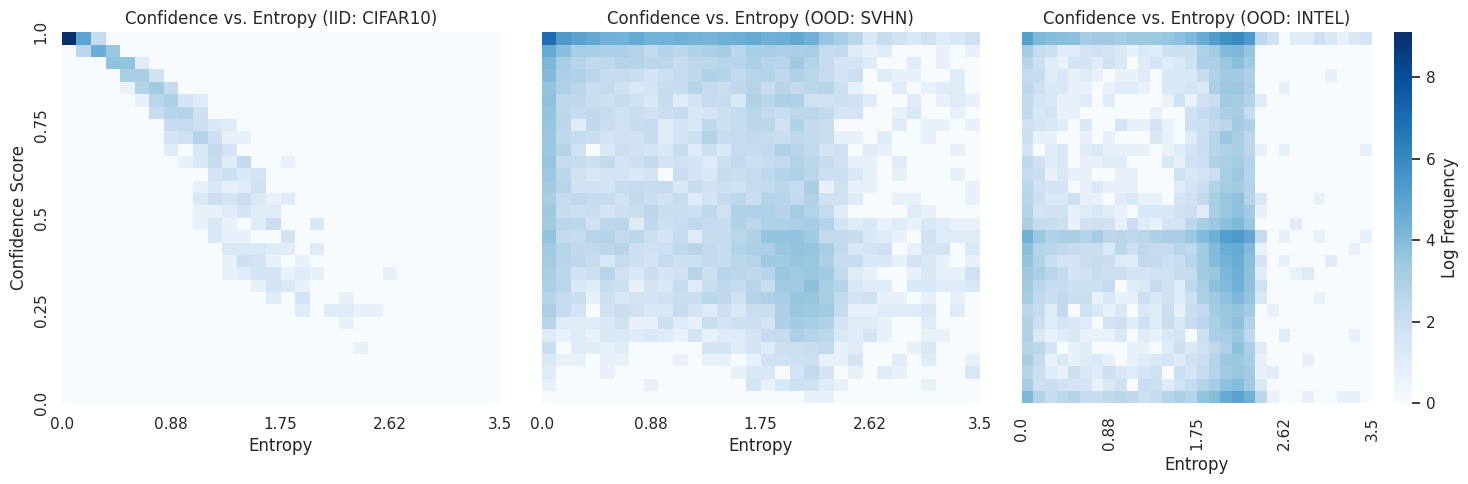

Normalized Heatmaps of Confidence vs. Entropy for different datasets.


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

base = np.e
hist_iid = np.emath.logn(base, np.histogram2d(entropy_y, confidence, bins=30)[0].T + 1e-31)
hist_svhn = np.emath.logn(base, np.histogram2d(entropy(final_bet_p_svhn), confidence_svhn, bins=30)[0].T + 1e-31)
hist_intel = np.emath.logn(base, np.histogram2d(entropy(final_bet_p_intel), confidence_intel, bins=30)[0].T + 1e-31)

# Create heatmaps with normalized color scale
sns.heatmap(data=hist_iid, cmap="Blues", cbar=False, ax=axes[0], cbar_kws={'label': 'Frequency'}, vmin=0, vmax=np.max(hist_iid))
sns.heatmap(data=hist_svhn, cmap="Blues", cbar=False, ax=axes[1], cbar_kws={'label': 'Frequency'}, vmin=0, vmax=np.max(hist_iid))
sns.heatmap(data=hist_intel, cmap="Blues", cbar=True, ax=axes[2], cbar_kws={'label': 'Frequency'}, vmin=0, vmax=np.max(hist_iid))

# Set plot titles
# axes[0].set_title("Confidence vs. Entropy (IID: CIFAR10)\nConfidence Range: [{:.2f}, {:.2f}], Entropy Range: [0, {:.2f}]".format(np.min(confidence), np.max(confidence), np.max(entropy_y)))
# axes[1].set_title("Confidence vs. Entropy (OOD: SVHN)\nConfidence Range: [{:.2f}, {:.2f}], Entropy Range: [0, {:.2f}]".format(np.min(confidence_svhn), np.max(confidence_svhn), np.max(entropy_svhn)))
# axes[2].set_title("Confidence vs. Entropy (OOD: INTEL)\nConfidence Range: [{:.2f}, {:.2f}], Entropy Range: [0, {:.2f}]".format(np.min(confidence_intel), np.max(confidence_intel), np.max(entropy_intel)))

axes[0].set_title("Confidence vs. Entropy (IID: CIFAR10)".format(np.min(confidence), np.max(confidence), np.max(entropy_y)))
axes[1].set_title("Confidence vs. Entropy (OOD: SVHN)".format(np.min(confidence_svhn), np.max(confidence_svhn), np.max(entropy(final_bet_p_svhn))))
axes[2].set_title("Confidence vs. Entropy (OOD: Intel Image)".format(np.min(confidence_intel), np.max(confidence_intel), np.max(entropy(final_bet_p_intel))))

# Set colorbar labels
for ax in axes:
    try:
        ax.collections[0].colorbar.set_label('Log Frequency')
    except:
        pass

# Remove bin sizes on axes
for i,ax in enumerate(axes):
    ax.set_xticks(np.linspace(0,30,5))
    ax.set_xticklabels(np.round(np.linspace(0,3.5,5), 2))

axes[0].set_yticks(np.linspace(0,30,5))
axes[0].set_yticklabels(np.round(np.linspace(0,1,5), 2))

# Set x and y axis labels
for ax in axes:
    ax.set_xlabel("Entropy")
    ax.invert_yaxis()
axes[0].set_ylabel("Confidence Score")

plt.tight_layout()
plt.show()


print("Normalized Heatmaps of Confidence vs. Entropy for different datasets.")

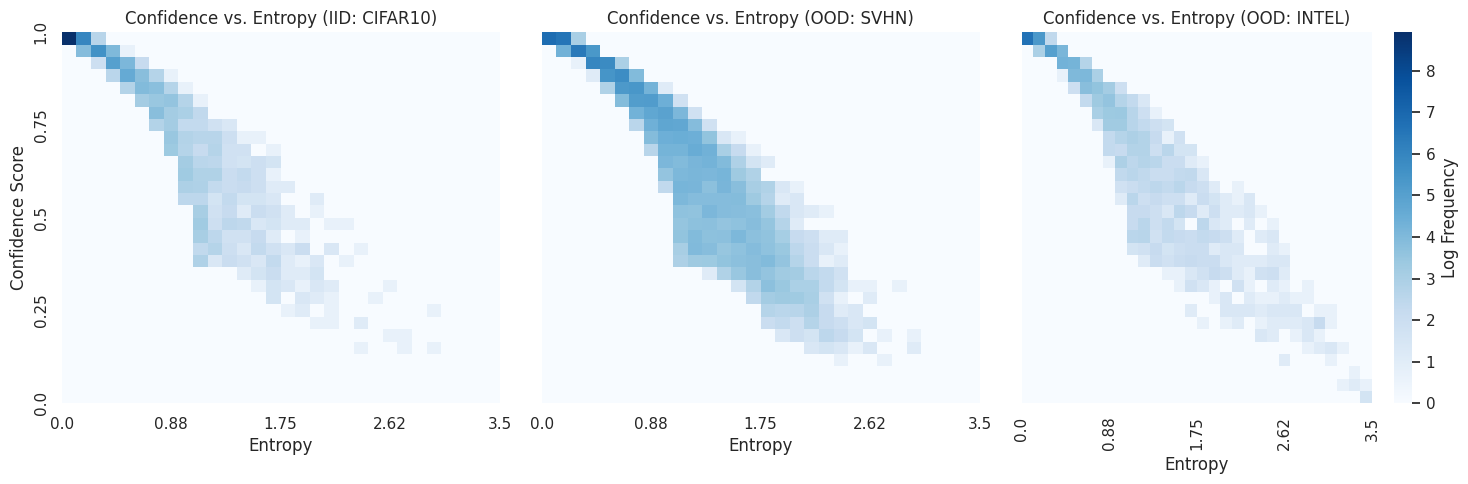

Normalized Heatmaps of Confidence vs. Entropy for different datasets.


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

base = np.e
hist_iid = np.emath.logn(base, np.histogram2d(entropy(test_preds_cifar10_lbbnn), confidence_lbbnn_cifar10, bins=30)[0].T + 1e-31)
hist_svhn = np.emath.logn(base, np.histogram2d(entropy(test_preds_svhn_lbbnn), confidence_lbbnn_svhn, bins=30)[0].T + 1e-31)
hist_intel = np.emath.logn(base, np.histogram2d(entropy(test_preds_intel_lbbnn), confidence_lbbnn_intel, bins=30)[0].T + 1e-31)

# Create heatmaps with normalized color scale
sns.heatmap(data=hist_iid, cmap="Blues", cbar=False, ax=axes[0], cbar_kws={'label': 'Frequency'}, vmin=0, vmax=np.max(hist_iid))
sns.heatmap(data=hist_svhn, cmap="Blues", cbar=False, ax=axes[1], cbar_kws={'label': 'Frequency'}, vmin=0, vmax=np.max(hist_iid))
sns.heatmap(data=hist_intel, cmap="Blues", cbar=True, ax=axes[2], cbar_kws={'label': 'Frequency'}, vmin=0, vmax=np.max(hist_iid))

# Set plot titles
# axes[0].set_title("Confidence vs. Entropy (IID: CIFAR10)\nConfidence Range: [{:.2f}, {:.2f}], Entropy Range: [0, {:.2f}]".format(np.min(confidence), np.max(confidence), np.max(entropy_y)))
# axes[1].set_title("Confidence vs. Entropy (OOD: SVHN)\nConfidence Range: [{:.2f}, {:.2f}], Entropy Range: [0, {:.2f}]".format(np.min(confidence_svhn), np.max(confidence_svhn), np.max(entropy_svhn)))
# axes[2].set_title("Confidence vs. Entropy (OOD: INTEL)\nConfidence Range: [{:.2f}, {:.2f}], Entropy Range: [0, {:.2f}]".format(np.min(confidence_intel), np.max(confidence_intel), np.max(entropy_intel)))

axes[0].set_title("Confidence vs. Entropy (IID: CIFAR10)".format(np.min(confidence), np.max(confidence), np.max(entropy_y)))
axes[1].set_title("Confidence vs. Entropy (OOD: SVHN)".format(np.min(confidence_svhn), np.max(confidence_svhn), np.max(entropy(final_bet_p_svhn))))
axes[2].set_title("Confidence vs. Entropy (OOD: INTEL)".format(np.min(confidence_intel), np.max(confidence_intel), np.max(entropy(final_bet_p_intel))))

# Set colorbar labels
for ax in axes:
    try:
        ax.collections[0].colorbar.set_label('Log Frequency')
    except:
        pass

# Remove bin sizes on axes
for i,ax in enumerate(axes):
    ax.set_xticks(np.linspace(0,30,5))
    ax.set_xticklabels(np.round(np.linspace(0,3.5,5), 2))

axes[0].set_yticks(np.linspace(0,30,5))
axes[0].set_yticklabels(np.round(np.linspace(0,1,5), 2))

# Set x and y axis labels
for ax in axes:
    ax.set_xlabel("Entropy")
    ax.invert_yaxis()
axes[0].set_ylabel("Confidence Score")

plt.tight_layout()
plt.show()


print("Normalized Heatmaps of Confidence vs. Entropy for different datasets.")

## OOD (CREDAL SET)

In [97]:
vertices_list_ood = []
for k in range(len(x_test_svhn)): 
  # print(y_test[k])
  vertices_list_ood.append(compute_vertices(test_preds_mass_svhn[k], classes, final_bet_p_indices_svhn[k]))
vertices_list_ood = np.array(vertices_list_ood)

In [98]:
vertices_list_intel = []
for k in range(len(test_preds_mass_intel)): 
  # print(y_test[k])
  vertices_list_intel.append(compute_vertices(test_preds_mass_intel[k], classes, final_bet_p_indices_intel[k]))
vertices_list_intel = np.array(vertices_list_intel)

NameError: name 'vertices_list_intel' is not defined

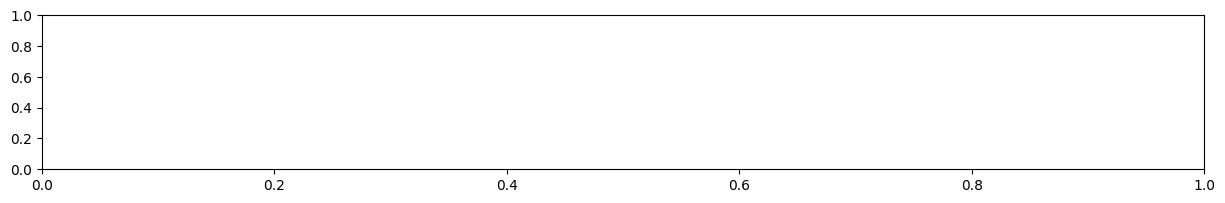

In [79]:
#os.makedirs("credal_plots_shaded_new/", exist_ok=True)

for i in range(0,1000,100):
    fig, ax = plt.subplots(figsize=(15, 2)) 
    font = {'family': 'sans-serif', 'weight': 'normal', 'size': 8}
    plt.rc('font', **font)
    
    # fig, ax = plt.subplots()
    ax.plot(np.max(vertices_list_intel[i:i+100], axis=-1), color='red', label='Max P', linewidth=0.7, linestyle="dotted", alpha=0.7)
    #ax.plot(np.max(final_bet_p_intel[i:i+100], axis=-1), color='red', label='BetP', linewidth=0.5)
    ax.plot(np.min(vertices_list_intel[i:i+100], axis=-1), color='red', label='Min P', linewidth=0.7, linestyle="dotted", alpha=0.7)
    ax.fill_between(np.arange(100),
        np.max(vertices_list_intel[i:i+100], axis=-1), np.min(vertices_list_intel[i:i+100], axis=-1), color='red', alpha=.09)
    
    plt.xlabel('Samples', fontdict=font)
    
    plt.legend()
    
    #plt.savefig(f"plots saved/credal_plot_intel_CIFAR10_nobetp_{i}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

In [99]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridisBig2 = cm.get_cmap('Oranges_r', 512)
newcmp2 = ListedColormap(viridisBig2(np.linspace(0, 0.25, 256)))

/tmp/ipykernel_3221508/644803833.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridisBig2 = cm.get_cmap('Oranges_r', 512)


In [100]:
viridisBig = cm.get_cmap('viridis', 512)
newcmp = ListedColormap(viridisBig(np.linspace(0.20, 0.45, 256)))

/tmp/ipykernel_3221508/1017487931.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridisBig = cm.get_cmap('viridis', 512)


In [109]:
# import matplotlib.pyplot as plt

# # Define your data and settings
# subset = vertices_list_ood
# max_values = np.max(subset, axis=1)
# min_values = np.min(subset, axis=1)

# # Create the figure and axis
# fig, ax = plt.subplots(figsize=(8, 5))

# x = np.arange(len(vertices_list_ood))

# threshold1 = 0.2  # Adjust this threshold value as needed
# line_width = 2  # Adjust the line width as desired

# for i in range(len(subset)):
#     if abs(max_values[i] - min_values[i]) < threshold1:
#         cmap = plt.cm.get_cmap(newcmp)
#         color = cmap((max_values[i] + min_values[i]) / 2)
#         ax.vlines(x[i], ymin=min_values[i], ymax=max_values[i], color=color, alpha=0.7, linewidth=line_width)

# cmap = plt.cm.get_cmap(newcmp)
# max_colors = cmap(max_values)
# min_colors = cmap(min_values)
# ax.scatter(x[max_values - min_values > threshold1], max_values[max_values - min_values > threshold1],
#            marker='_', s=10, c=max_colors[max_values - min_values > threshold1], label='Correctly Classified')
# ax.scatter(x[max_values - min_values > threshold1], min_values[max_values - min_values > threshold1],
#            marker='_', s=10, c=min_colors[max_values - min_values > threshold1])

# # Plot another set of max-min intervals with the Inferno colormap
# subset2 = vertices_list_intel  # Replace with your data for the second set
# max_values2 = np.max(subset2, axis=1)
# min_values2 = np.min(subset2, axis=1)

# x = np.arange(len(vertices_list_intel))

# threshold2 = 0
# for i in range(len(subset2)):
#     #if abs(max_values2[i] - min_values2[i]) > threshold2:
#         cmap2 = plt.cm.get_cmap(newcmp2)
#         color2 = cmap2((max_values2[i] + min_values2[i]) / 2)
#         ax.vlines(x[i], ymin=min_values2[i], ymax=max_values2[i], color=color2, alpha=0.7, linewidth=line_width)

# cmap2 = plt.cm.get_cmap(newcmp2)
# max_colors2 = cmap2(max_values2)
# min_colors2 = cmap2(min_values2)
# ax.scatter(x[max_values2 - min_values2 > threshold2], max_values2[max_values2 - min_values2 > threshold2],
#            marker='_', s=10, c=max_colors2[max_values2 - min_values2 > threshold2], label='Incorrectly Classified')
# ax.scatter(x[max_values2 - min_values2 > threshold2], min_values2[max_values2 - min_values2 > threshold2],
#            marker='_', s=10, c=min_colors2[max_values2 - min_values2 > threshold2])

# ax.set_xlabel('Samples')
# ax.set_ylabel('Extremal probability')

# ax.legend()

# sm = plt.cm.ScalarMappable(cmap=cmap)
# sm.set_array([]) 
# #cbar = plt.colorbar(sm)
# #plt.savefig("credal_set_width.pdf", format="pdf", bbox_inches="tight")
# plt.tight_layout()
# plt.show()

In [100]:
min_values = np.min(vertices_list_ood, axis=1)
max_values = np.max(vertices_list_ood, axis=1)
credal_set_width_svhn = max_values - min_values
credal_set_width_svhn

array([4.46103458e-04, 1.10305857e-01, 0.00000000e+00, ...,
       8.61318123e-01, 8.51361068e-01, 1.31718887e-02])

In [101]:
min_values_intel = np.min(vertices_list_intel, axis=1)
max_values_intel = np.max(vertices_list_intel, axis=1)
credal_set_width_intel = max_values_intel - min_values_intel
credal_set_width_intel

array([1.51010156e-01, 1.74041338e-06, 1.32542257e-02, ...,
       3.45040348e-06, 7.13469660e-07, 7.98816688e-03])

In [102]:
#################################### FULL 1024 set

print(f"Credal set width for IID = CIFAR10 : {np.mean(np.max(vertices_list, axis=1)-np.min(vertices_list, axis=1))} +/- {np.std(np.max(vertices_list, axis=1)-np.min(vertices_list, axis=1))}")
print(f"Credal set width for OOD = SVHN : {np.mean(credal_set_width_svhn)} +/- {np.std(credal_set_width_svhn)}")
print(f"Credal set width for OOD = INTEL : {np.mean(credal_set_width_intel)} +/- {np.std(credal_set_width_intel)}")

Credal set width for IID = CIFAR10 : 0.006820591762878564 +/- 0.046384068378053755
Credal set width for OOD = SVHN : 0.3084585980926007 +/- 0.3751162869544179
Credal set width for OOD = INTEL : 0.24294151196713187 +/- 0.3498244351685921


In [ ]:
print(f"Credal set width for IID = CIFAR10 : {np.mean(np.max(vertices_list, axis=1)-np.min(vertices_list, axis=1))} +/- {np.std(np.max(vertices_list, axis=1)-np.min(vertices_list, axis=1))}")
print(f"Credal set width for OOD = SVHN : {np.mean(credal_set_width_svhn)} +/- {np.std(credal_set_width_svhn)}")
print(f"Credal set width for OOD = INTEL : {np.mean(credal_set_width_intel)} +/- {np.std(credal_set_width_intel)}")

Credal set width for IID = CIFAR10 : 0.007187141311910238 +/- 0.04361738820261562
Credal set width for OOD = SVHN : 0.2604233675801755 +/- 0.3220713580505101
Credal set width for OOD = INTEL : 0.5871574498391087 +/- 0.3677933729964472


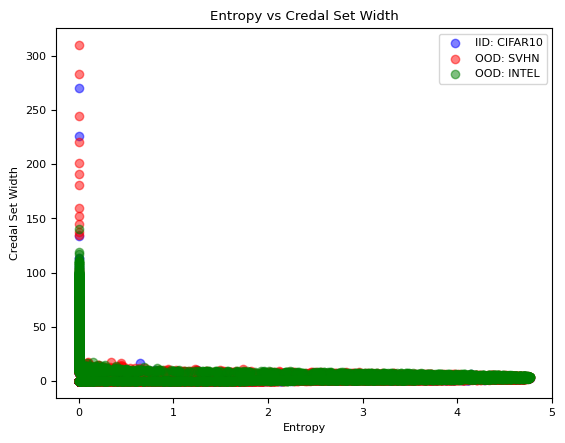

In [105]:
credal_set_width_iid = np.max(vertices_list, axis=1) - np.min(vertices_list, axis=1)

plt.scatter(entropy_y, credal_set_width_iid, color='blue', label='IID: CIFAR10', alpha=0.5)
plt.scatter(entropy(final_bet_p_svhn), credal_set_width_svhn, color='red', label='OOD: SVHN', alpha=0.5)
plt.scatter(entropy(final_bet_p_intel), credal_set_width_intel, color='green', label='OOD: INTEL', alpha=0.5)

plt.title("Entropy vs Credal Set Width")
plt.xlabel("Entropy")
plt.ylabel("Credal Set Width")
plt.legend()
plt.show()

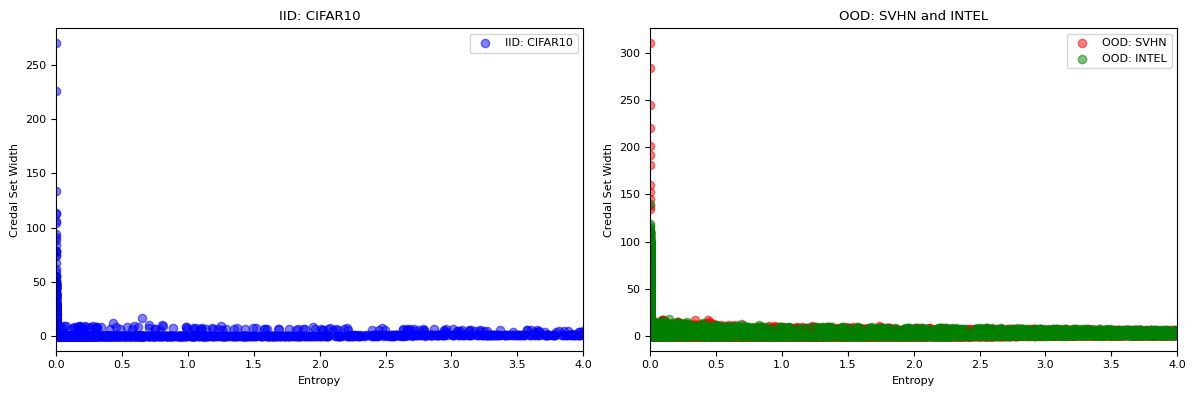

In [106]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].scatter(entropy_y, credal_set_width_iid, color='blue', label='IID: CIFAR10', alpha=0.5)
axs[0].set_title("IID: CIFAR10")
axs[0].set_xlabel("Entropy")
axs[0].set_ylabel("Credal Set Width")
axs[0].legend()
axs[0].set_xlim([0, 4])  

axs[1].scatter(entropy(final_bet_p_svhn), credal_set_width_svhn, color='red', label='OOD: SVHN', alpha=0.5)
axs[1].scatter(entropy(final_bet_p_intel), credal_set_width_intel, color='green', label='OOD: INTEL', alpha=0.5)
axs[1].set_title("OOD: SVHN and INTEL")
axs[1].set_xlabel("Entropy")
axs[1].set_ylabel("Credal Set Width")
axs[1].legend()
axs[1].set_xlim([0, 4]) 

plt.tight_layout()
plt.show()


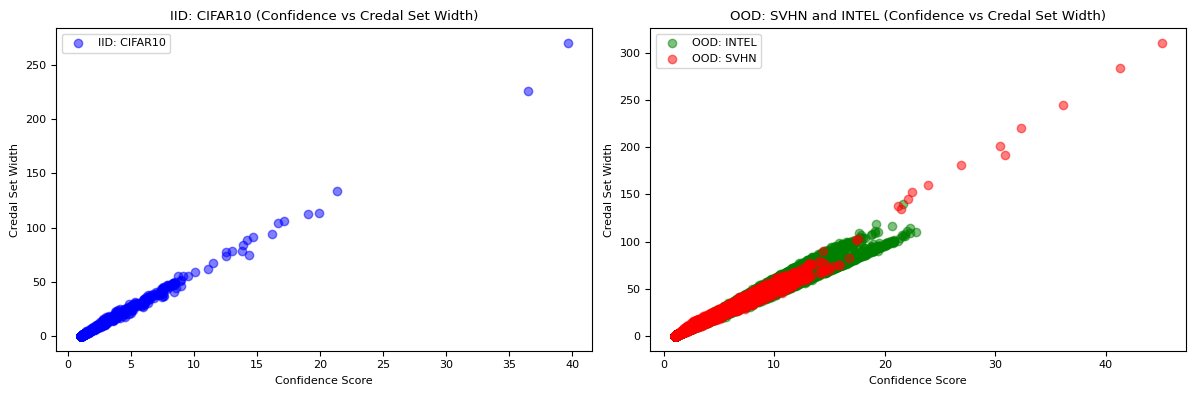

In [107]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Confidence vs Credal Set Width for CIFAR10
axs[0].scatter(confidence, credal_set_width_iid, color='blue', label='IID: CIFAR10', alpha=0.5)
axs[0].set_title("IID: CIFAR10 (Confidence vs Credal Set Width)")
axs[0].set_xlabel("Confidence Score")
axs[0].set_ylabel("Credal Set Width")
#axs[0].set_xlim([0.0, 1.0])  
axs[0].legend()

# Confidence vs Credal Set Width for SVHN and INTEL
axs[1].scatter(confidence_intel, credal_set_width_intel, color='green', label='OOD: INTEL', alpha=0.5)
axs[1].scatter(confidence_svhn, credal_set_width_svhn, color='red', label='OOD: SVHN', alpha=0.5)
#axs[1].scatter(confidence_intel, credal_set_width_intel, color='green', label='OOD: INTEL', alpha=0.5)
axs[1].set_title("OOD: SVHN and INTEL (Confidence vs Credal Set Width)")
axs[1].set_xlabel("Confidence Score")
axs[1].set_ylabel("Credal Set Width")
#axs[1].set_xlim([0.0, 1.0])  
axs[1].legend()

plt.tight_layout()
plt.show()


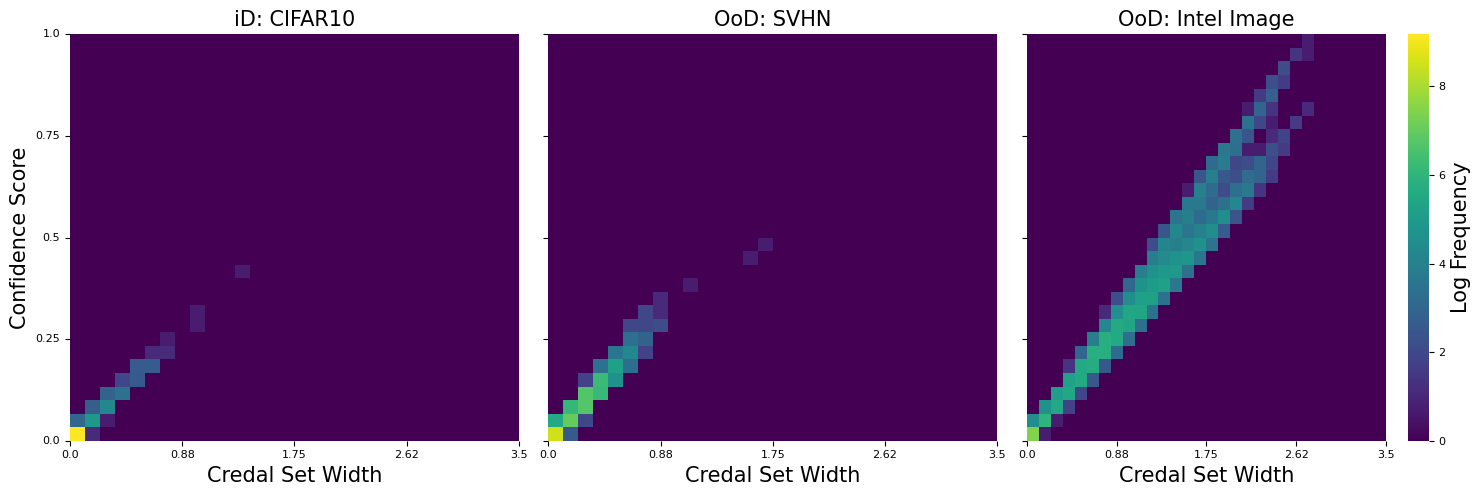

Normalized Heatmaps of Confidence vs. Credal Set Width for different datasets.


In [108]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fontsize = 15

base = np.e
hist_iid = np.emath.logn(base, np.histogram2d(credal_set_width_iid, confidence, bins=30)[0].T + 1e-31)
hist_svhn = np.emath.logn(base, np.histogram2d(credal_set_width_svhn, confidence_svhn, bins=30)[0].T + 1e-31)
hist_intel = np.emath.logn(base, np.histogram2d(credal_set_width_intel, confidence_intel, bins=30)[0].T * (len(entropy_y)/len(entropy_intel)) + 1e-31)

col_name = "viridis"
color_palette = sns.color_palette(col_name, as_cmap=True)
# Create heatmaps with normalized color scale
sns.heatmap(data=hist_iid, cmap=color_palette, cbar=False, ax=axes[0], cbar_kws={'label': 'Frequency'}, vmin=0, vmax=np.max(hist_iid))
sns.heatmap(data=hist_svhn, cmap=color_palette, cbar=False, ax=axes[1], cbar_kws={'label': 'Frequency'}, vmin=0, vmax=np.max(hist_iid))
sns.heatmap(data=hist_intel, cmap=color_palette, cbar=True, ax=axes[2], cbar_kws={'label': 'Frequency'}, vmin=0, vmax=np.max(hist_iid))

# Set plot titles
# axes[0].set_title("Confidence vs. Entropy (IID: CIFAR10)\nConfidence Range: [{:.2f}, {:.2f}], Entropy Range: [0, {:.2f}]".format(np.min(confidence), np.max(confidence), np.max(entropy_y)))
# axes[1].set_title("Confidence vs. Entropy (OOD: SVHN)\nConfidence Range: [{:.2f}, {:.2f}], Entropy Range: [0, {:.2f}]".format(np.min(confidence_svhn), np.max(confidence_svhn), np.max(entropy_svhn)))
# axes[2].set_title("Confidence vs. Entropy (OOD: INTEL)\nConfidence Range: [{:.2f}, {:.2f}], Entropy Range: [0, {:.2f}]".format(np.min(confidence_intel), np.max(confidence_intel), np.max(entropy_intel)))

axes[0].set_title("iD: CIFAR10".format(np.min(confidence), np.max(confidence), np.max(entropy_y)), fontsize=fontsize)
axes[1].set_title("OoD: SVHN".format(np.min(confidence_svhn), np.max(confidence_svhn), np.max(entropy_svhn)), fontsize=fontsize)
axes[2].set_title("OoD: Intel Image".format(np.min(confidence_intel), np.max(confidence_intel), np.max(entropy_intel)), fontsize=fontsize)

# Set colorbar labels
for ax in axes:
    try:
        ax.collections[0].colorbar.set_label('Log Frequency', fontsize=fontsize)
    except:
        pass

# Remove bin sizes on axes
for i,ax in enumerate(axes):
    ax.set_xticks(np.linspace(0,30,5))
    ax.set_xticklabels(np.round(np.linspace(0,3.5,5), 2), rotation=0)

axes[0].set_yticks(np.linspace(0,30,5))
axes[0].set_yticklabels(np.round(np.linspace(0,1,5), 2))

# Set x and y axis labels
for ax in axes:
    ax.set_xlabel("Credal Set Width", fontsize=fontsize)
    ax.invert_yaxis()
axes[0].set_ylabel("Confidence Score", fontsize=fontsize)

plt.tight_layout()
plt.savefig(f"heatmap_confidence_credal_set_width_{col_name}.pdf", format="pdf", bbox_inches="tight")
plt.show()


print("Normalized Heatmaps of Confidence vs. Credal Set Width for different datasets.")

# ABLATION STUDY

In [ ]:
# mass_coeff_matrix = mass_coeff(new_classes)
# mass_coeff_matrix = tf.cast(mass_coeff_matrix, tf.float32)



# def BinaryCrossEntropyAlpha(y_true, y_pred, ALPHA, BETA):
#   y_true = tf.cast(y_true, tf.float32)
#   y_true = K.clip(y_true, K.epsilon(), 1)
#   y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
#   term_0 = (1 - y_true) * K.log(1 - y_pred + K.epsilon())  
#   term_1 = y_true * K.log(y_pred + K.epsilon())
#   bce_loss = -K.mean(term_0 + term_1, axis=0)
  
#   mass = tf.matmul(y_pred, mass_coeff_matrix)

#   # alpha = tf.cast(tf.where(mass >= 0, tf.ones_like(mass), tf.zeros_like(mass)), dtype=tf.float32)
  
#   mass_reg = K.mean(tf.nn.relu(-mass), axis=0)

#   mass_sum = tf.nn.relu(K.mean(K.sum(mass, axis=-1)) - 1)
  
#   #add alpha to bce term 1 or 2
#   # alpha_reg = -K.mean((1 - alpha) * K.log(1 - y_true + K.epsilon()) + alpha * K.log(y_true + K.epsilon()), axis = 0)
  

#   total_loss = bce_loss + ALPHA * mass_reg + BETA * mass_sum
#   # tf.print(K.mean(bce_loss), K.sum(mass_reg), K.mean(total_loss))

#   return total_loss

In [ ]:
# mass_coeff_matrix = mass_coeff(new_classes)
# mass_coeff_matrix = tf.cast(mass_coeff_matrix, tf.float32)

# def BinaryCrossEntropyBeta(y_true, y_pred, BETA, ALPHA):
#   y_true = tf.cast(y_true, tf.float32)
#   y_true = K.clip(y_true, K.epsilon(), 1)
#   y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
#   term_0 = (1 - y_true) * K.log(1 - y_pred + K.epsilon())  
#   term_1 = y_true * K.log(y_pred + K.epsilon())
#   bce_loss = -K.mean(term_0 + term_1, axis=0)
  
#   mass = tf.matmul(y_pred, mass_coeff_matrix)

#   # alpha = tf.cast(tf.where(mass >= 0, tf.ones_like(mass), tf.zeros_like(mass)), dtype=tf.float32)
  
#   mass_reg = K.mean(tf.nn.relu(-mass), axis=0)

#   mass_sum = tf.nn.relu(K.mean(K.sum(mass, axis=-1)) - 1)
  
#   #add alpha to bce term 1 or 2
#   # alpha_reg = -K.mean((1 - alpha) * K.log(1 - y_true + K.epsilon()) + alpha * K.log(y_true + K.epsilon()), axis = 0)
  

#   total_loss = bce_loss + ALPHA * mass_reg + BETA * mass_sum
#   # tf.print(K.mean(bce_loss), K.sum(mass_reg), K.mean(total_loss))

#   return total_loss

In [ ]:
# alpha_values = [0.5, 0.6, 0.9, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0]  # List of different alpha values to test
# #beta_values = [0.5, 1.0, 1.5, 2.0, 5.0]  # List of different alpha values to test


# alpha_accuracies = [] 
# alpha_test_preds = []

# for ALPHA in alpha_values:
#     new_model.compile(optimizer="adam", loss=lambda y_true, y_pred: BinaryCrossEntropyAlpha(y_true, y_pred, ALPHA, BETA =1), metrics=['accuracy'])
#     history = new_model.fit(x_train, y_train_modified, batch_size=64, validation_data=(x_test, y_test_modified), epochs=25, shuffle=True, verbose=1)
#     test_preds_alpha = new_model.predict(x_test)
#     test_preds_mass_alpha = belief_to_mass(test_preds_alpha, new_classes)
#     test_preds_mass_alpha[test_preds_mass_alpha<0] = 0
#     sums_alpha = 1 - np.sum(test_preds_mass_alpha, axis=-1)
#     sums_alpha[sums_alpha<0] = 0
#     test_preds_mass_alpha = np.append(test_preds_mass_alpha, sums_alpha[:, None], axis=-1)
#     test_preds_mass_alpha = test_preds_mass_alpha/np.sum(test_preds_mass_alpha, axis=-1)[:, None]
#     final_bet_p_alpha = final_betp(test_preds_mass_alpha, classes)
#     final_bet_p_indices_alpha = np.argmax(final_bet_p_alpha, axis = -1)
#     accuracy_alpha = (np.sum(final_bet_p_indices_alpha == y_test)/len(y_test))*100
#     alpha_accuracies.append(accuracy_alpha)
#     alpha_test_preds.append(test_preds_alpha)

In [ ]:
# beta_values = [0.5, 0.6, 0.9, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0]  # List of different alpha values to test
# #beta_values = [0.5, 1.0, 1.5, 2.0, 5.0]  # List of different alpha values to test


# beta_accuracies = [] 
# beta_test_preds = []

# for BETA in beta_values:
#     new_model.compile(optimizer="adam", loss=lambda y_true, y_pred: BinaryCrossEntropyBeta(y_true, y_pred, BETA, ALPHA =1), metrics=['accuracy'])
#     history = new_model.fit(x_train, y_train_modified, batch_size=64, validation_data=(x_test, y_test_modified), epochs=25, shuffle=True, verbose=1)
#     test_preds_beta = new_model.predict(x_test)
#     test_preds_mass_beta = belief_to_mass(test_preds_beta, new_classes)
#     test_preds_mass_beta[test_preds_mass_beta<0] = 0
#     sums_beta = 1 - np.sum(test_preds_mass_beta, axis=-1)
#     sums_beta[sums_beta<0] = 0
#     test_preds_mass_beta = np.append(test_preds_mass_beta, sums_beta[:, None], axis=-1)
#     test_preds_mass_beta = test_preds_mass_beta/np.sum(test_preds_mass_beta, axis=-1)[:, None]
#     final_bet_p_beta = final_betp(test_preds_mass_beta, classes)
#     final_bet_p_indices_beta = np.argmax(final_bet_p_beta, axis = -1)
#     accuracy_beta = (np.sum(final_bet_p_indices_beta == y_test)/len(y_test))*100
#     beta_accuracies.append(accuracy_beta)
#     beta_test_preds.append(test_preds_beta)

In [ ]:
font = {'family': 'sans-serif', 'weight': 'normal', 'size': 8}
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rc('font', **font)
plt.figure(figsize=(8, 3))
sns.lineplot(alpha_accuracies, marker='o', label = 'α')
sns.lineplot(beta_accuracies, marker='o', color= 'crimson', label = 'β')
plt.xlabel('Hyperparameters α & β', fontdict=font)
plt.ylabel('Test Accuracy', fontdict=font)
#plt.xticks(beta_values)
#plt.title('Validation Accuracy vs Alpha')
plt.savefig("alpha_beta_acc.pdf", format="pdf", bbox_inches="tight")
plt.legend()
plt.show()

In [ ]:
alpha_test_preds = (np.array(alpha_test_preds))
beta_test_preds = (np.array(beta_test_preds))

In [ ]:
msum_a =[]
msum_b = []
mreg_a = []
mreg_b = []

for i, ALPHA in enumerate(alpha_values):
    mass_a = belief_to_mass(alpha_test_preds[i,:,:], new_classes)
    mass_b = belief_to_mass(beta_test_preds[i,:,:], new_classes)
    mass_reg_a = K.mean(tf.nn.relu(-mass_a))
    mass_reg_b = tf.nn.relu(-mass_b)
    mass_sum_a = K.mean(K.sum(mass_a, axis=-1))
    mass_sum_b = K.mean(K.sum(mass_b, axis=-1))
    msum_a.append(mass_sum_a)
    msum_b.append(mass_sum_b)
    mreg_a.append(mass_reg_a)
    mreg_b.append(mass_reg_b)

In [ ]:
msum_a = (np.array(msum_a))
msum_b = (np.array(msum_b))
mreg_a = (np.array(mreg_a))
mreg_b = (np.array(mreg_b))


In [ ]:
mreg_a.shape

In [ ]:
np.mean(msum_b)

In [ ]:
b = [0, 1.0,2.0, 3.0,  4.0,  5.0, 6.0,  7.0,  8.0, 9]  # List of different alpha values to test

font = {'family': 'sans-serif', 'weight': 'normal', 'size': 10}
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rc('font', **font)
plt.figure(figsize=(15, 5))
sns.lineplot(x=beta_values, y=msum_b, marker='o', label = 'M_s')
#sns.lineplot(msum_b, marker='o', color= 'crimson', label = 'β')
plt.xlabel('Hyperparameter β', fontdict=font)
#plt.ylabel('Test Accuracy', fontdict=font)
plt.xticks(beta_values)
plt.xticks(rotation=0, ha='left')
#plt.title('Validation Accuracy vs Alpha')
plt.savefig("beta_msum.pdf", format="pdf", bbox_inches="tight")
plt.legend()
plt.show()

## ENTROPY

In [ ]:
font = {'family': 'sans-serif', 'weight': 'normal', 'size': 10}
#plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rc('font', **font)
plt.figure(figsize=(15, 5))
sns.lineplot(x=beta_values, y=mreg_a, color = 'crimson', marker='o', label = 'M_r')
#sns.lineplot(msum_b, marker='o', color= 'crimson', label = 'β')
plt.xlabel('Hyperparameters α', fontdict=font)
#plt.ylabel('Test Accuracy', fontdict=font)
plt.xticks(beta_values)
plt.xticks(rotation=0, ha='left')
#plt.title('Validation Accuracy vs Alpha')
plt.savefig("alpha_mreg.pdf", format="pdf", bbox_inches="tight")
plt.legend()
plt.show()

## mnist plot

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Test accuracies data
data = {
    'Noise': [0.3, 0.4, 0.5, 0.6, 0.7],
    'Standard CNN for Noisy': [93.40, 79.15, 58.33, 40.19, 28.59],
    'Standard CNN for Rotated': [57.92, 57.17, 58.08, 57.72, 57.47],
    'BetP for Rotated': [59.03, 58.24, 59.39, 58.97, 59.13],
    'BetP for Noisy': [96.90, 85.91, 68.33, 51.46, 38.05]
}

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the test accuracies
sns.lineplot(data=df, x='Noise', y='Standard CNN for Noisy', marker='o', label='Standard CNN for Noisy', ax=ax)
sns.lineplot(data=df, x='Noise', y='Standard CNN for Rotated', marker='o', label='Standard CNN for Rotated', ax=ax)
sns.lineplot(data=df, x='Noise', y='BetP for Rotated', marker='o', label='BetP for Rotated', ax=ax)
sns.lineplot(data=df, x='Noise', y='BetP for Noisy', marker='o', label='BetP for Noisy', ax=ax)

# Customize the plot
ax.set_xlabel('Noise')
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracies for Different Noise Levels')
ax.legend()

# Show the plot
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Test accuracies for different noise levels
noise = [0.3, 0.4, 0.5, 0.6, 0.7]
standard_cnn_noisy = [93.40, 79.15, 58.33, 40.19, 28.59]
standard_cnn_rotated = [57.92, 57.17, 58.08, 57.72, 57.47]
betp_rotated = [59.03, 58.24, 59.39, 58.97, 59.13]
betp_noisy = [96.90, 85.91, 68.33, 51.46, 38.05]

# Calculate mean and standard deviation
mean_standard_cnn_noisy = np.mean(standard_cnn_noisy)
mean_standard_cnn_rotated = np.mean(standard_cnn_rotated)
mean_betp_rotated = np.mean(betp_rotated)
mean_betp_noisy = np.mean(betp_noisy)

std_standard_cnn_noisy = np.std(standard_cnn_noisy)
std_standard_cnn_rotated = np.std(standard_cnn_rotated)
std_betp_rotated = np.std(betp_rotated)
std_betp_noisy = np.std(betp_noisy)

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the error bars
ax.errorbar(noise, standard_cnn_noisy, yerr=std_standard_cnn_noisy, label='Standard CNN (Noisy)', marker='o', capsize=4)
#ax.errorbar(noise, standard_cnn_rotated, yerr=std_standard_cnn_rotated, label='Standard CNN (Rotated)', marker='o', capsize=4)
#ax.errorbar(noise, betp_rotated, yerr=std_betp_rotated, label='BetP (Rotated)', marker='o', capsize=4)
ax.errorbar(noise, betp_noisy, yerr=std_betp_noisy, label='BetP (Noisy)', marker='o', capsize=4)

# Customize the plot
ax.set_xlabel('Noise')
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracies for Different Noise Levels')
ax.legend()

# Show the plot
plt.show()
